# Sepsis Treatment Policy: Evaluation & Interpretability Analysis

## 📋 Notebook Organization

This notebook performs comprehensive evaluation and interpretability analysis of sepsis treatment policies:

### **Part 1: Setup & Preparation** (Cells 1-6)
- Import libraries and define features
- Load datasets
- Define custom neural network encoders
- Load trained models (DoubleDQN with Attention, DiscreteSAC with Residual)

### **Part 2: Policy Evaluation** (Cells 7-8)
- **Comprehensive Performance Metrics**: Survival rates, rewards, episode statistics
- **Statistical Comparison**: T-tests, effect sizes, confidence intervals
- **Clinical Metrics**: Treatment patterns, SOFA scores, efficiency

### **Part 3: Policy Interpretability** (Cells 9+)
- **LEG Analysis**: Linearly Estimated Gradients for feature importance
- **Visualization**: Feature saliency, treatment patterns, decision explanations
- **Cross-Model Comparison**: Feature importance across different policies

---

## 🎯 Quick Start
1. Run all cells in order
2. Results saved to `./sepsis_leg_analysis/` directory
3. Key outputs: comparison plots, statistical tables, LEG visualizations

---


In [1]:
# import necessary libraries
import numpy as np
import torch
import gym
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import pandas as pd
from collections import defaultdict
import os
import pickle
import d3rlpy
from d3rlpy.dataset import MDPDataset


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
c:\Users\liuji\Dropbox\HomeSweetHome\GWU\Yalun Stat\2025 Fall\Project1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Name the features and actions
# Feature names from the Gym-Sepsis environment
FEATURE_NAMES = [
    'albumin', 'anion_gap', 'band_neutrophils', 'bicarbonate', 'bilirubin',
    'BUN', 'chloride', 'creatinine', 'diastolic_BP', 'glucose_1', 'glucose_2',
    'heart_rate', 'hematocrit', 'hemoglobin', 'INR', 'lactate', 'mean_BP',
    'PaCO2', 'platelet_count', 'potassium', 'PT', 'PTT', 'respiratory_rate',
    'sodium', 'SpO2', 'systolic_BP', 'temperature', 'WBC', 'age', 'gender',
    'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
    'weight', 'ventilation', 'SOFA', 'LODS', 'SIRS', 'qSOFA',
    'qSOFA_sysbp', 'qSOFA_gcs', 'qSOFA_resprate', 'elixhauser', 'blood_culture'
]

ACTION_NAMES = {
    0: '0 - IV, 1-VP',
    1: '0 - IV, 2-VP',
    2: '0 - IV, 3-VP',
    3: '0 - IV, 4-VP',
    4: '1 - IV, 0-VP',
    5: '1 - IV, 1-VP',
    6: '1 - IV, 2-VP',
    7: '1 - IV, 3-VP',
    8: '1 - IV, 4-VP',
    9: '2 - IV, 0-VP',
    10: '2 - IV, 1-VP',
    11: '2 - IV, 2-VP',
    12: '2 - IV, 3-VP',
    13: '2 - IV, 4-VP',
    14: '3 - IV, 0-VP',
    15: '3 - IV, 1-VP',
    16: '3 - IV, 2-VP',
    17: '3 - IV, 3-VP',
    18: '3 - IV, 4-VP',
    19: '4 - IV, 0-VP',
    20: '4 - IV, 1-VP',
    21: '4 - IV, 2-VP',
    22: '4 - IV, 3-VP',
    23: '4 - IV, 4-VP'
}

In [3]:
# Step1: Prepare the dataset
import pickle
import numpy as np
from d3rlpy.dataset import MDPDataset
import d3rlpy

# Load the dataset
file_path = r"C:\Users\liuji\Dropbox\HomeSweetHome\GWU\Yalun Stat\2025 Fall\Project1\STAT8289_project1\sepsis_data_set_1000ep_random_20251005_202927.pkl"

file_path_test = r"C:\Users\liuji\Dropbox\HomeSweetHome\GWU\Yalun Stat\2025 Fall\Project1\STAT8289_project1\sepsis_data_set_test_200ep_random_20251013_151754.pkl"

with open(file_path, 'rb') as f:
    train_set = pickle.load(f)

with open(file_path_test, 'rb') as f:
    test_set = pickle.load(f)

In [4]:
# STEP 2A: Define Custom Encoder Architectures (EXACT COPIES FROM TRAINING)
# These must match exactly what was used during training to load the models successfully
import torch
import torch.nn as nn
from d3rlpy.models.encoders import EncoderFactory, Encoder, register_encoder_factory
from d3rlpy.types import Shape
from typing import Sequence

# ============================================================================
# CUSTOM ENCODER 1: Deep Network with Residual Connections
# ============================================================================
class DeepResidualEncoder(Encoder):
    """Deep encoder with residual connections for better gradient flow."""
    
    def __init__(self, observation_shape: Shape, hidden_units: Sequence[int] = [256, 256, 256], 
                 activation: str = 'relu', dropout_rate: float = 0.1):
        super().__init__()
        self.observation_shape = observation_shape
        self.hidden_units = hidden_units
        self._feature_size = hidden_units[-1]
        
        # Handle Shape type (can be 1D or 2D)
        input_size = observation_shape[0] if isinstance(observation_shape[0], int) else observation_shape[0][0]
        
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_units[0])
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        self.residual_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        for i in range(len(hidden_units) - 1):
            self.hidden_layers.append(nn.Linear(hidden_units[i], hidden_units[i + 1]))
            # Residual connection (only if dimensions match)
            if hidden_units[i] == hidden_units[i + 1]:
                self.residual_layers.append(nn.Identity())
            else:
                self.residual_layers.append(nn.Linear(hidden_units[i], hidden_units[i + 1]))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
        
        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'elu':
            self.activation = nn.ELU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2)
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
        # Layer normalization
        self.layer_norms = nn.ModuleList([nn.LayerNorm(h) for h in hidden_units])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input layer
        h = self.activation(self.input_layer(x))
        h = self.layer_norms[0](h)
        
        # Hidden layers with residual connections
        for i, (hidden, residual, dropout) in enumerate(zip(self.hidden_layers, 
                                                             self.residual_layers, 
                                                             self.dropout_layers)):
            identity = residual(h)
            h = hidden(h)
            h = self.activation(h)
            h = self.layer_norms[i + 1](h)
            h = h + identity  # Residual connection
            h = dropout(h)
        
        return h
    
    def get_feature_size(self) -> int:
        return self._feature_size


class DeepResidualEncoderFactory(EncoderFactory):
    """Factory for creating deep residual encoders."""
    
    TYPE: str = "deep_residual"
    
    def __init__(self, hidden_units: Sequence[int] = [256, 256, 256], 
                 activation: str = 'relu', dropout_rate: float = 0.1):
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
    
    def create(self, observation_shape: Shape) -> DeepResidualEncoder:
        return DeepResidualEncoder(
            observation_shape=observation_shape,
            hidden_units=self.hidden_units,
            activation=self.activation,
            dropout_rate=self.dropout_rate
        )
    
    def get_params(self, deep: bool = False) -> dict:
        return {
            'hidden_units': self.hidden_units,
            'activation': self.activation,
            'dropout_rate': self.dropout_rate
        }

    @staticmethod
    def get_type() -> str:
        return "deep_residual"


# ============================================================================
# CUSTOM ENCODER 2: Attention-Based Encoder
# ============================================================================
class AttentionEncoder(Encoder):
    """Encoder with self-attention mechanism for feature importance."""
    
    def __init__(self, observation_shape: Shape, hidden_units: Sequence[int] = [256, 128],
                 n_heads: int = 4, activation: str = 'relu'):
        super().__init__()
        self.observation_shape = observation_shape
        self._feature_size = hidden_units[-1]
        
        # Handle Shape type (can be 1D or 2D)
        input_size = observation_shape[0] if isinstance(observation_shape[0], int) else observation_shape[0][0]
        
        # Project input to match hidden size for attention (MUST BE input_proj, not input_layer!)
        self.input_proj = nn.Linear(input_size, hidden_units[0])
        
        # Multi-head attention (treating features as a sequence of length 1)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_units[0],
            num_heads=n_heads,
            batch_first=True
        )
        
        # Feed-forward layers
        self.ff_layers = nn.ModuleList()
        for i in range(len(hidden_units) - 1):
            self.ff_layers.append(nn.Linear(hidden_units[i], hidden_units[i + 1]))
        
        # Activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            self.activation = nn.ReLU()
        
        # Layer norm
        self.layer_norm = nn.LayerNorm(hidden_units[0])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Project input
        h = self.input_proj(x)
        
        # Add batch dimension for attention if needed
        # Attention expects (batch, seq_len, features)
        h_reshaped = h.unsqueeze(1)  # (batch, 1, features)
        
        # Self-attention
        attn_out, _ = self.attention(h_reshaped, h_reshaped, h_reshaped)
        attn_out = attn_out.squeeze(1)  # (batch, features)
        
        # Residual connection + layer norm
        h = self.layer_norm(h + attn_out)
        h = self.activation(h)
        
        # Feed-forward layers
        for layer in self.ff_layers:
            h = layer(h)
            h = self.activation(h)
        
        return h
    
    def get_feature_size(self) -> int:
        return self._feature_size


class AttentionEncoderFactory(EncoderFactory):
    """Factory for creating attention-based encoders."""
    
    TYPE: str = "attention"
    
    def __init__(self, hidden_units: Sequence[int] = [256, 128], 
                 n_heads: int = 4, activation: str = 'relu'):
        self.hidden_units = hidden_units
        self.n_heads = n_heads
        self.activation = activation
    
    def create(self, observation_shape: Shape) -> AttentionEncoder:
        return AttentionEncoder(
            observation_shape=observation_shape,
            hidden_units=self.hidden_units,
            n_heads=self.n_heads,
            activation=self.activation
        )
    
    def get_params(self, deep: bool = False) -> dict:
        return {
            'hidden_units': self.hidden_units,
            'n_heads': self.n_heads,
            'activation': self.activation
        }

    @staticmethod
    def get_type() -> str:
        return "attention"


# Register custom encoders (allows loading from saved models)
register_encoder_factory(DeepResidualEncoderFactory)
register_encoder_factory(AttentionEncoderFactory)

print("✓ Custom Encoder Factories Registered:")
print("  1. DeepResidualEncoderFactory - Deep network with residual connections")
print("  2. AttentionEncoderFactory - Self-attention based encoder")
print("\nAll encoders registered and ready for model loading!")


✓ Custom Encoder Factories Registered:
  1. DeepResidualEncoderFactory - Deep network with residual connections
  2. AttentionEncoderFactory - Self-attention based encoder

All encoders registered and ready for model loading!


In [5]:
# STEP 2B: Load Multiple Models
from d3rlpy.algos import DoubleDQN, DiscreteSAC
from pathlib import Path
import glob

print('\n' + '='*80)
print('STEP 2B: Loading Trained Models')
print('='*80)

# Define model paths
BASE_DIR = r"C:\Users\liuji\Dropbox\HomeSweetHome\GWU\Yalun Stat\2025 Fall\Project1\STAT8289_project1"
MODEL_DIR = os.path.join(BASE_DIR, "final_model")

# List of model paths to analyze
MODEL_PATHS = [
    os.path.join(MODEL_DIR, "ddqn_online_att_model_final.d3"),
    os.path.join(MODEL_DIR, "ddqn_online_res_model_final.d3"),
    os.path.join(MODEL_DIR, "sac_online_model_final.d3")
]

# Optional: You can also add the standard DQN model from the parent directory
# MODEL_PATHS.append(os.path.join(BASE_DIR, "online_dqn_sepsis_d3rlpy_final.d3"))

# Alternative: Automatically find all .d3 models in directory
# MODEL_PATHS = glob.glob(os.path.join(MODEL_DIR, "*.d3"))

# Load all models
models = {}
print(f"\nAttempting to load {len(MODEL_PATHS)} model(s)...\n")

for i, model_path in enumerate(MODEL_PATHS):
    model_name = Path(model_path).stem
    print(f"[{i+1}/{len(MODEL_PATHS)}] Loading: {model_name}")
    
    # Check if file exists
    if not os.path.exists(model_path):
        print(f"  ✗ File not found: {model_path}")
        continue
    
    try:
        # Load using d3rlpy.load_learnable() which works for all model types
        model = d3rlpy.load_learnable(model_path)
        models[model_name] = model
        print(f"  ✓ Successfully loaded (Type: {type(model).__name__})")
        
    except Exception as e:
        print(f"  ✗ Failed to load: {str(e)[:100]}")
        continue

# Summary
print('\n' + '='*80)
if len(models) > 0:
    print(f"✓ SUCCESS: Loaded {len(models)} model(s)")
    for name in models.keys():
        print(f"  • {name}")
else:
    print("✗ ERROR: No models were loaded successfully")
    print("\nTroubleshooting:")
    print("  1. Ensure custom encoders in Cell 3 were registered (run Cell 3 first)")
    print("  2. Check that model files exist in the final_model directory")
    print("  3. Verify encoder definitions match exactly with training code")
print('='*80)


STEP 2B: Loading Trained Models

Attempting to load 3 model(s)...

[1/3] Loading: ddqn_online_att_model_final


c:\Users\liuji\Dropbox\HomeSweetHome\GWU\Yalun Stat\2025 Fall\Project1\.venv\lib\site-packages\d3rlpy\torch_utility.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk

  ✓ Successfully loaded (Type: DoubleDQN)
[2/3] Loading: ddqn_online_res_model_final
  ✓ Successfully loaded (Type: DoubleDQN)
[3/3] Loading: sac_online_model_final
  ✓ Successfully loaded (Type: DiscreteSAC)

✓ SUCCESS: Loaded 3 model(s)
  • ddqn_online_att_model_final
  • ddqn_online_res_model_final
  • sac_online_model_final


# Part 2: Policy Evaluation

## 📊 Comprehensive Performance Analysis

Now that models are loaded, we evaluate their clinical performance using:
- **Survival/Mortality Rates**
- **Episode Rewards and Statistics**
- **Treatment Patterns** (IV fluids, Vasopressors)
- **Action Diversity** (entropy)
- **Statistical Significance Testing**

This section runs 100 evaluation episodes per model to gather robust statistics.


In [6]:
class LEGAnalyzer:
    """Linearly Estimated Gradient analyzer for d3rlpy DQN policy."""
    
    def __init__(
        self,
        dqn_model,
        feature_names: List[str],
        n_samples: int = 1000,
        perturbation_std: float = 0.1
    ):
        """
        Initialize LEG analyzer.
        
        Args:
            dqn_model: Trained d3rlpy DQN model
            feature_names: Names of state features
            n_samples: Number of perturbation samples
            perturbation_std: Standard deviation for perturbations
        """
        self.dqn = dqn_model
        self.feature_names = feature_names
        self.n_samples = n_samples
        self.perturbation_std = perturbation_std
        
        # Get action dimension
        self.action_dim = 24  # Sepsis environment has 24 actions (0-23)
    
    def get_q_values(self, state: np.ndarray) -> np.ndarray:
        """Get Q-values for all actions given state."""
        if len(state.shape) == 1:
            state = state.reshape(1, -1)
        
        q_values = np.array([
            self.dqn.predict_value(state, np.array([a]))[0]
            for a in range(self.action_dim)
        ])
        return q_values
    
    def compute_saliency_scores(
        self,
        state: np.ndarray,
        feature_indices: List[int] = None,
        feature_ranges: Dict[int, Tuple[float, float]] = None
    ) -> Dict[str, np.ndarray]:
        """
        Compute LEG saliency scores for all actions.
        
        Args:
            state: Current state (46-dimensional)
            feature_indices: Indices of features to perturb (None = all)
            feature_ranges: Valid ranges for each feature (for clipping)
        
        Returns:
            Dictionary mapping action indices to saliency score arrays
        """
        if feature_indices is None:
            feature_indices = list(range(len(state)))
        
        # Get Q-values for original state
        q_values_original = self.get_q_values(state)
        
        n_features = len(feature_indices)
        
        # Initialize saliency scores for each action
        saliency_scores = {action: np.zeros(len(state)) for action in range(self.action_dim)}
        
        # Generate perturbations from uniform distribution
        perturbations = np.random.normal(0, self.perturbation_std, 
                                        (self.n_samples, n_features))
        
        # Compute covariance matrix
        Sigma = np.cov(perturbations.T)
        # Add small ridge for numerical stability
        Sigma += np.eye(Sigma.shape[0]) * 1e-6
        Sigma_inv = np.linalg.pinv(Sigma)
        
        # Store differences
        Z_list = []
        y_diff_list = {action: [] for action in range(self.action_dim)}
        
        for i in range(self.n_samples):
            # Create perturbed state
            perturbed_state = state.copy()
            perturbed_state[feature_indices] += perturbations[i]
            
            # Clip to valid ranges if provided
            if feature_ranges:
                for idx, feature_idx in enumerate(feature_indices):
                    if feature_idx in feature_ranges:
                        min_val, max_val = feature_ranges[feature_idx]
                        perturbed_state[feature_idx] = np.clip(
                            perturbed_state[feature_idx], min_val, max_val
                        )
            
            # Get Q-values for perturbed state
            q_values_perturbed = self.get_q_values(perturbed_state)
            
            # Store Z (perturbation)
            Z_list.append(perturbations[i])
            
            # Store y differences for each action
            for action in range(self.action_dim):
                y_diff = q_values_perturbed[action] - q_values_original[action]
                y_diff_list[action].append(y_diff)
        
        # Convert to arrays
        Z_array = np.array(Z_list)
        
        # Compute LEG gradient estimate for each action (Equation 1 from paper)
        for action in range(self.action_dim):
            y_diff_array = np.array(y_diff_list[action])
            
            # γ̂(π, s₀, F) = Σ⁻¹ (1/n) Σᵢ(ŷᵢZᵢ)
            gradient_reduced = Sigma_inv @ (Z_array.T @ y_diff_array) / self.n_samples
            
            # Map back to full feature space
            for idx, feature_idx in enumerate(feature_indices):
                saliency_scores[action][feature_idx] = gradient_reduced[idx]
        
        return saliency_scores
    
    def analyze_state(
        self,
        state: np.ndarray,
        top_k: int = 15,
        feature_subset: List[str] = None
    ) -> Dict:
        """
        Perform comprehensive LEG analysis on a state.
        
        Args:
            state: Current state
            top_k: Number of top features to return
            feature_subset: Subset of feature names to analyze
            
        Returns:
            Dictionary with analysis results
        """
        # Determine which features to analyze
        if feature_subset:
            feature_indices = [
                i for i, name in enumerate(self.feature_names)
                if name in feature_subset
            ]
        else:
            # Exclude discrete/categorical features for perturbation
            exclude_features = ['gender', 'race_white', 'race_black', 
                              'race_hispanic', 'race_other']
            feature_indices = [
                i for i, name in enumerate(self.feature_names)
                if name not in exclude_features
            ]
        
        print(f'Analyzing {len(feature_indices)} features...')
        
        # Compute saliency scores
        saliency_scores = self.compute_saliency_scores(state, feature_indices)
        
        # Get Q-values and selected action
        q_values = self.get_q_values(state)
        selected_action = int(np.argmax(q_values))
        
        # Find top-k most important features for selected action
        action_saliency = saliency_scores[selected_action]
        top_indices = np.argsort(np.abs(action_saliency))[-top_k:][::-1]
        
        # Decode action to IV and VP bins
        iv_bin = selected_action // 5
        vp_bin = selected_action % 5
        
        results = {
            'state': state,
            'q_values': q_values,
            'selected_action': selected_action,
            'iv_bin': iv_bin,
            'vp_bin': vp_bin,
            'saliency_scores': saliency_scores,
            'top_features': {
                'indices': top_indices,
                'names': [self.feature_names[i] for i in top_indices],
                'scores': action_saliency[top_indices],
                'values': state[top_indices]
            }
        }
        
        return results


# ============================================================================
# 4. Visualization Functions
# ============================================================================

class LEGVisualizer:
    """Visualization tools for LEG analysis."""
    
    def __init__(self, feature_names: List[str]):
        self.feature_names = feature_names
        sns.set_style("whitegrid")
    
    def plot_saliency_heatmap(
        self,
        saliency_scores: Dict[int, np.ndarray],
        state: np.ndarray,
        selected_actions: List[int] = None,
        top_k: int = 15,
        figsize: Tuple[int, int] = (16, 10),
        save_path: str = None
    ):
        """
        Create comprehensive saliency heatmap.
        
        Args:
            saliency_scores: Dictionary mapping actions to saliency arrays
            state: Current state values
            selected_actions: Actions to visualize (None = key actions)
            top_k: Number of top features to display
            figsize: Figure size
            save_path: Path to save figure
        """
        if selected_actions is None:
            # Show representative actions
            selected_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14, 15, 16,17, 18, 19, 20, 21, 22, 23]  # No treatment to max treatment
        
        n_actions = len(selected_actions)
        
        # Find top-k features across selected actions
        all_scores = np.array([saliency_scores[a] for a in selected_actions])
        importance = np.abs(all_scores).sum(axis=0)
        top_indices = np.argsort(importance)[-top_k:][::-1]
        
        # Prepare data
        data = []
        feature_labels = []
        state_values = []
        
        for idx in top_indices:
            feature_labels.append(self.feature_names[idx])
            state_values.append(state[idx])
            row = [saliency_scores[a][idx] for a in selected_actions]
            data.append(row)
        
        data = np.array(data)
        
        # Normalize for visualization
        max_abs = np.abs(data).max()
        if max_abs > 0:
            data_norm = data / max_abs
        else:
            data_norm = data
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create heatmap
        im = ax.imshow(data_norm, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        
        # Set ticks and labels
        ax.set_xticks(range(n_actions))
        action_labels = []
        for a in selected_actions:
            iv, vp = a // 5, a % 5
            action_labels.append(f'Action {a}\n(IV:{iv}, VP:{vp})')
        ax.set_xticklabels(action_labels, fontsize=10)
        
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(feature_labels, fontsize=9)
        
        # Add value annotations
        for i in range(top_k):
            for j in range(n_actions):
                score = data[i, j]
                text_color = 'white' if abs(data_norm[i, j]) > 0.5 else 'black'
                ax.text(j, i, f'{score:.3f}',
                       ha='center', va='center', 
                       color=text_color, fontsize=8)
        
        # Add state values on the right
        ax2 = ax.twinx()
        ax2.set_yticks(range(top_k))
        ax2.set_yticklabels([f'{val:.2f}' for val in state_values], fontsize=9)
        ax2.set_ylabel('Current Value', fontsize=11, fontweight='bold')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
        cbar.set_label('Normalized LEG Saliency Score', fontsize=11)
        
        # Title
        ax.set_title('LEG Saliency Analysis for Sepsis Treatment Policy',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Treatment Actions', fontsize=11, fontweight='bold')
        ax.set_ylabel('Physiological Features', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Saved saliency heatmap to {save_path}')
        
        plt.show()
    
    def plot_top_features_detailed(
        self,
        analysis_results: Dict,
        figsize: Tuple[int, int] = (14, 8),
        save_path: str = None
    ):
        """Plot detailed analysis of top features."""
        top_features = analysis_results['top_features']
        selected_action = analysis_results['selected_action']
        iv_bin = analysis_results['iv_bin']
        vp_bin = analysis_results['vp_bin']
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Saliency scores
        ax1 = fig.add_subplot(gs[0, :])
        colors = ['red' if s < 0 else 'steelblue' for s in top_features['scores']]
        bars = ax1.barh(range(len(top_features['names'])), 
                       top_features['scores'], color=colors, alpha=0.7)
        ax1.set_yticks(range(len(top_features['names'])))
        ax1.set_yticklabels(top_features['names'], fontsize=10)
        ax1.set_xlabel('LEG Saliency Score', fontsize=11, fontweight='bold')
        ax1.set_title('Feature Importance for Selected Action', 
                     fontsize=12, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (score, val) in enumerate(zip(top_features['scores'], 
                                            top_features['values'])):
            label = f'{score:.4f}'
            x_pos = score + (0.001 if score > 0 else -0.001)
            ha = 'left' if score > 0 else 'right'
            ax1.text(x_pos, i, label, va='center', ha=ha, fontsize=8)
        
        # Plot 2: Feature values
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.barh(range(len(top_features['names'])), 
                top_features['values'], color='green', alpha=0.6)
        ax2.set_yticks(range(len(top_features['names'])))
        ax2.set_yticklabels(top_features['names'], fontsize=10)
        ax2.set_xlabel('Feature Value (Current State)', fontsize=10, fontweight='bold')
        ax2.set_title('Current Feature Values', fontsize=11, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        
        # Plot 3: Q-values
        ax3 = fig.add_subplot(gs[1, 1])
        q_values = analysis_results['q_values']
        actions = list(range(len(q_values)))
        
        # Sample every 5th action for clarity
        sample_actions = actions[::5]
        sample_q = [q_values[a] for a in sample_actions]
        
        colors = ['red' if a == selected_action else 'gray' 
                 for a in sample_actions]
        ax3.bar(range(len(sample_actions)), sample_q, color=colors, alpha=0.7)
        ax3.set_xticks(range(len(sample_actions)))
        ax3.set_xticklabels([f'{a//5},{a%5}' for a in sample_actions], 
                           fontsize=9)
        ax3.set_xlabel('Action (IV, VP)', fontsize=10, fontweight='bold')
        ax3.set_ylabel('Q-Value', fontsize=10, fontweight='bold')
        ax3.set_title('Q-Values for Sampled Actions', fontsize=11, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
        
        # Super title
        fig.suptitle(
            f'LEG Analysis - Selected Action: {selected_action} (IV bin={iv_bin}, VP bin={vp_bin})',
            fontsize=14, fontweight='bold', y=0.98
        )
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Saved detailed analysis to {save_path}')
        
        plt.show()
    
    def plot_treatment_pattern(
        self,
        multiple_analyses: List[Dict],
        figsize: Tuple[int, int] = (14, 6),
        save_path: str = None
    ):
        """
        Analyze treatment patterns across multiple states.
        
        Args:
            multiple_analyses: List of analysis results from different states
        """
        n_states = len(multiple_analyses)
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Collect data
        iv_bins = [a['iv_bin'] for a in multiple_analyses]
        vp_bins = [a['vp_bin'] for a in multiple_analyses]
        rewards = [sum(a.get('rewards', [0])) for a in multiple_analyses]
        
        # Plot 1: IV distribution
        axes[0].hist(iv_bins, bins=5, range=(-0.5, 4.5), 
                    color='steelblue', alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('IV Fluid Bin', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[0].set_title('IV Fluid Distribution', fontsize=12, fontweight='bold')
        axes[0].set_xticks(range(5))
        axes[0].grid(axis='y', alpha=0.3)
        
        # Plot 2: VP distribution
        axes[1].hist(vp_bins, bins=5, range=(-0.5, 4.5), 
                    color='coral', alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('Vasopressor Bin', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[1].set_title('Vasopressor Distribution', fontsize=12, fontweight='bold')
        axes[1].set_xticks(range(5))
        axes[1].grid(axis='y', alpha=0.3)
        
        # Plot 3: 2D heatmap
        treatment_grid = np.zeros((5, 5))
        for iv, vp in zip(iv_bins, vp_bins):
            treatment_grid[vp, iv] += 1
        
        im = axes[2].imshow(treatment_grid, cmap='YlOrRd', aspect='auto')
        axes[2].set_xlabel('IV Fluid Bin', fontsize=11, fontweight='bold')
        axes[2].set_ylabel('Vasopressor Bin', fontsize=11, fontweight='bold')
        axes[2].set_title('Treatment Combination Heatmap', 
                         fontsize=12, fontweight='bold')
        axes[2].set_xticks(range(5))
        axes[2].set_yticks(range(5))
        
        # Add counts
        for i in range(5):
            for j in range(5):
                count = int(treatment_grid[i, j])
                if count > 0:
                    axes[2].text(j, i, str(count), ha='center', va='center',
                               color='white' if count > treatment_grid.max()/2 else 'black',
                               fontweight='bold')
        
        plt.colorbar(im, ax=axes[2], label='Count')
        
        fig.suptitle(f'Treatment Pattern Analysis ({n_states} states)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Saved treatment pattern to {save_path}')
        
        plt.show()


# ============================================================================
# 5. Complete Pipeline
# ============================================================================

def perform_leg_analysis(
    dqn_model,
    test_dataset: MDPDataset,
    n_states: int = 10,
    output_dir: str = './leg_results'
):
    """Perform LEG analysis on test states."""
    os.makedirs(output_dir, exist_ok=True)
    
    print('\n' + '=' * 60)
    print('Performing LEG Analysis')
    print('=' * 60)
    
    # Initialize analyzer and visualizer
    leg_analyzer = LEGAnalyzer(
        dqn_model=dqn_model,
        feature_names=FEATURE_NAMES,
        n_samples=1000,
        perturbation_std=0.1
    )
    
    visualizer = LEGVisualizer(FEATURE_NAMES)
    
    # Sample states from test dataset
    all_episodes = test_dataset.episodes
    analyses = []
    
    for i in range(min(n_states, len(all_episodes))):
        episode = all_episodes[i]
        
        # Analyze middle state of episode
        mid_idx = len(episode) // 2
        state = episode.observations[mid_idx]
        
        print(f'\n--- Analyzing State {i+1}/{n_states} (Episode {i}, Timestep {mid_idx}) ---')
        
        # Perform analysis
        analysis = leg_analyzer.analyze_state(state, top_k=15)
        analyses.append(analysis)
        
        # Print summary
        print(f'Selected Action: {analysis["selected_action"]} '
              f'(IV={analysis["iv_bin"]}, VP={analysis["vp_bin"]})')
        print(f'Top 5 Features:')
        for j in range(min(5, len(analysis['top_features']['names']))):
            name = analysis['top_features']['names'][j]
            score = analysis['top_features']['scores'][j]
            value = analysis['top_features']['values'][j]
            print(f'  {j+1}. {name}: score={score:.4f}, value={value:.2f}')
        
        # Visualize
        visualizer.plot_top_features_detailed(
            analysis,
            save_path=f'{output_dir}/analysis_state_{i}.png'
        )
        
        visualizer.plot_saliency_heatmap(
            analysis['saliency_scores'],
            state,
            selected_actions=[0, 6, 12, 18, 23],
            top_k=15,
            save_path=f'{output_dir}/saliency_state_{i}.png'
        )
    
    # Analyze treatment patterns
    print('\n--- Analyzing Treatment Patterns ---')
    visualizer.plot_treatment_pattern(
        analyses,
        save_path=f'{output_dir}/treatment_patterns.png'
    )
    
    return analyses


STEP 4: Evaluating Policies with Comprehensive Metrics

🎯 Evaluating 3 model(s)...

Evaluating 3 policies over 100 episodes each...

Evaluating: ddqn_online_att_model_final


  Episode 20/100 completed
  Episode 40/100 completed
  Episode 60/100 completed
  Episode 80/100 completed
  Episode 100/100 completed

📊 Results for ddqn_online_att_model_final:
  Mean Reward: 7.88 ± 2.93
  Survival Rate: 99.0%
  Mean Episode Length: 7.8
  Mean IV Usage: 2.17
  Mean VP Usage: 0.97
  Action Entropy: 1.95

Evaluating: ddqn_online_res_model_final
  Episode 20/100 completed
  Episode 40/100 completed
  Episode 60/100 completed
  Episode 80/100 completed
  Episode 100/100 completed

📊 Results for ddqn_online_res_model_final:
  Mean Reward: 6.90 ± 5.91
  Survival Rate: 96.0%
  Mean Episode Length: 7.9
  Mean IV Usage: 1.62
  Mean VP Usage: 1.05
  Action Entropy: 2.26

Evaluating: sac_online_model_final
  Episode 20/100 completed
  Episode 40/100 completed
  Episode 60/100 completed
  Episode 80/100 completed
  Episode 100/100 completed

📊 Results for sac_online_model_final:
  Mean Reward: 8.08 ± 3.02
  Survival Rate: 99.0%
  Mean Episode Length: 7.6
  Mean IV Usage: 1.77
 

C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3720968288.py:232: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(rewards_data, labels=model_names, patch_artist=True)
C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3720968288.py:271: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax4.boxplot(length_data, labels=model_names, patch_artist=True)


Saved comparison plot to ./sepsis_leg_analysis/policy_comparison.png


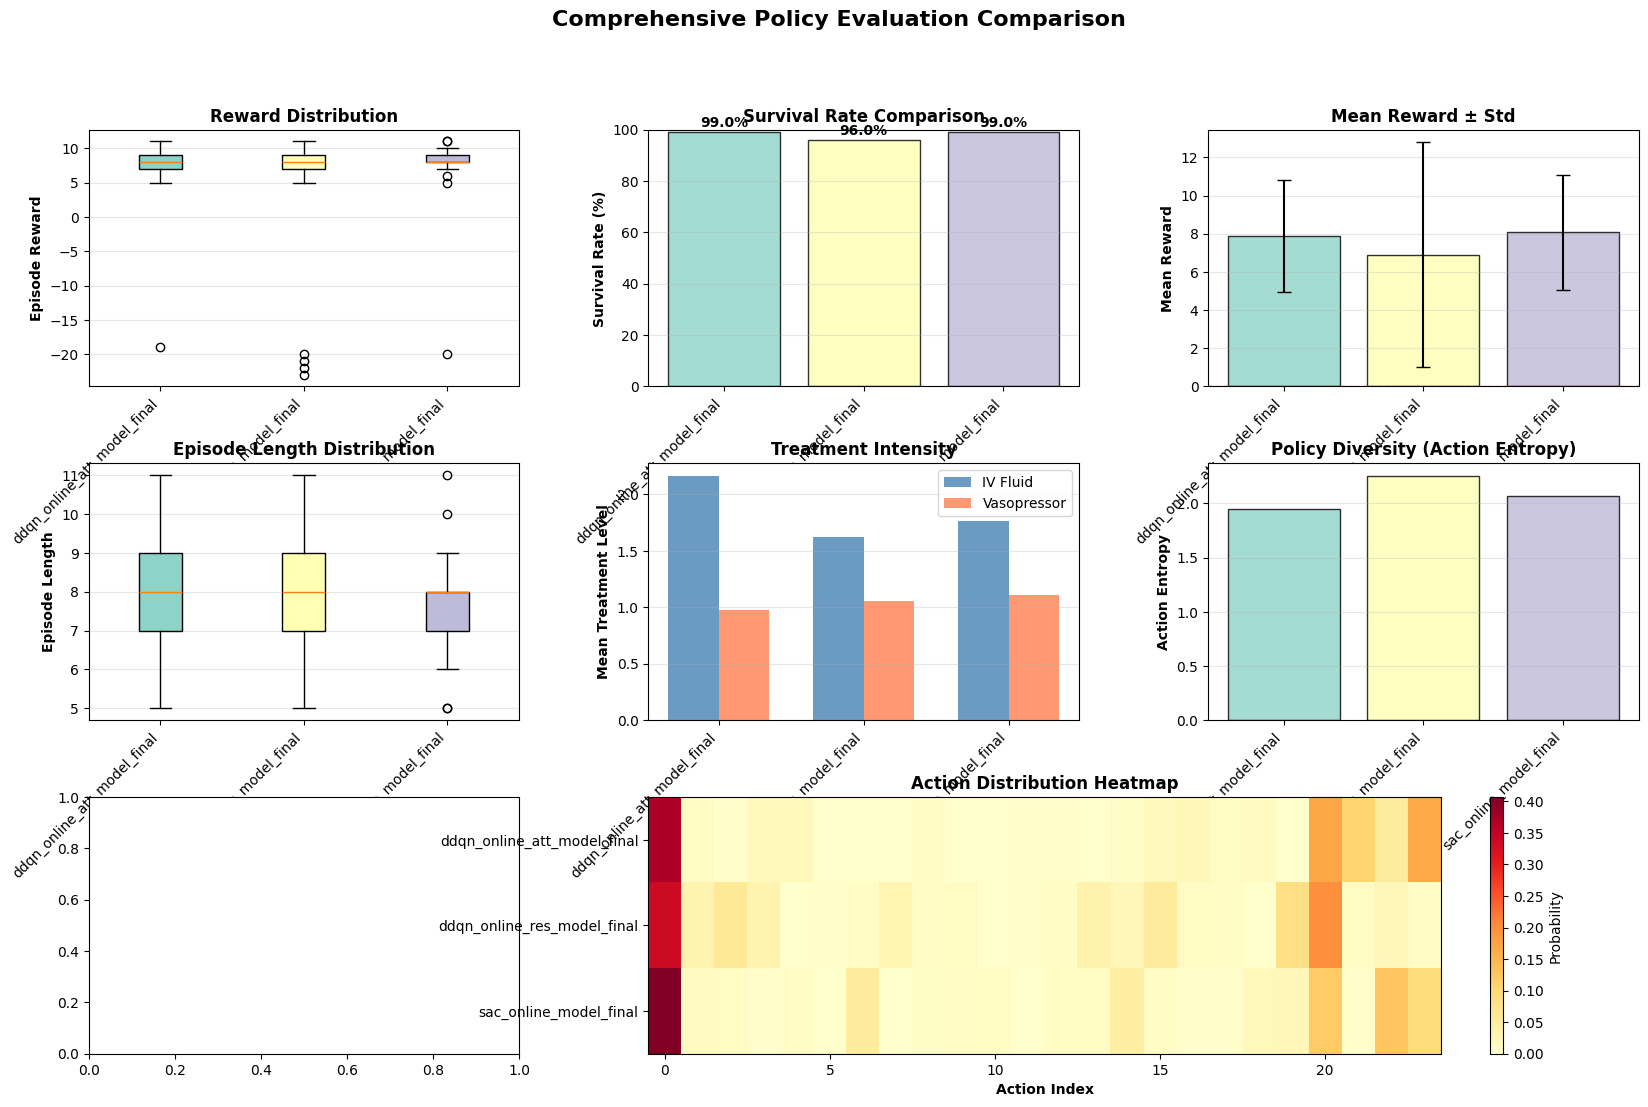


STATISTICAL COMPARISON TABLE

Metric                         | ddqn_online_att_model_final | ddqn_online_res_model_final | sac_online_model_final
----------------------------------------------------------------------------------------------------
Mean Reward                    | 7.88                 | 6.90                 | 8.08                
Survival Rate (%)              | 99.0                 | 96.0                 | 99.0                
Mean Episode Length            | 7.8                  | 7.9                  | 7.6                 
Mean IV Usage                  | 2.17                 | 1.62                 | 1.77                
Mean VP Usage                  | 0.97                 | 1.05                 | 1.11                
Action Entropy                 | 1.95                 | 2.26                 | 2.06                

✓ Policy evaluation complete!


In [7]:
# STEP 4: Comprehensive Policy Evaluation
print('\n' + '='*80)
print('STEP 4: Evaluating Policies with Comprehensive Metrics')
print('='*80)

import gym_sepsis
import gym

class PolicyEvaluator:
    """Comprehensive policy evaluation for sepsis treatment."""
    
    def __init__(self, env_name='sepsis-v0'):
        self.env_name = env_name
    
    def evaluate_policy(self, model, n_episodes=100, verbose=False):
        """
        Evaluate a policy with comprehensive metrics.
        
        Args:
            model: Trained RL model
            n_episodes: Number of episodes to evaluate
            verbose: Print progress
            
        Returns:
            Dictionary of evaluation metrics
        """
        env = gym.make(self.env_name)
        
        # Metrics storage
        episode_rewards = []
        episode_lengths = []
        survival_outcomes = []  # 1 for survival, 0 for death
        action_counts = np.zeros(24)  # 24 actions (5x5 grid - 1)
        iv_usage = []  # Track IV fluid usage
        vp_usage = []  # Track vasopressor usage
        
        # State tracking
        initial_sofa_scores = []
        final_sofa_scores = []
        sofa_improvements = []
        
        for episode in range(n_episodes):
            state = env.reset()
            done = False
            episode_reward = 0
            episode_length = 0
            episode_actions = []
            
            # Track initial SOFA score (assuming it's at index 37)
            initial_sofa = state[37] if len(state) > 37 else None
            
            while not done:
                # Get action from model (handle any state structure)
                def flatten_state(s):
                    """Recursively flatten state handling any nested structure"""
                    if isinstance(s, dict):
                        # Flatten dictionary values in sorted key order
                        flattened = []
                        for k in sorted(s.keys()):
                            flattened.append(flatten_state(s[k]))
                        return np.concatenate(flattened) if flattened else np.array([], dtype=np.float32)
                    elif isinstance(s, (list, tuple)):
                        # Flatten list/tuple elements
                        flattened = [flatten_state(item) for item in s]
                        return np.concatenate(flattened) if flattened else np.array([], dtype=np.float32)
                    elif isinstance(s, np.ndarray):
                        # Flatten numpy array
                        return s.flatten().astype(np.float32)
                    elif isinstance(s, (int, float, np.integer, np.floating)):
                        # Convert numeric scalar to array
                        return np.array([float(s)], dtype=np.float32)
                    else:
                        # Try to convert to float, skip if not possible
                        try:
                            return np.array([float(s)], dtype=np.float32)
                        except (TypeError, ValueError):
                            # Skip non-numeric values
                            return np.array([], dtype=np.float32)
                state_flat = flatten_state(state).reshape(1, -1)
                action = model.predict(state_flat)[0]
                episode_actions.append(action)
                action_counts[action] += 1
                
                # Decode action to IV and VP bins
                iv_bin = action // 5
                vp_bin = action % 5
                
                # Execute action
                # Execute action (handle both old and new Gym API)
                step_result = env.step(action)
                if len(step_result) == 5:
                    # New Gym API (v0.26+): obs, reward, terminated, truncated, info
                    next_state, reward, terminated, truncated, info = step_result
                    done = terminated or truncated
                else:
                    # Old Gym API: obs, reward, done, info
                    next_state, reward, done, info = step_result
                episode_reward += reward
                episode_length += 1
                
                state = next_state
            
            # Track final SOFA score
            final_sofa = state[37] if len(state) > 37 else None
            
            # Record episode metrics
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            
            # Survival: in sepsis env, typically reward > 0 means survival
            survival = 1 if episode_reward > 0 else 0
            survival_outcomes.append(survival)
            
            # Calculate action statistics for this episode
            episode_iv = np.mean([a // 5 for a in episode_actions])
            episode_vp = np.mean([a % 5 for a in episode_actions])
            iv_usage.append(episode_iv)
            vp_usage.append(episode_vp)
            
            # SOFA score tracking
            if initial_sofa is not None and final_sofa is not None:
                initial_sofa_scores.append(initial_sofa)
                final_sofa_scores.append(final_sofa)
                sofa_improvements.append(initial_sofa - final_sofa)
            
            if verbose and (episode + 1) % 20 == 0:
                print(f"  Episode {episode + 1}/{n_episodes} completed")
        
        env.close()
        
        # Compute comprehensive metrics
        metrics = {
            # Reward metrics
            'mean_reward': np.mean(episode_rewards),
            'std_reward': np.std(episode_rewards),
            'median_reward': np.median(episode_rewards),
            'min_reward': np.min(episode_rewards),
            'max_reward': np.max(episode_rewards),
            
            # Episode length metrics
            'mean_episode_length': np.mean(episode_lengths),
            'std_episode_length': np.std(episode_lengths),
            'median_episode_length': np.median(episode_lengths),
            
            # Clinical outcome metrics
            'survival_rate': np.mean(survival_outcomes) * 100,  # Percentage
            'mortality_rate': (1 - np.mean(survival_outcomes)) * 100,
            
            # Treatment intensity metrics
            'mean_iv_usage': np.mean(iv_usage),
            'std_iv_usage': np.std(iv_usage),
            'mean_vp_usage': np.mean(vp_usage),
            'std_vp_usage': np.std(vp_usage),
            
            # SOFA score metrics (disease severity)
            'mean_initial_sofa': np.mean(initial_sofa_scores) if initial_sofa_scores else None,
            'mean_final_sofa': np.mean(final_sofa_scores) if final_sofa_scores else None,
            'mean_sofa_improvement': np.mean(sofa_improvements) if sofa_improvements else None,
            
            # Action distribution
            'action_distribution': action_counts / action_counts.sum(),
            'most_common_action': int(np.argmax(action_counts)),
            'action_entropy': -np.sum((action_counts / action_counts.sum()) * 
                                     np.log(action_counts / action_counts.sum() + 1e-10)),
            
            # Raw data for further analysis
            'episode_rewards': episode_rewards,
            'episode_lengths': episode_lengths,
            'survival_outcomes': survival_outcomes,
        }
        
        return metrics
    
    def compare_policies(self, models_dict, n_episodes=100):
        """
        Compare multiple policies.
        
        Args:
            models_dict: Dictionary of {model_name: model}
            n_episodes: Number of episodes per model
            
        Returns:
            Dictionary of {model_name: metrics}
        """
        all_metrics = {}
        
        print(f"\nEvaluating {len(models_dict)} policies over {n_episodes} episodes each...\n")
        
        for model_name, model in models_dict.items():
            print(f"{'='*80}")
            print(f"Evaluating: {model_name}")
            print('='*80)
            
            metrics = self.evaluate_policy(model, n_episodes=n_episodes, verbose=True)
            all_metrics[model_name] = metrics
            
            # Print summary
            print(f"\n📊 Results for {model_name}:")
            print(f"  Mean Reward: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
            print(f"  Survival Rate: {metrics['survival_rate']:.1f}%")
            print(f"  Mean Episode Length: {metrics['mean_episode_length']:.1f}")
            print(f"  Mean IV Usage: {metrics['mean_iv_usage']:.2f}")
            print(f"  Mean VP Usage: {metrics['mean_vp_usage']:.2f}")
            if metrics['mean_sofa_improvement'] is not None:
                print(f"  Mean SOFA Improvement: {metrics['mean_sofa_improvement']:.2f}")
            print(f"  Action Entropy: {metrics['action_entropy']:.2f}")
            print()
        
        return all_metrics
    
    def plot_comparison(self, all_metrics, save_path=None):
        """Create comprehensive comparison visualizations."""
        # Safety check
        if not all_metrics:
            print("⚠️  No evaluation data to plot.")
            return
        
        # Safety check
        if not all_metrics:
            print("⚠️  No evaluation data to plot.")
            return
        
        model_names = list(all_metrics.keys())
        n_models = len(model_names)
        
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Reward Distribution
        ax1 = fig.add_subplot(gs[0, 0])
        rewards_data = [all_metrics[name]['episode_rewards'] for name in model_names]
        bp = ax1.boxplot(rewards_data, labels=model_names, patch_artist=True)
        for patch, color in zip(bp['boxes'], plt.cm.Set3(range(n_models))):
            patch.set_facecolor(color)
        ax1.set_ylabel('Episode Reward', fontweight='bold')
        ax1.set_title('Reward Distribution', fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # 2. Survival Rate Comparison
        ax2 = fig.add_subplot(gs[0, 1])
        survival_rates = [all_metrics[name]['survival_rate'] for name in model_names]
        colors = plt.cm.Set3(range(n_models))
        bars = ax2.bar(range(n_models), survival_rates, color=colors, alpha=0.8, edgecolor='black')
        ax2.set_ylabel('Survival Rate (%)', fontweight='bold')
        ax2.set_title('Survival Rate Comparison', fontweight='bold')
        ax2.set_xticks(range(n_models))
        ax2.set_xticklabels(model_names, rotation=45, ha='right')
        ax2.set_ylim([0, 100])
        ax2.grid(axis='y', alpha=0.3)
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, survival_rates)):
            ax2.text(i, val + 2, f'{val:.1f}%', ha='center', fontweight='bold')
        
        # 3. Mean Reward with Error Bars
        ax3 = fig.add_subplot(gs[0, 2])
        means = [all_metrics[name]['mean_reward'] for name in model_names]
        stds = [all_metrics[name]['std_reward'] for name in model_names]
        ax3.bar(range(n_models), means, yerr=stds, color=colors, alpha=0.8, 
                edgecolor='black', capsize=5)
        ax3.set_ylabel('Mean Reward', fontweight='bold')
        ax3.set_title('Mean Reward ± Std', fontweight='bold')
        ax3.set_xticks(range(n_models))
        ax3.set_xticklabels(model_names, rotation=45, ha='right')
        ax3.grid(axis='y', alpha=0.3)
        ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        
        # 4. Episode Length Distribution
        ax4 = fig.add_subplot(gs[1, 0])
        length_data = [all_metrics[name]['episode_lengths'] for name in model_names]
        bp2 = ax4.boxplot(length_data, labels=model_names, patch_artist=True)
        for patch, color in zip(bp2['boxes'], plt.cm.Set3(range(n_models))):
            patch.set_facecolor(color)
        ax4.set_ylabel('Episode Length', fontweight='bold')
        ax4.set_title('Episode Length Distribution', fontweight='bold')
        ax4.grid(axis='y', alpha=0.3)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # 5. Treatment Intensity (IV vs VP)
        ax5 = fig.add_subplot(gs[1, 1])
        x = np.arange(n_models)
        width = 0.35
        iv_means = [all_metrics[name]['mean_iv_usage'] for name in model_names]
        vp_means = [all_metrics[name]['mean_vp_usage'] for name in model_names]
        ax5.bar(x - width/2, iv_means, width, label='IV Fluid', color='steelblue', alpha=0.8)
        ax5.bar(x + width/2, vp_means, width, label='Vasopressor', color='coral', alpha=0.8)
        ax5.set_ylabel('Mean Treatment Level', fontweight='bold')
        ax5.set_title('Treatment Intensity', fontweight='bold')
        ax5.set_xticks(x)
        ax5.set_xticklabels(model_names, rotation=45, ha='right')
        ax5.legend()
        ax5.grid(axis='y', alpha=0.3)
        
        # 6. Action Entropy
        ax6 = fig.add_subplot(gs[1, 2])
        entropies = [all_metrics[name]['action_entropy'] for name in model_names]
        ax6.bar(range(n_models), entropies, color=colors, alpha=0.8, edgecolor='black')
        ax6.set_ylabel('Action Entropy', fontweight='bold')
        ax6.set_title('Policy Diversity (Action Entropy)', fontweight='bold')
        ax6.set_xticks(range(n_models))
        ax6.set_xticklabels(model_names, rotation=45, ha='right')
        ax6.grid(axis='y', alpha=0.3)
        
        # 7. SOFA Score Improvement
        ax7 = fig.add_subplot(gs[2, 0])
        sofa_improvements = [all_metrics[name]['mean_sofa_improvement'] 
                            for name in model_names 
                            if all_metrics[name]['mean_sofa_improvement'] is not None]
        if sofa_improvements:
            ax7.bar(range(len(sofa_improvements)), sofa_improvements, 
                   color=colors[:len(sofa_improvements)], alpha=0.8, edgecolor='black')
            ax7.set_ylabel('SOFA Score Improvement', fontweight='bold')
            ax7.set_title('Disease Severity Improvement', fontweight='bold')
            ax7.set_xticks(range(len(sofa_improvements)))
            ax7.set_xticklabels(model_names[:len(sofa_improvements)], rotation=45, ha='right')
            ax7.axhline(y=0, color='red', linestyle='--', linewidth=1)
            ax7.grid(axis='y', alpha=0.3)
        
        # 8. Action Distribution Heatmap
        ax8 = fig.add_subplot(gs[2, 1:])
        action_data = np.array([all_metrics[name]['action_distribution'] 
                               for name in model_names])
        im = ax8.imshow(action_data, aspect='auto', cmap='YlOrRd')
        ax8.set_yticks(range(n_models))
        ax8.set_yticklabels(model_names)
        ax8.set_xlabel('Action Index', fontweight='bold')
        ax8.set_title('Action Distribution Heatmap', fontweight='bold')
        plt.colorbar(im, ax=ax8, label='Probability')
        
        # Super title
        fig.suptitle('Comprehensive Policy Evaluation Comparison', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Saved comparison plot to {save_path}')
        
        plt.show()
    
    def print_statistical_comparison(self, all_metrics):
        """Print statistical comparison table."""
        from scipy import stats
        
        # Safety check
        if not all_metrics:
            print("⚠️  No evaluation data for statistical comparison.")
            return
        
        model_names = list(all_metrics.keys())
        
        print('\n' + '='*80)
        print('STATISTICAL COMPARISON TABLE')
        print('='*80)
        
        print(f"\n{'Metric':<30} | " + " | ".join([f"{name:<20}" for name in model_names]))
        print('-'*100)
        
        metrics_to_compare = [
            ('Mean Reward', 'mean_reward', '.2f'),
            ('Survival Rate (%)', 'survival_rate', '.1f'),
            ('Mean Episode Length', 'mean_episode_length', '.1f'),
            ('Mean IV Usage', 'mean_iv_usage', '.2f'),
            ('Mean VP Usage', 'mean_vp_usage', '.2f'),
            ('Action Entropy', 'action_entropy', '.2f'),
        ]
        
        for metric_name, metric_key, fmt in metrics_to_compare:
            values = [all_metrics[name][metric_key] for name in model_names]
            value_str = " | ".join([f"{val:{fmt}}".ljust(20) for val in values])
            print(f"{metric_name:<30} | {value_str}")
        
        # Statistical significance tests
        if len(model_names) == 2:
            print('\n' + '='*80)
            print('STATISTICAL SIGNIFICANCE (T-Test)')
            print('='*80)
            
            rewards_1 = all_metrics[model_names[0]]['episode_rewards']
            rewards_2 = all_metrics[model_names[1]]['episode_rewards']
            
            t_stat, p_value = stats.ttest_ind(rewards_1, rewards_2)
            
            print(f"\nReward Comparison: {model_names[0]} vs {model_names[1]}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            if p_value < 0.05:
                winner = model_names[0] if np.mean(rewards_1) > np.mean(rewards_2) else model_names[1]
                print(f"  ✓ Significant difference (p < 0.05): {winner} performs better")
            else:
                print(f"  ✗ No significant difference (p >= 0.05)")
        
        print('='*80)

# Initialize evaluator
evaluator = PolicyEvaluator()

# Evaluate all loaded models
print(f"\n🎯 Evaluating {len(models)} model(s)...")
try:
    all_evaluation_metrics = evaluator.compare_policies(models, n_episodes=100)
except Exception as e:
    print(f"\n❌ ERROR during evaluation: {e}")
    print(f"   Error type: {type(e).__name__}")
    print("\n⚠️  IMPORTANT: Please restart the Jupyter kernel to load the updated code!")
    print("   (Kernel → Restart Kernel, then re-run cells from the beginning)")
    import traceback
    traceback.print_exc()
    # Create empty metrics to prevent downstream errors
    all_evaluation_metrics = {}

# Create comparison visualizations
print("\n📊 Creating comparison visualizations...")
evaluator.plot_comparison(all_evaluation_metrics, 
                         save_path='./sepsis_leg_analysis/policy_comparison.png')

# Print statistical comparison
evaluator.print_statistical_comparison(all_evaluation_metrics)

print("\n✓ Policy evaluation complete!")


# Part 3: Policy Interpretability (LEG Analysis)

## 🔍 Understanding Policy Decisions

Now that we've evaluated **which policy performs better**, we use **Linearly Estimated Gradients (LEG)** to understand **why** and **how** each policy makes decisions.

### What is LEG Analysis?
LEG analyzes feature importance by perturbing state features and measuring their impact on Q-values. This reveals:
- Which clinical features most influence treatment decisions
- How features affect different treatment actions
- Differences in decision-making between policies

### What We'll Analyze:
1. **Feature Saliency**: Which vital signs/labs matter most for each action
2. **Treatment Patterns**: How policies use IV fluids and vasopressors
3. **Cross-Model Comparison**: Consensus on important features
4. **Visual Explanations**: Heatmaps and detailed plots


In [8]:
# STEP 4B: Enhanced Evaluation with Comprehensive Clinical Metrics
print('\n' + '='*80)
print('STEP 4B: Enhanced Policy Evaluation with Clinical Metrics')
print('='*80)

from scipy import stats

# ============================================================================
# Enhanced Evaluation Functions
# ============================================================================

class ComprehensiveMetrics:
    """Comprehensive evaluation metrics for healthcare RL policies."""
    
    @staticmethod
    def calculate_survival_metrics(rewards: List[float], threshold: float = 0.0) -> Dict:
        """Calculate survival-related metrics."""
        rewards = np.array(rewards)
        survival = (rewards > threshold).astype(int)
        
        return {
            'survival_rate': np.mean(survival) * 100,
            'mortality_rate': (1 - np.mean(survival)) * 100,
            'survival_count': np.sum(survival),
            'mortality_count': len(survival) - np.sum(survival),
            'total_episodes': len(survival)
        }
    
    @staticmethod
    def calculate_reward_metrics(rewards: List[float]) -> Dict:
        """Calculate comprehensive reward statistics."""
        rewards = np.array(rewards)
        
        return {
            'mean': np.mean(rewards),
            'std': np.std(rewards),
            'median': np.median(rewards),
            'q25': np.percentile(rewards, 25),
            'q75': np.percentile(rewards, 75),
            'min': np.min(rewards),
            'max': np.max(rewards),
            'iqr': np.percentile(rewards, 75) - np.percentile(rewards, 25),
            'skewness': stats.skew(rewards),
            'kurtosis': stats.kurtosis(rewards)
        }
    
    @staticmethod
    def bootstrap_confidence_interval(data: np.ndarray, n_bootstrap: int = 10000, 
                                     confidence: float = 0.95) -> Tuple[float, float]:
        """Calculate bootstrap confidence interval."""
        bootstrap_means = []
        n = len(data)
        
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=n, replace=True)
            bootstrap_means.append(np.mean(sample))
        
        alpha = 1 - confidence
        lower = np.percentile(bootstrap_means, alpha/2 * 100)
        upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)
        
        return lower, upper
    
    @staticmethod
    def cohens_d(group1: np.ndarray, group2: np.ndarray) -> float:
        """Calculate Cohen's d effect size."""
        n1, n2 = len(group1), len(group2)
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        
        # Pooled standard deviation
        pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        
        # Cohen's d
        d = (np.mean(group1) - np.mean(group2)) / pooled_std
        
        return d
    
    @staticmethod
    def win_rate_analysis(rewards1: List[float], rewards2: List[float]) -> Dict:
        """Compare two policies using win rate analysis."""
        r1, r2 = np.array(rewards1), np.array(rewards2)
        
        # Paired comparison
        wins = np.sum(r1 > r2)
        losses = np.sum(r1 < r2)
        ties = np.sum(r1 == r2)
        total = len(r1)
        
        return {
            'policy1_wins': wins,
            'policy2_wins': losses,
            'ties': ties,
            'policy1_win_rate': wins / total * 100,
            'policy2_win_rate': losses / total * 100,
            'tie_rate': ties / total * 100
        }


def statistical_comparison_test(metrics1: Dict, metrics2: Dict, 
                               metric_name: str = 'episode_rewards') -> Dict:
    """Perform comprehensive statistical comparison between two policies."""
    data1 = np.array(metrics1[metric_name])
    data2 = np.array(metrics2[metric_name])
    
    # T-test
    t_stat, p_value_ttest = stats.ttest_ind(data1, data2)
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_value_mann = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    
    # Effect size (Cohen's d)
    effect_size = ComprehensiveMetrics.cohens_d(data1, data2)
    
    # Bootstrap confidence intervals
    ci1 = ComprehensiveMetrics.bootstrap_confidence_interval(data1)
    ci2 = ComprehensiveMetrics.bootstrap_confidence_interval(data2)
    
    # Determine practical significance
    if abs(effect_size) < 0.2:
        effect_interpretation = "negligible"
    elif abs(effect_size) < 0.5:
        effect_interpretation = "small"
    elif abs(effect_size) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    return {
        't_statistic': t_stat,
        'p_value_ttest': p_value_ttest,
        'u_statistic': u_stat,
        'p_value_mann_whitney': p_value_mann,
        'cohens_d': effect_size,
        'effect_interpretation': effect_interpretation,
        'policy1_ci': ci1,
        'policy2_ci': ci2,
        'statistically_significant': p_value_ttest < 0.05,
        'practically_significant': abs(effect_size) >= 0.5
    }


def create_comparison_report(all_metrics: Dict, model_names: List[str]) -> pd.DataFrame:
    """Create a comprehensive comparison report as a DataFrame."""
    report_data = []
    
    for model_name in model_names:
        metrics = all_metrics[model_name]
        
        row = {
            'Model': model_name,
            'Mean Reward': f"{metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}",
            'Survival Rate': f"{metrics['survival_rate']:.1f}%",
            'Episode Length': f"{metrics['mean_episode_length']:.1f}",
            'IV Usage': f"{metrics['mean_iv_usage']:.2f}",
            'VP Usage': f"{metrics['mean_vp_usage']:.2f}",
            'Action Entropy': f"{metrics['action_entropy']:.2f}",
        }
        
        if metrics['mean_sofa_improvement'] is not None:
            row['SOFA Improvement'] = f"{metrics['mean_sofa_improvement']:.2f}"
        
        report_data.append(row)
    
    return pd.DataFrame(report_data)


def plot_detailed_comparison(all_metrics: Dict, save_dir: str = './sepsis_leg_analysis'):
    """Create detailed comparison plots with statistical annotations."""
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    model_names = list(all_metrics.keys())
    
    if len(model_names) == 2:
        # Detailed pairwise comparison
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Detailed Pairwise Policy Comparison', fontsize=16, fontweight='bold')
        
        # Get data
        rewards1 = all_metrics[model_names[0]]['episode_rewards']
        rewards2 = all_metrics[model_names[1]]['episode_rewards']
        
        # 1. Reward distributions (violin plot)
        ax = axes[0, 0]
        parts = ax.violinplot([rewards1, rewards2], positions=[1, 2], 
                              showmeans=True, showmedians=True)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylabel('Episode Reward')
        ax.set_title('Reward Distribution')
        ax.grid(axis='y', alpha=0.3)
        
        # 2. Cumulative distribution
        ax = axes[0, 1]
        sorted1 = np.sort(rewards1)
        sorted2 = np.sort(rewards2)
        cdf1 = np.arange(1, len(sorted1)+1) / len(sorted1)
        cdf2 = np.arange(1, len(sorted2)+1) / len(sorted2)
        ax.plot(sorted1, cdf1, label=model_names[0], linewidth=2)
        ax.plot(sorted2, cdf2, label=model_names[1], linewidth=2)
        ax.set_xlabel('Episode Reward')
        ax.set_ylabel('Cumulative Probability')
        ax.set_title('Cumulative Distribution')
        ax.legend()
        ax.grid(alpha=0.3)
        
        # 3. Difference histogram
        ax = axes[0, 2]
        differences = np.array(rewards1) - np.array(rewards2)
        ax.hist(differences, bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax.axvline(x=np.mean(differences), color='blue', linestyle='--', linewidth=2, 
                  label=f'Mean Diff: {np.mean(differences):.2f}')
        ax.set_xlabel(f'{model_names[0]} - {model_names[1]} Reward')
        ax.set_ylabel('Frequency')
        ax.set_title('Pairwise Difference Distribution')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # 4. Statistical test results
        ax = axes[1, 0]
        ax.axis('off')
        test_results = statistical_comparison_test(
            all_metrics[model_names[0]], 
            all_metrics[model_names[1]]
        )
        
        text_str = f"Statistical Tests:\n\n"
        text_str += f"T-test p-value: {test_results['p_value_ttest']:.4f}\n"
        text_str += f"Mann-Whitney p: {test_results['p_value_mann_whitney']:.4f}\n\n"
        text_str += f"Effect Size (Cohen's d): {test_results['cohens_d']:.3f}\n"
        text_str += f"Interpretation: {test_results['effect_interpretation']}\n\n"
        text_str += f"Statistically Sig: {'Yes' if test_results['statistically_significant'] else 'No'}\n"
        text_str += f"Practically Sig: {'Yes' if test_results['practically_significant'] else 'No'}\n"
        
        ax.text(0.1, 0.9, text_str, transform=ax.transAxes, 
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        ax.set_title('Statistical Comparison', fontweight='bold')
        
        # 5. Win rate analysis
        ax = axes[1, 1]
        win_rates = ComprehensiveMetrics.win_rate_analysis(rewards1, rewards2)
        categories = [model_names[0], 'Ties', model_names[1]]
        values = [win_rates['policy1_win_rate'], win_rates['tie_rate'], 
                 win_rates['policy2_win_rate']]
        colors = ['steelblue', 'gray', 'coral']
        bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black')
        ax.set_ylabel('Win Rate (%)')
        ax.set_title('Win Rate Analysis')
        ax.set_ylim([0, 100])
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, val + 2, 
                   f'{val:.1f}%', ha='center', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # 6. Confidence intervals
        ax = axes[1, 2]
        ci1 = test_results['policy1_ci']
        ci2 = test_results['policy2_ci']
        means = [np.mean(rewards1), np.mean(rewards2)]
        
        ax.errorbar([1, 2], means, 
                   yerr=[[means[0] - ci1[0], means[1] - ci2[0]], 
                         [ci1[1] - means[0], ci2[1] - means[1]]], 
                   fmt='o', markersize=10, capsize=10, capthick=2, linewidth=2)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylabel('Mean Reward')
        ax.set_title('95% Bootstrap Confidence Intervals')
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/detailed_pairwise_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Detailed comparison plot saved to {save_dir}/detailed_pairwise_comparison.png")


# ============================================================================
# Enhanced Evaluation Analysis
# ============================================================================

print("\n🔬 Calculating comprehensive clinical metrics...")

enhanced_metrics = {}


# Debug: Show what keys are available
print(f"\nDEBUG: Models loaded: {list(models.keys())}")
print(f"DEBUG: Evaluations completed: {list(all_evaluation_metrics.keys())}")

# Safety check: Only analyze models that were successfully evaluated
for model_name in all_evaluation_metrics.keys():
    print(f"\nAnalyzing {model_name}...")
    base_metrics = all_evaluation_metrics[model_name]
    
    # Calculate enhanced metrics
    rewards = base_metrics['episode_rewards']
    
    # Survival metrics
    survival_metrics = ComprehensiveMetrics.calculate_survival_metrics(rewards)
    
    # Detailed reward statistics
    reward_stats = ComprehensiveMetrics.calculate_reward_metrics(rewards)
    
    # Bootstrap confidence intervals
    ci_lower, ci_upper = ComprehensiveMetrics.bootstrap_confidence_interval(
        np.array(rewards), n_bootstrap=10000
    )
    
    # Store enhanced metrics
    enhanced_metrics[model_name] = {
        **base_metrics,
        'survival_metrics': survival_metrics,
        'reward_statistics': reward_stats,
        'confidence_interval_95': (ci_lower, ci_upper)
    }
    
    # Print summary
    print(f"  ✓ Survival Rate: {survival_metrics['survival_rate']:.1f}% "
          f"({survival_metrics['survival_count']}/{survival_metrics['total_episodes']})")
    print(f"  ✓ Reward: {reward_stats['mean']:.2f} ± {reward_stats['std']:.2f}")
    print(f"  ✓ 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  ✓ Median (IQR): {reward_stats['median']:.2f} ({reward_stats['iqr']:.2f})")

# Create comprehensive comparison report
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON REPORT")
print("="*80)

model_names = list(models.keys())
report_df = create_comparison_report(all_evaluation_metrics, model_names)

print("\n")
print(report_df.to_string(index=False))
print()

# Statistical comparison if we have 2 models
if len(model_names) == 2:
    print("="*80)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*80)
    
    test_results = statistical_comparison_test(
        all_evaluation_metrics[model_names[0]],
        all_evaluation_metrics[model_names[1]],
        metric_name='episode_rewards'
    )
    
    print(f"\n📊 Comparing: {model_names[0]} vs {model_names[1]}")
    print(f"\n1. Parametric Test (Student's t-test):")
    print(f"   t-statistic: {test_results['t_statistic']:.4f}")
    print(f"   p-value: {test_results['p_value_ttest']:.4f}")
    print(f"   Significant: {'✓ YES' if test_results['statistically_significant'] else '✗ NO'} (α=0.05)")
    
    print(f"\n2. Non-parametric Test (Mann-Whitney U):")
    print(f"   U-statistic: {test_results['u_statistic']:.4f}")
    print(f"   p-value: {test_results['p_value_mann_whitney']:.4f}")
    
    print(f"\n3. Effect Size:")
    print(f"   Cohen's d: {test_results['cohens_d']:.3f}")
    print(f"   Interpretation: {test_results['effect_interpretation'].upper()}")
    print(f"   Practically significant: {'✓ YES' if test_results['practically_significant'] else '✗ NO'} (|d| ≥ 0.5)")
    
    print(f"\n4. Confidence Intervals (95%, Bootstrap):")
    print(f"   {model_names[0]}: [{test_results['policy1_ci'][0]:.2f}, {test_results['policy1_ci'][1]:.2f}]")
    print(f"   {model_names[1]}: [{test_results['policy2_ci'][0]:.2f}, {test_results['policy2_ci'][1]:.2f}]")
    
    # Win rate analysis
    win_rates = ComprehensiveMetrics.win_rate_analysis(
        all_evaluation_metrics[model_names[0]]['episode_rewards'],
        all_evaluation_metrics[model_names[1]]['episode_rewards']
    )
    
    print(f"\n5. Win Rate Analysis (Episode-by-Episode):")
    print(f"   {model_names[0]} wins: {win_rates['policy1_wins']} ({win_rates['policy1_win_rate']:.1f}%)")
    print(f"   {model_names[1]} wins: {win_rates['policy2_wins']} ({win_rates['policy2_win_rate']:.1f}%)")
    print(f"   Ties: {win_rates['ties']} ({win_rates['tie_rate']:.1f}%)")
    
    # Determine winner
    print(f"\n{'='*80}")
    print("CONCLUSION")
    print('='*80)
    
    mean1 = all_evaluation_metrics[model_names[0]]['mean_reward']
    mean2 = all_evaluation_metrics[model_names[1]]['mean_reward']
    
    if test_results['statistically_significant']:
        winner = model_names[0] if mean1 > mean2 else model_names[1]
        loser = model_names[1] if mean1 > mean2 else model_names[0]
        improvement = abs(mean1 - mean2)
        print(f"\n✓ {winner} significantly outperforms {loser}")
        print(f"  • Mean reward improvement: {improvement:.2f}")
        print(f"  • Effect size: {test_results['effect_interpretation']}")
        print(f"  • Statistical confidence: p < 0.05")
        
        if test_results['practically_significant']:
            print(f"  • The difference is both statistically AND practically significant")
        else:
            print(f"  • ⚠ The difference is statistically but not practically significant")
    else:
        print(f"\n✗ No statistically significant difference detected")
        print(f"  • Mean reward difference: {abs(mean1 - mean2):.2f}")
        print(f"  • p-value: {test_results['p_value_ttest']:.4f} (≥ 0.05)")
        print(f"  • Both policies perform similarly")
    
    print("\n" + "="*80)
    
    # Create detailed comparison plots
    print("\n📊 Creating detailed comparison visualizations...")
    plot_detailed_comparison(all_evaluation_metrics, save_dir='./sepsis_leg_analysis')

# Summary statistics table
print("\n" + "="*80)
print("DETAILED METRICS SUMMARY")
print("="*80)

for model_name in model_names:
    metrics = enhanced_metrics[model_name]
    reward_stats = metrics['reward_statistics']
    
    print(f"\n📋 {model_name}:")
    print(f"   {'Metric':<25} {'Value':<20}")
    print(f"   {'-'*45}")
    print(f"   {'Mean Reward':<25} {reward_stats['mean']:.2f} ± {reward_stats['std']:.2f}")
    print(f"   {'Median Reward':<25} {reward_stats['median']:.2f}")
    print(f"   {'IQR':<25} {reward_stats['iqr']:.2f}")
    print(f"   {'Range':<25} [{reward_stats['min']:.2f}, {reward_stats['max']:.2f}]")
    print(f"   {'Survival Rate':<25} {metrics['survival_rate']:.1f}%")
    print(f"   {'Episode Length':<25} {metrics['mean_episode_length']:.1f} ± {metrics['std_episode_length']:.1f}")
    print(f"   {'Action Entropy':<25} {metrics['action_entropy']:.2f}")

print("\n✓ Enhanced evaluation complete!")
print("="*80)



STEP 4B: Enhanced Policy Evaluation with Clinical Metrics

🔬 Calculating comprehensive clinical metrics...

DEBUG: Models loaded: ['ddqn_online_att_model_final', 'ddqn_online_res_model_final', 'sac_online_model_final']
DEBUG: Evaluations completed: ['ddqn_online_att_model_final', 'ddqn_online_res_model_final', 'sac_online_model_final']

Analyzing ddqn_online_att_model_final...
  ✓ Survival Rate: 99.0% (99/100)
  ✓ Reward: 7.88 ± 2.93
  ✓ 95% CI: [7.21, 8.32]
  ✓ Median (IQR): 8.00 (2.00)

Analyzing ddqn_online_res_model_final...
  ✓ Survival Rate: 96.0% (96/100)
  ✓ Reward: 6.90 ± 5.91
  ✓ 95% CI: [5.61, 7.91]
  ✓ Median (IQR): 8.00 (2.00)

Analyzing sac_online_model_final...
  ✓ Survival Rate: 99.0% (99/100)
  ✓ Reward: 8.08 ± 3.02
  ✓ 95% CI: [7.40, 8.53]
  ✓ Median (IQR): 8.00 (1.00)

COMPREHENSIVE COMPARISON REPORT


                      Model Mean Reward Survival Rate Episode Length IV Usage VP Usage Action Entropy
ddqn_online_att_model_final 7.88 ± 2.93         99.0%           


STEP 3: LEG Analysis for Multiple Models

Analyzing Model: ddqn_online_att_model_final

Performing LEG Analysis

--- Analyzing State 1/10 (Episode 0, Timestep 4) ---
Analyzing 41 features...
Selected Action: 0 (IV=0, VP=0)
Top 5 Features:
  1. qSOFA: score=5.9999, value=1.71
  2. INR: score=-5.1003, value=-0.54
  3. qSOFA_sysbp: score=4.8629, value=0.69
  4. qSOFA_gcs: score=-4.4599, value=1.71
  5. bilirubin: score=3.1937, value=-0.21


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_0.png


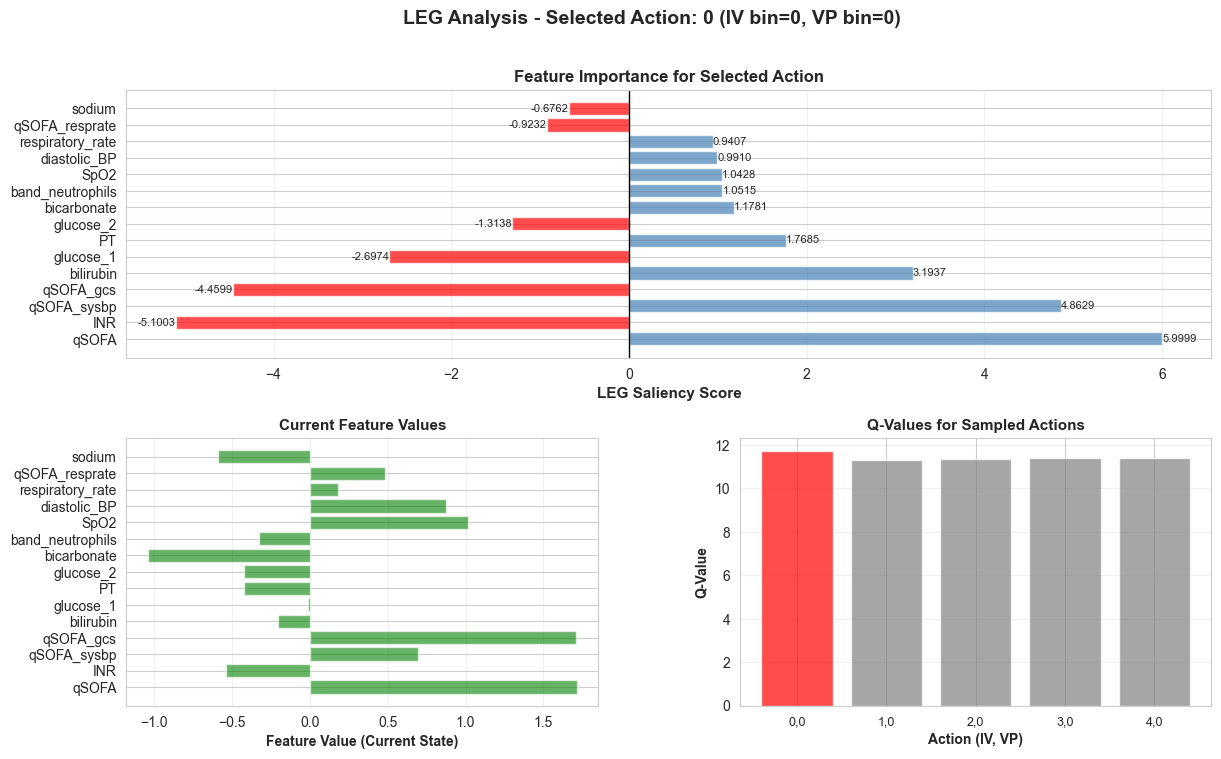

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_0.png


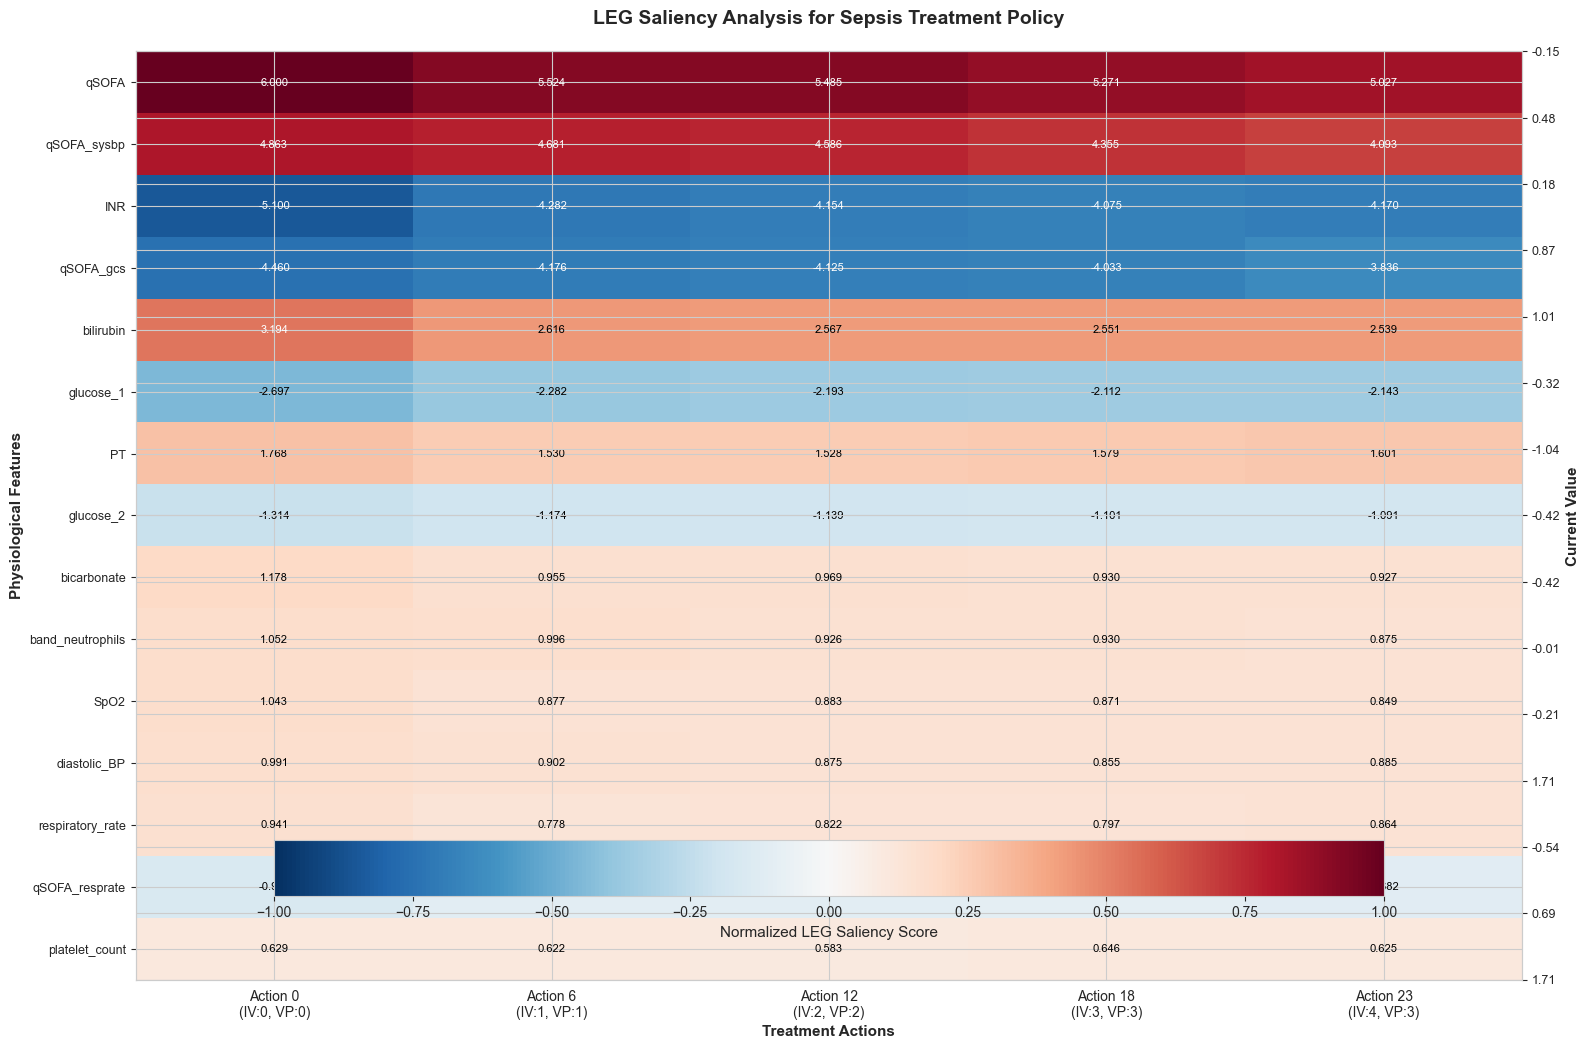


--- Analyzing State 2/10 (Episode 1, Timestep 5) ---
Analyzing 41 features...
Selected Action: 20 (IV=4, VP=0)
Top 5 Features:
  1. INR: score=-4.7441, value=-0.34
  2. qSOFA: score=4.6458, value=0.27
  3. qSOFA_sysbp: score=3.9558, value=0.65
  4. qSOFA_gcs: score=-2.8028, value=-0.55
  5. PT: score=2.7486, value=-0.18


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_1.png


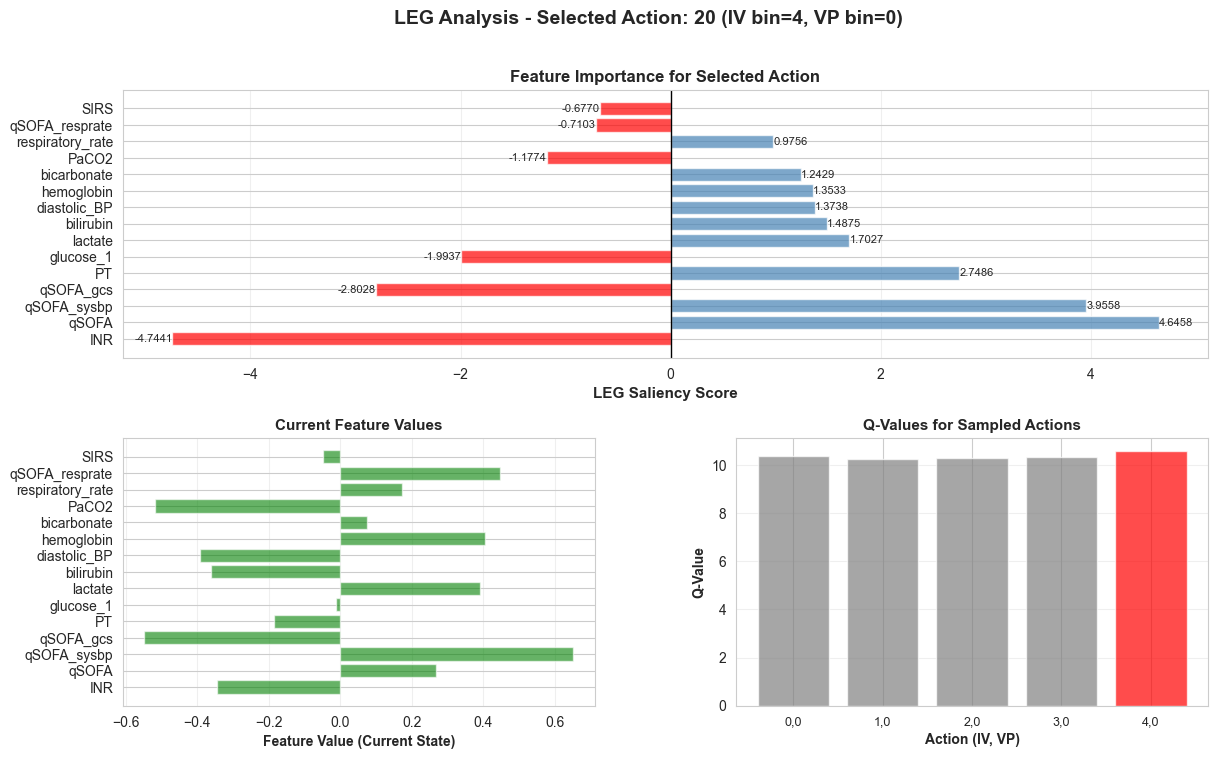

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_1.png


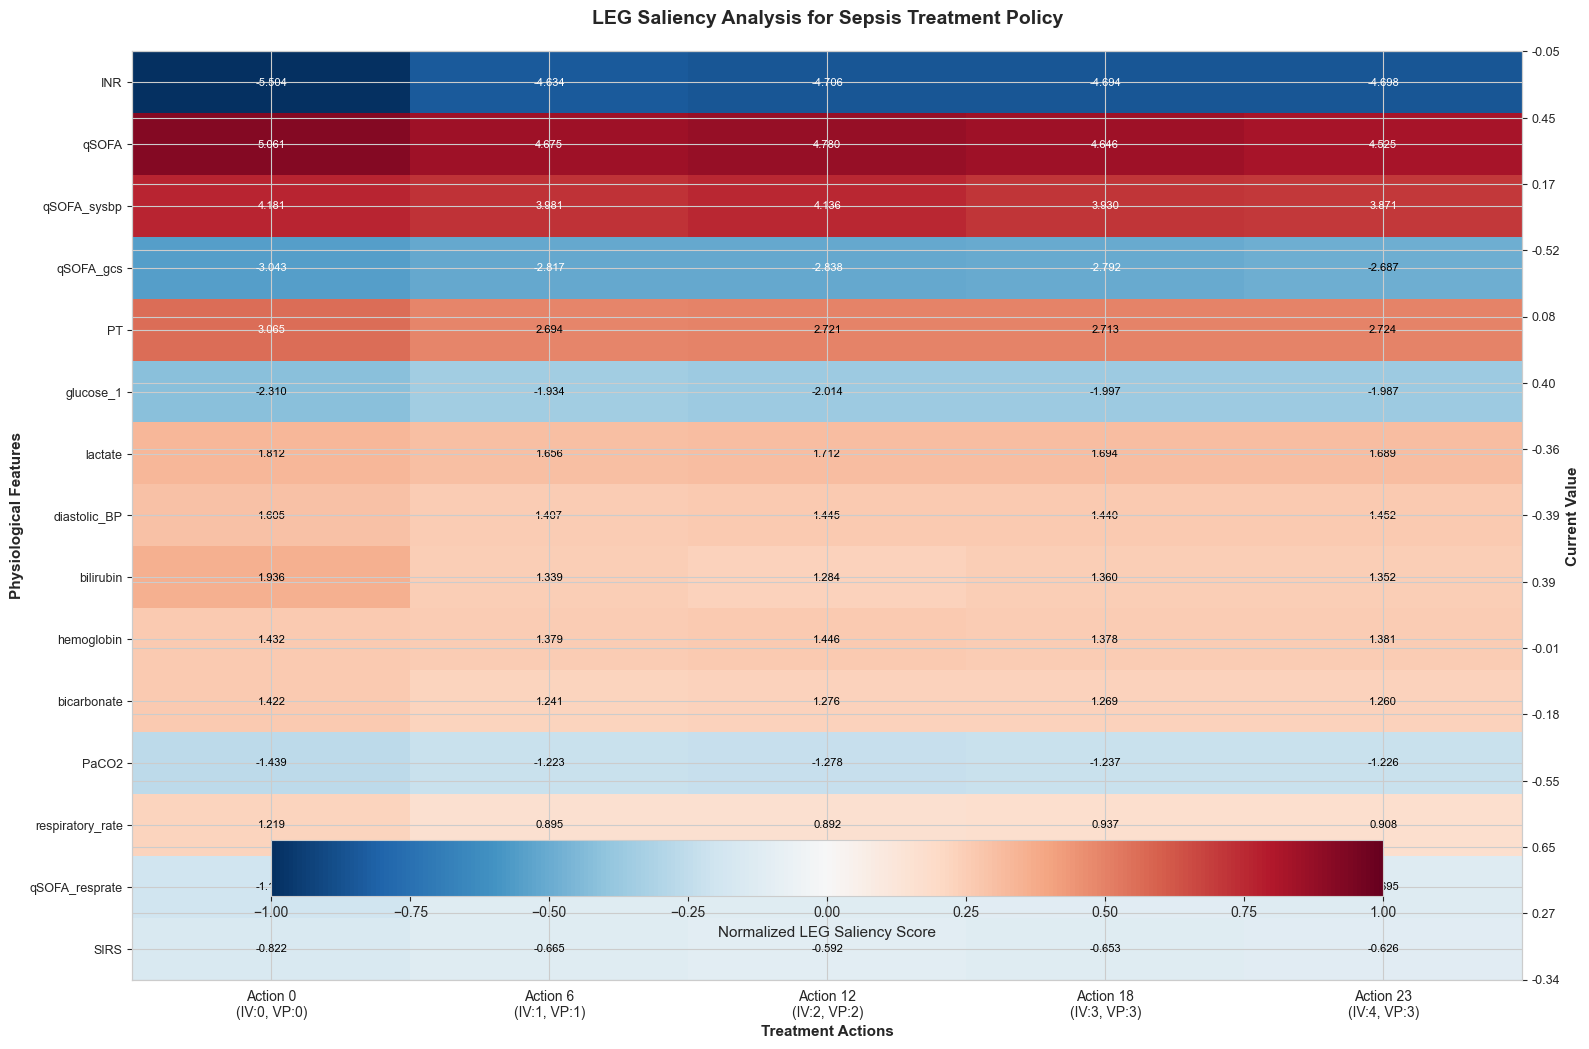


--- Analyzing State 3/10 (Episode 2, Timestep 4) ---
Analyzing 41 features...
Selected Action: 21 (IV=4, VP=1)
Top 5 Features:
  1. qSOFA_sysbp: score=2.2268, value=0.90
  2. qSOFA: score=1.8867, value=-0.65
  3. INR: score=-1.6679, value=0.47
  4. qSOFA_gcs: score=-1.4730, value=-0.76
  5. qSOFA_resprate: score=-1.2637, value=-2.40


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_2.png


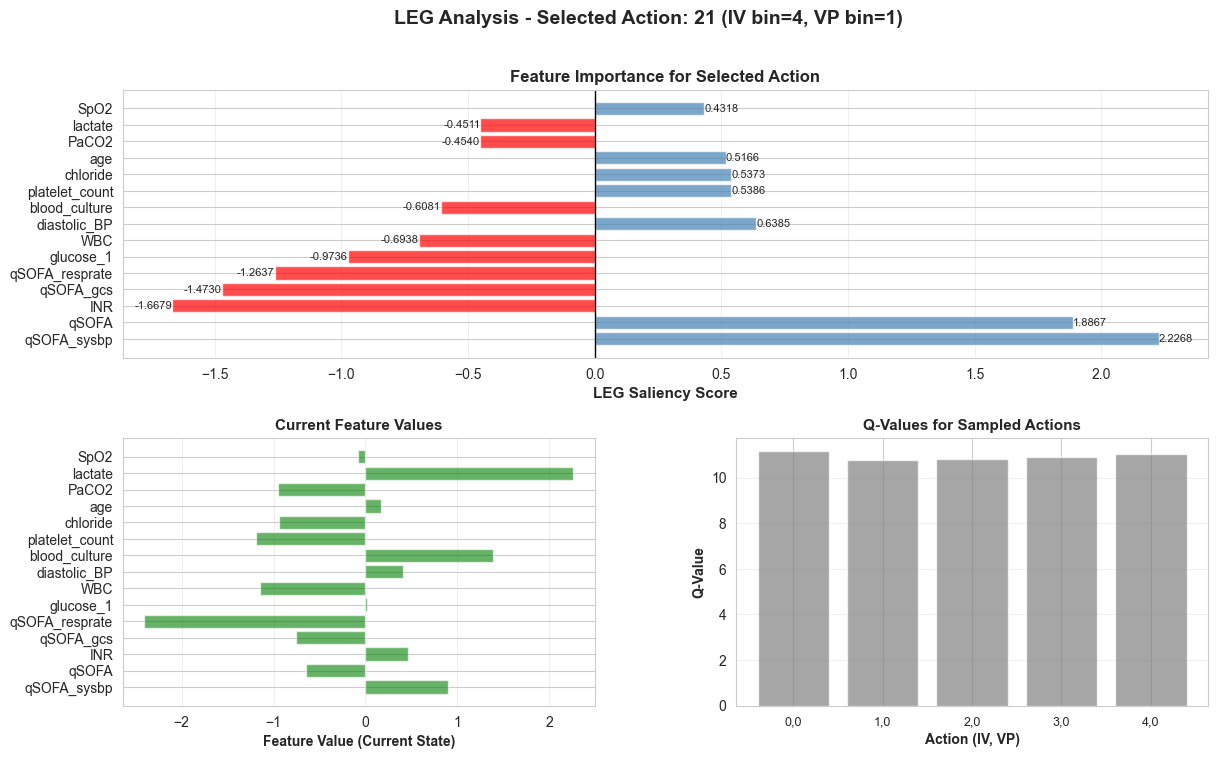

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_2.png


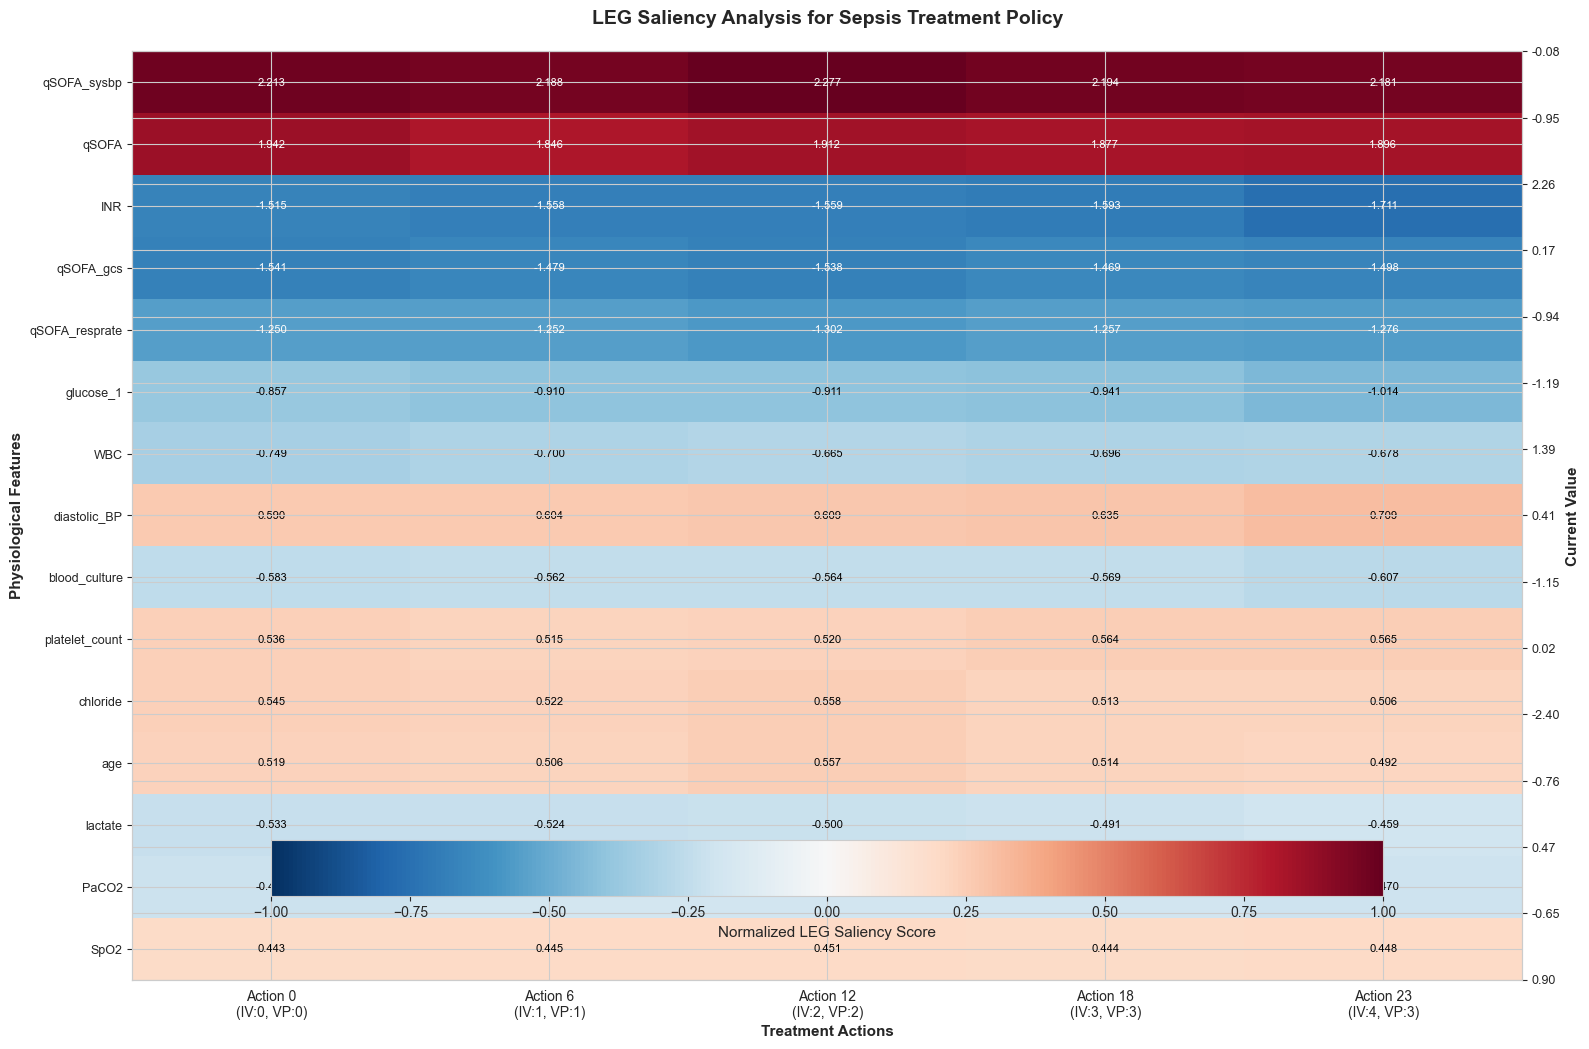


--- Analyzing State 4/10 (Episode 3, Timestep 5) ---
Analyzing 41 features...
Selected Action: 2 (IV=0, VP=2)
Top 5 Features:
  1. qSOFA: score=3.9741, value=0.37
  2. qSOFA_sysbp: score=3.0418, value=0.81
  3. qSOFA_gcs: score=-2.5571, value=-0.78
  4. INR: score=-2.1508, value=0.56
  5. PaCO2: score=-1.1880, value=-0.63


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_3.png


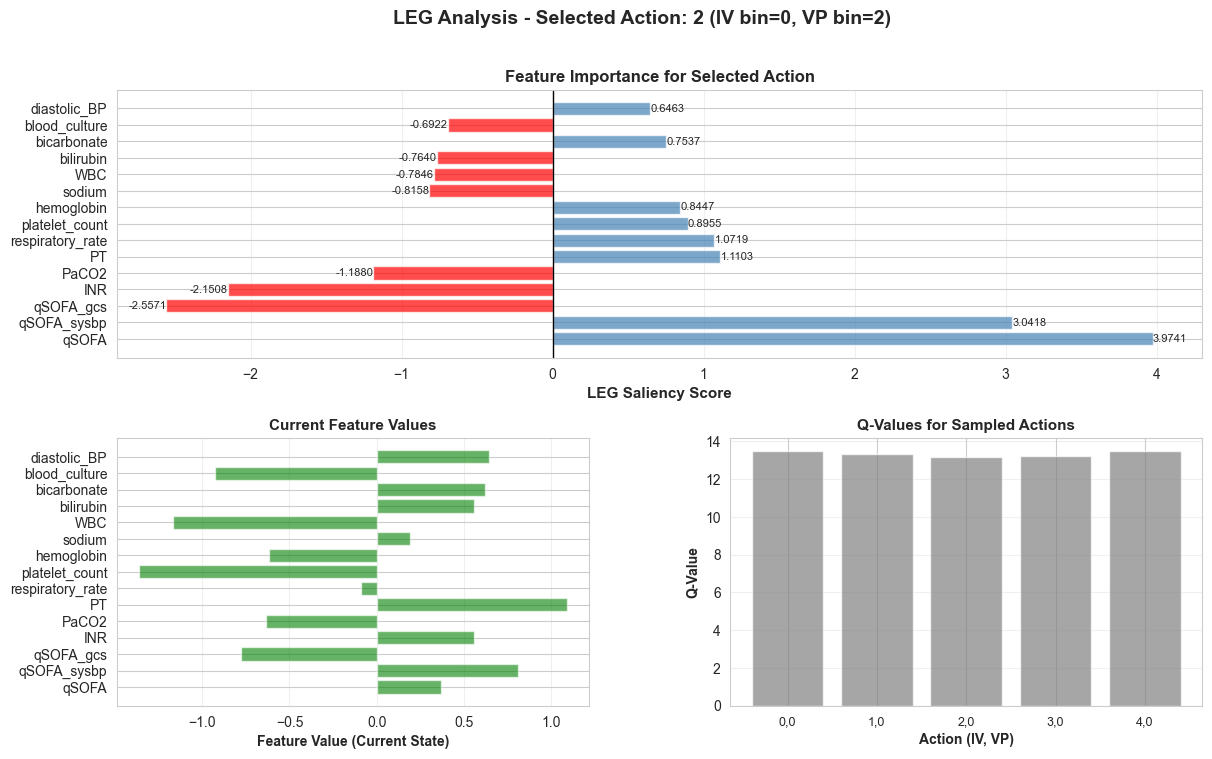

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_3.png


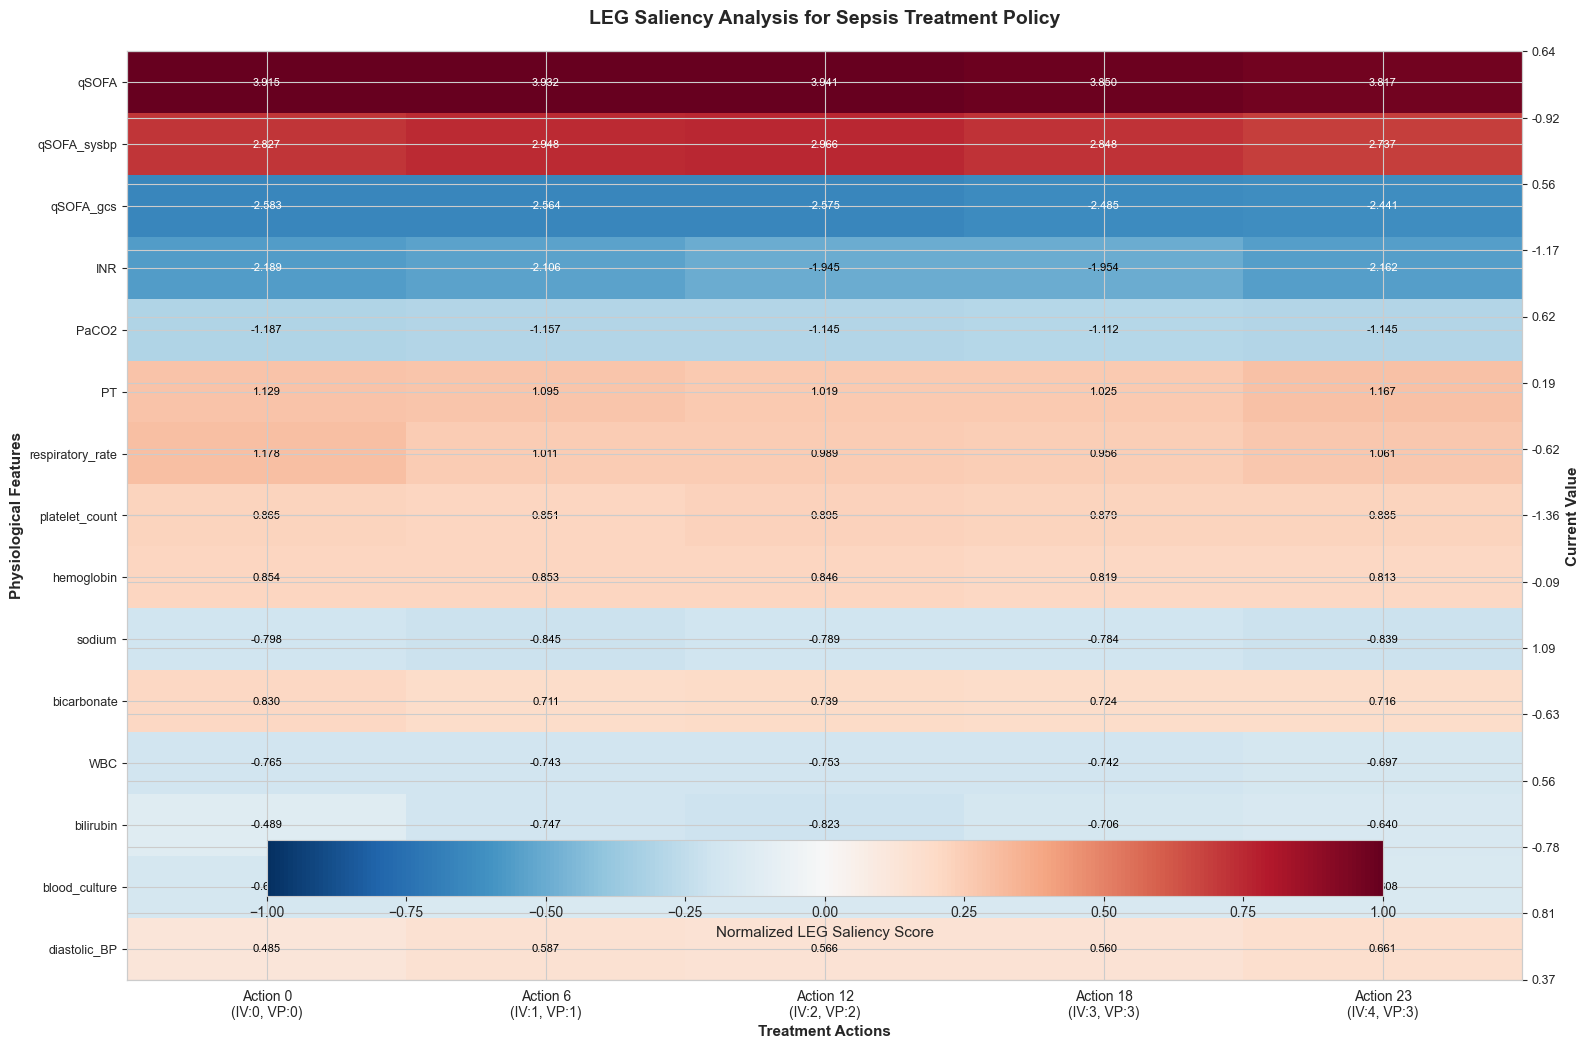


--- Analyzing State 5/10 (Episode 4, Timestep 4) ---
Analyzing 41 features...
Selected Action: 20 (IV=4, VP=0)
Top 5 Features:
  1. INR: score=-2.7182, value=-0.23
  2. qSOFA_gcs: score=-2.2618, value=-0.57
  3. qSOFA: score=2.2280, value=0.03
  4. glucose_1: score=-1.8763, value=0.02
  5. qSOFA_sysbp: score=1.8324, value=0.51


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_4.png


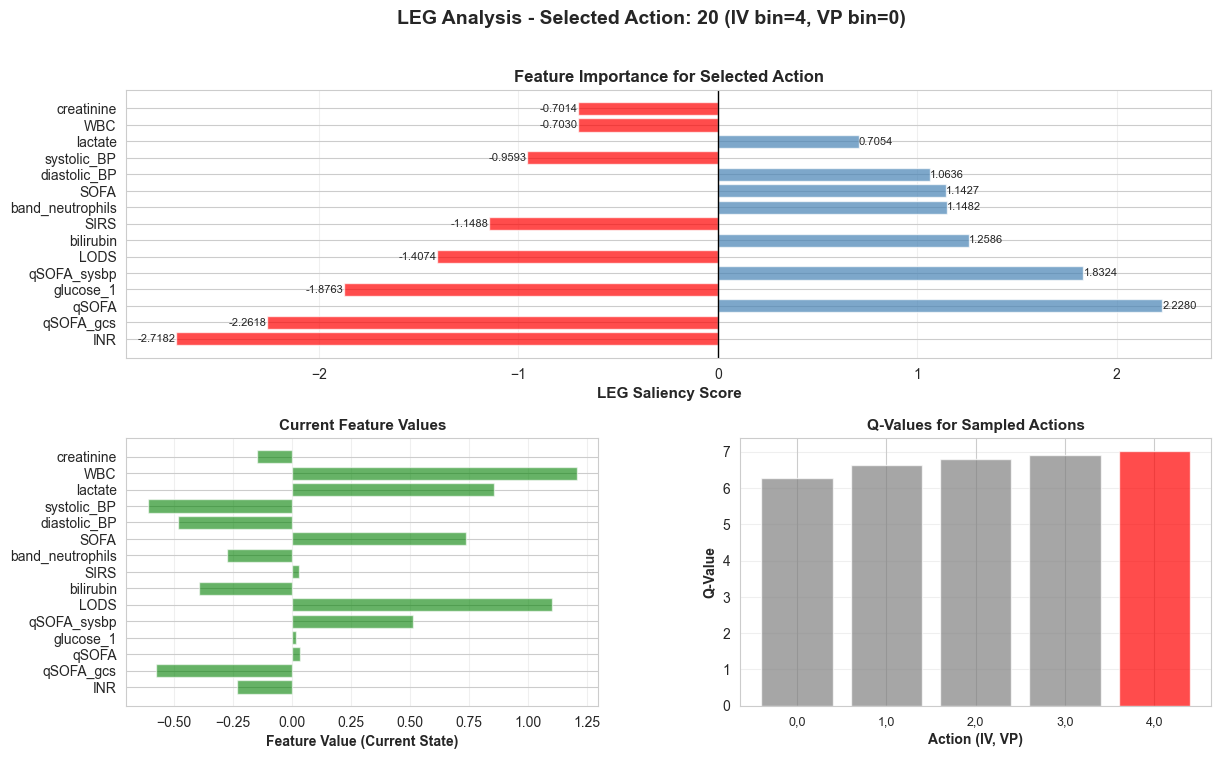

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_4.png


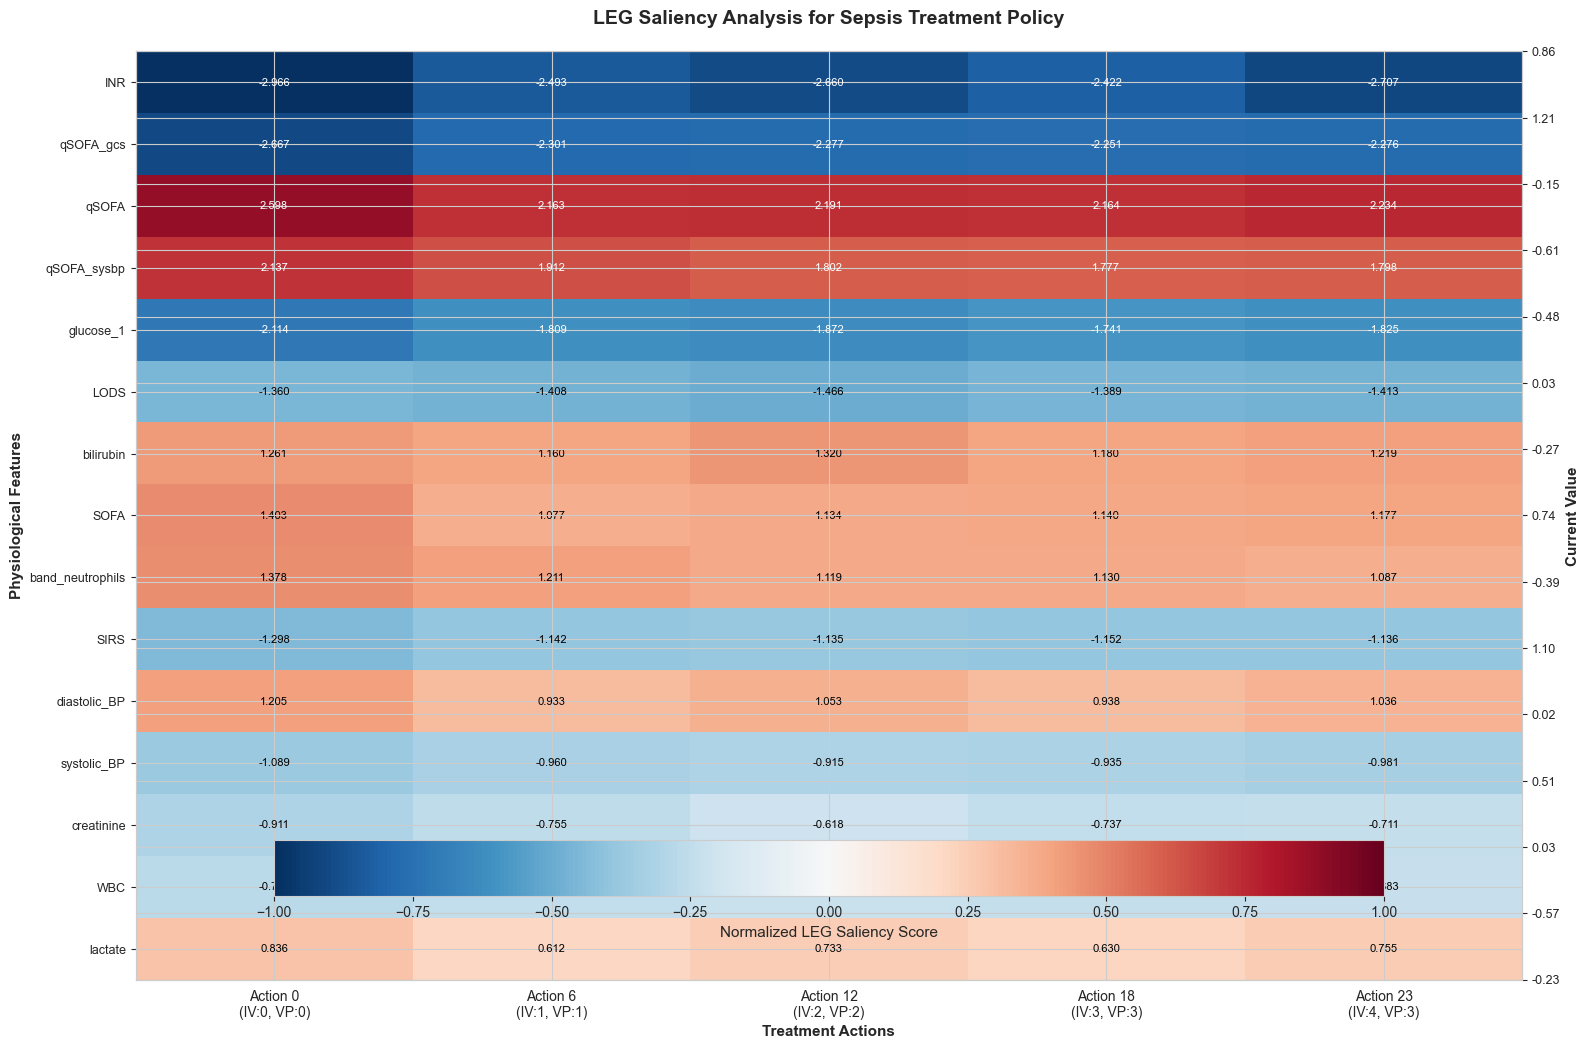


--- Analyzing State 6/10 (Episode 5, Timestep 5) ---
Analyzing 41 features...
Selected Action: 21 (IV=4, VP=1)
Top 5 Features:
  1. LODS: score=-5.9423, value=0.14
  2. qSOFA_sysbp: score=3.8411, value=-1.78
  3. blood_culture: score=3.6019, value=2.03
  4. elixhauser: score=-2.8075, value=2.21
  5. chloride: score=2.7962, value=-1.24


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_5.png


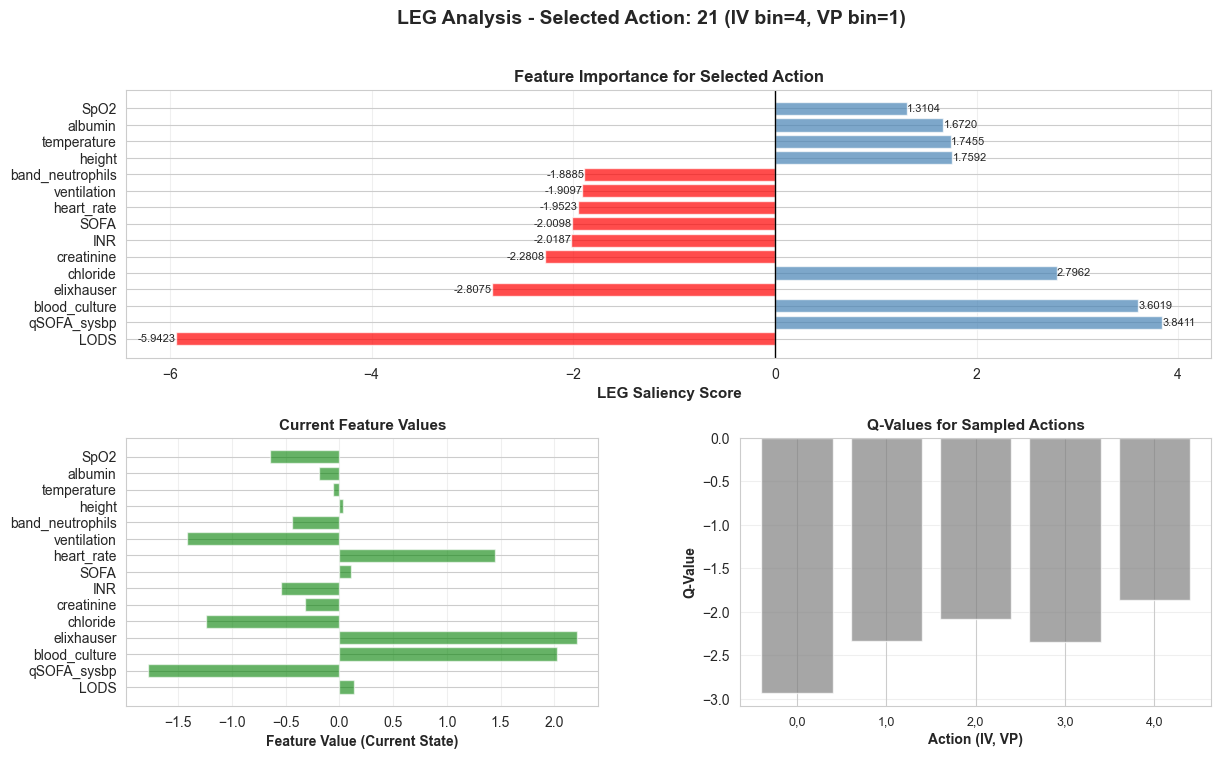

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_5.png


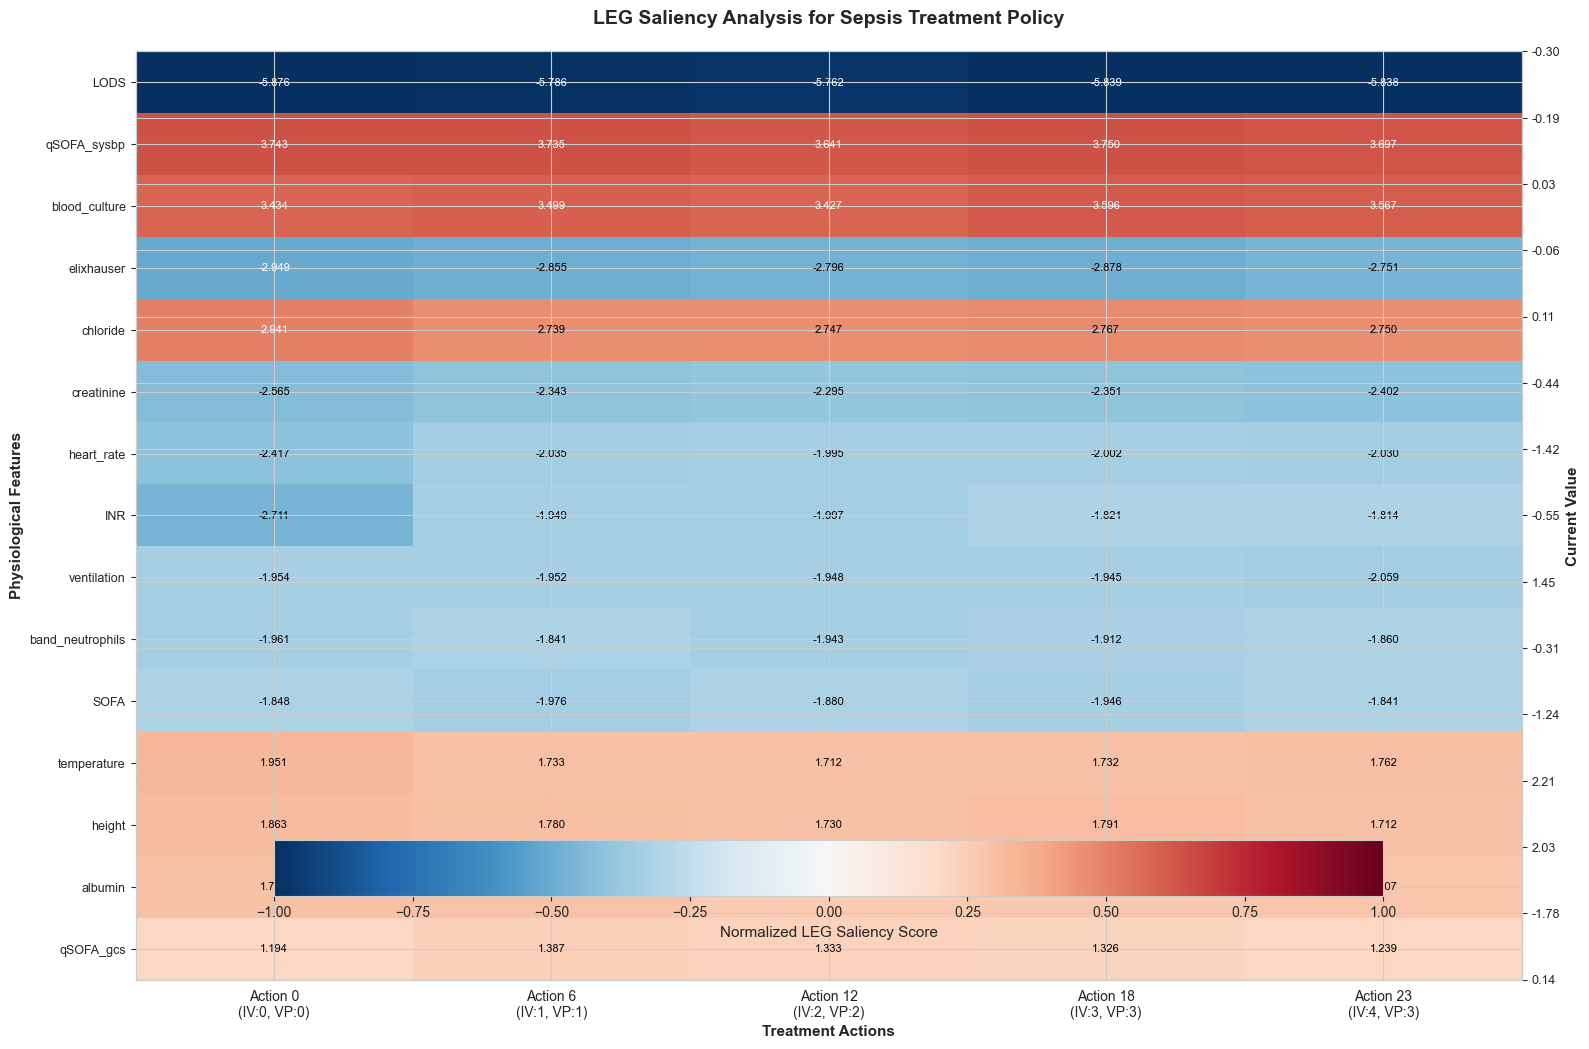


--- Analyzing State 7/10 (Episode 6, Timestep 4) ---
Analyzing 41 features...
Selected Action: 23 (IV=4, VP=3)
Top 5 Features:
  1. INR: score=-5.7493, value=-0.61
  2. qSOFA: score=4.4384, value=0.09
  3. qSOFA_sysbp: score=4.2604, value=0.56
  4. qSOFA_gcs: score=-3.0097, value=-0.68
  5. PT: score=2.7307, value=-0.45


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_6.png


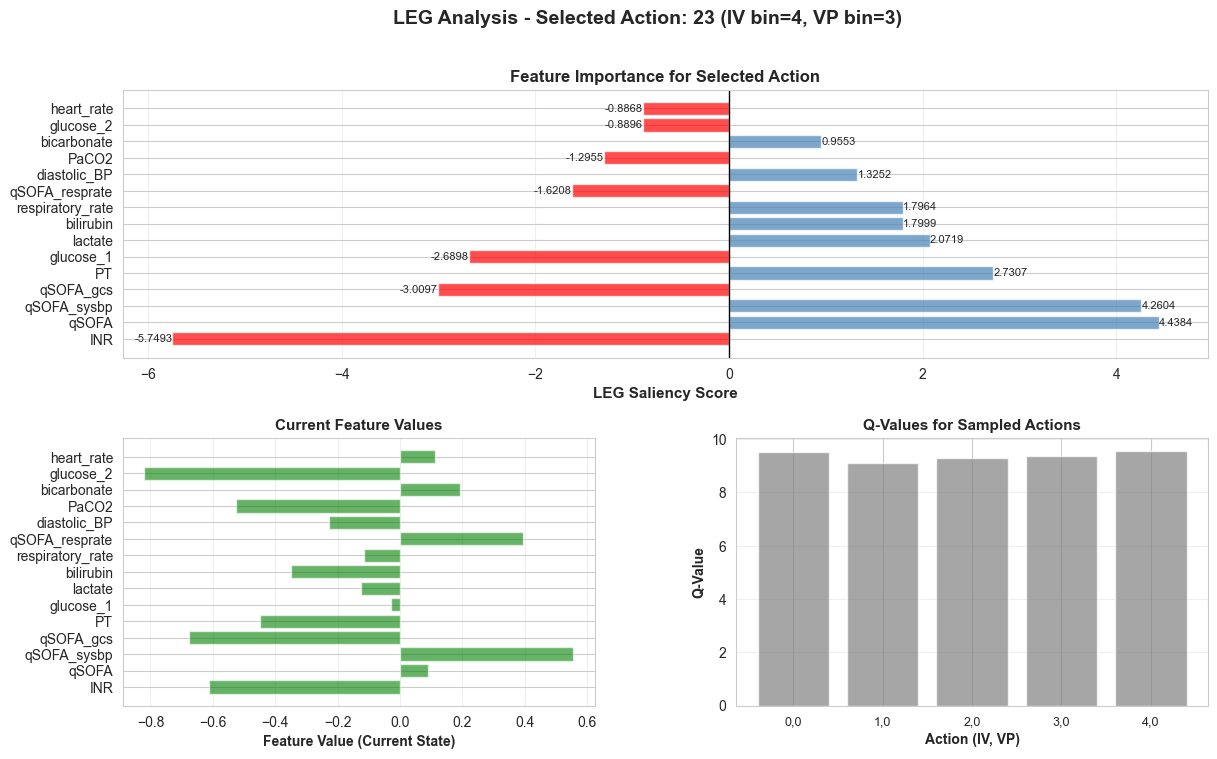

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_6.png


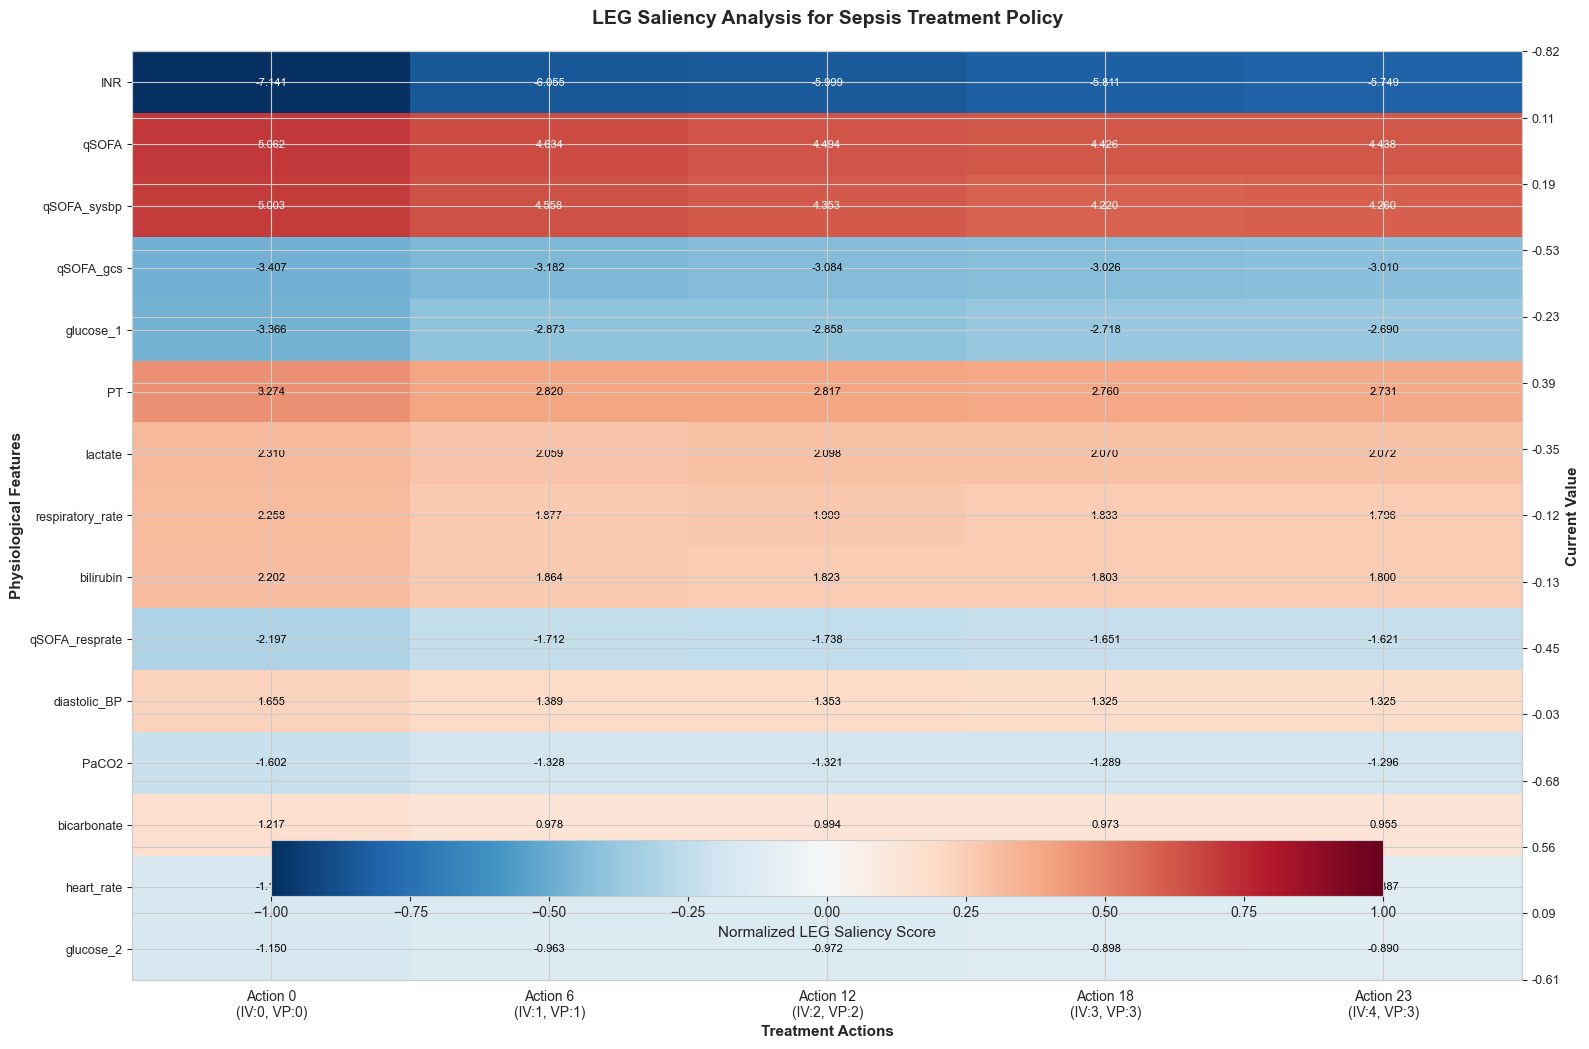


--- Analyzing State 8/10 (Episode 7, Timestep 5) ---
Analyzing 41 features...
Selected Action: 0 (IV=0, VP=0)
Top 5 Features:
  1. INR: score=-6.4321, value=-0.43
  2. bilirubin: score=5.1424, value=-0.33
  3. qSOFA: score=3.9053, value=1.81
  4. qSOFA_resprate: score=-3.4827, value=0.38
  5. glucose_1: score=-3.4757, value=-0.01


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_7.png


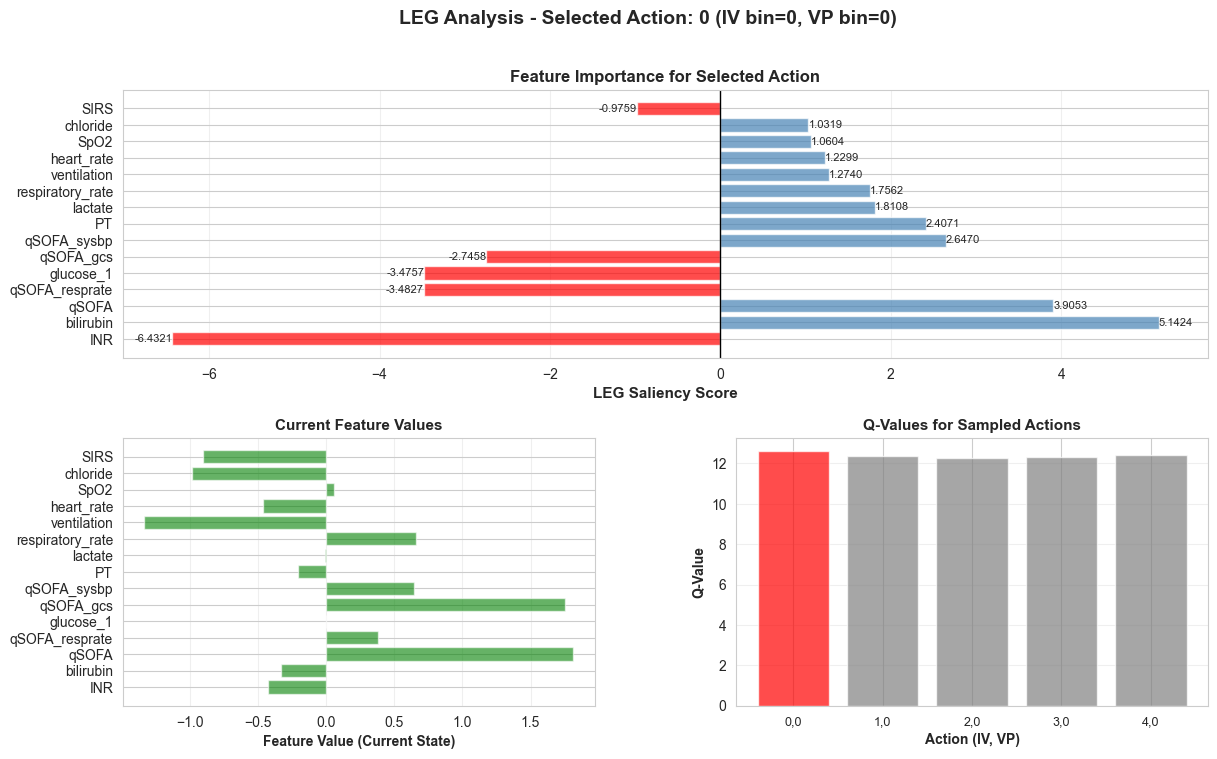

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_7.png


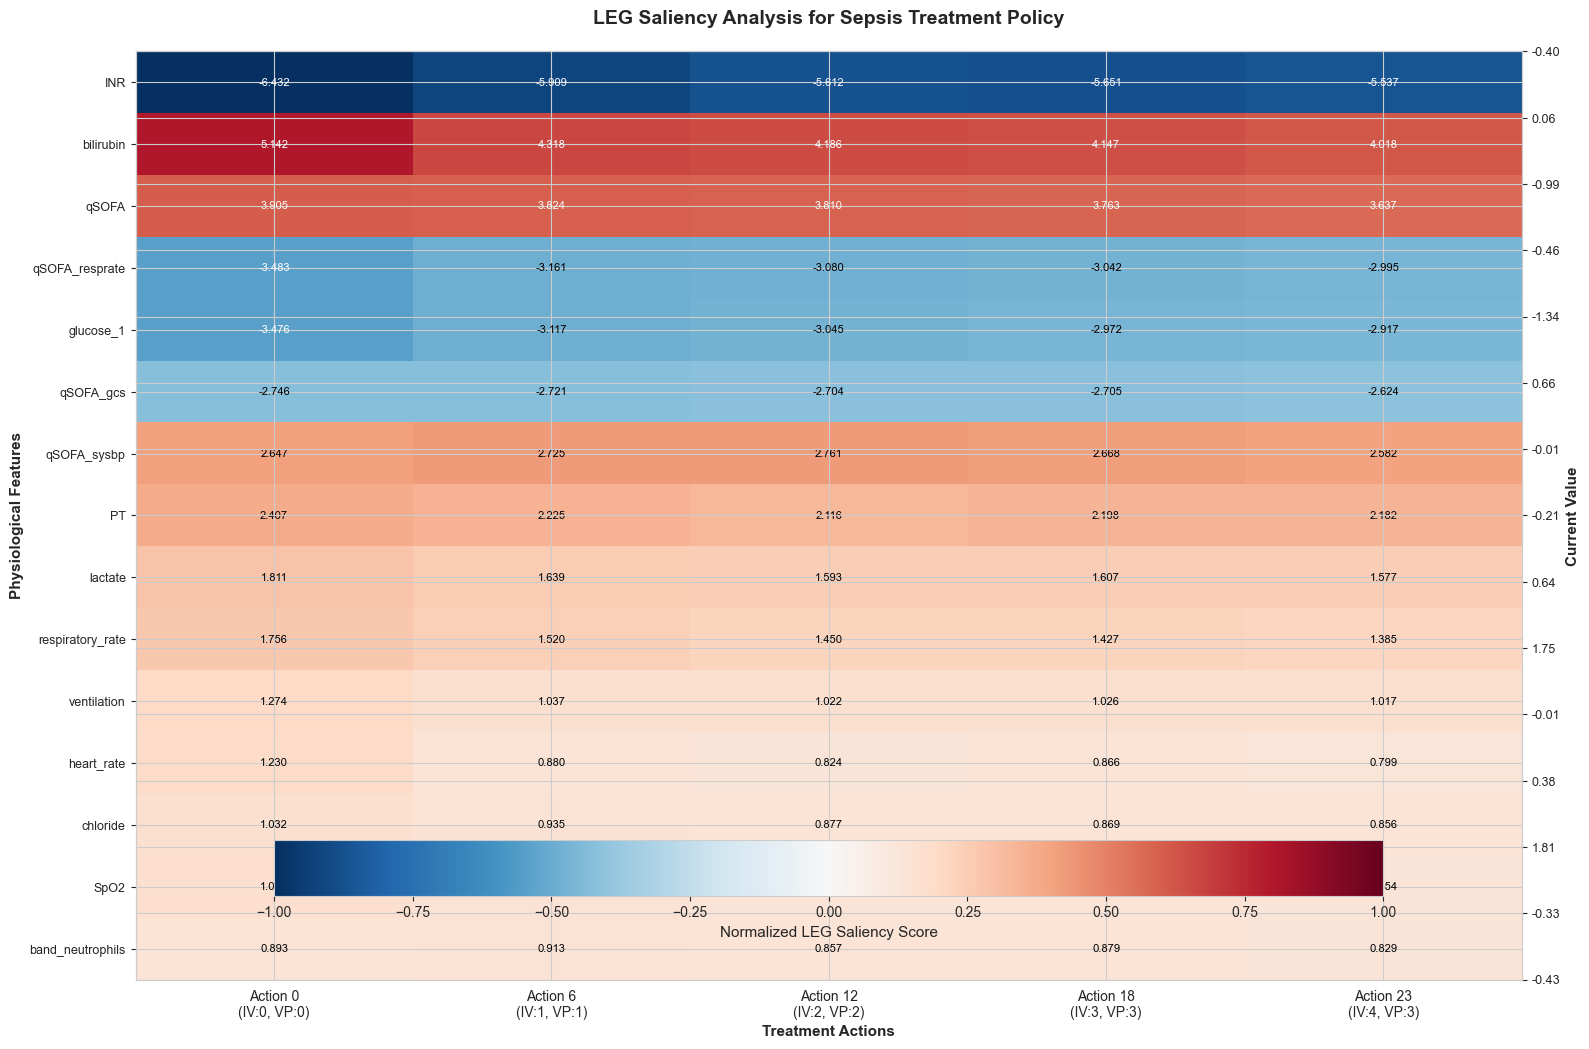


--- Analyzing State 9/10 (Episode 8, Timestep 5) ---
Analyzing 41 features...
Selected Action: 21 (IV=4, VP=1)
Top 5 Features:
  1. INR: score=-3.7652, value=-0.26
  2. qSOFA: score=3.1803, value=-0.90
  3. qSOFA_sysbp: score=2.9750, value=0.78
  4. qSOFA_gcs: score=-2.0553, value=-0.51
  5. glucose_1: score=-1.8119, value=-0.04


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_8.png


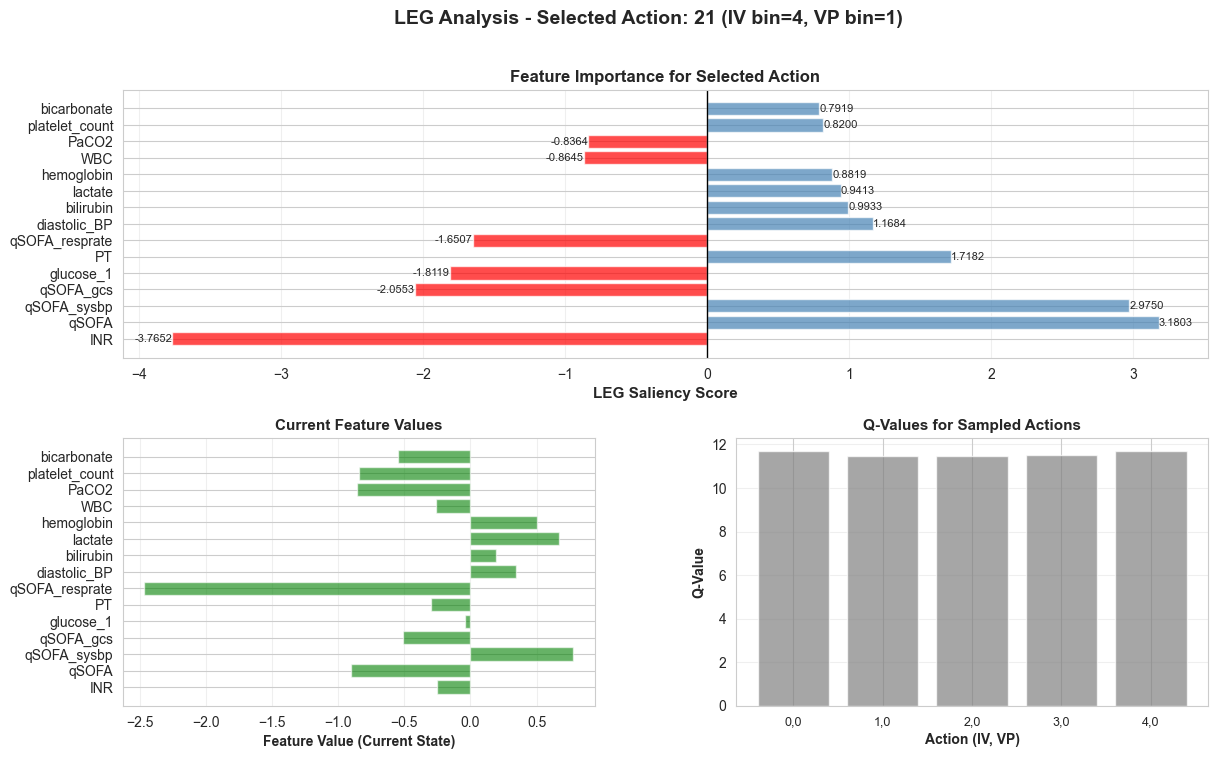

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_8.png


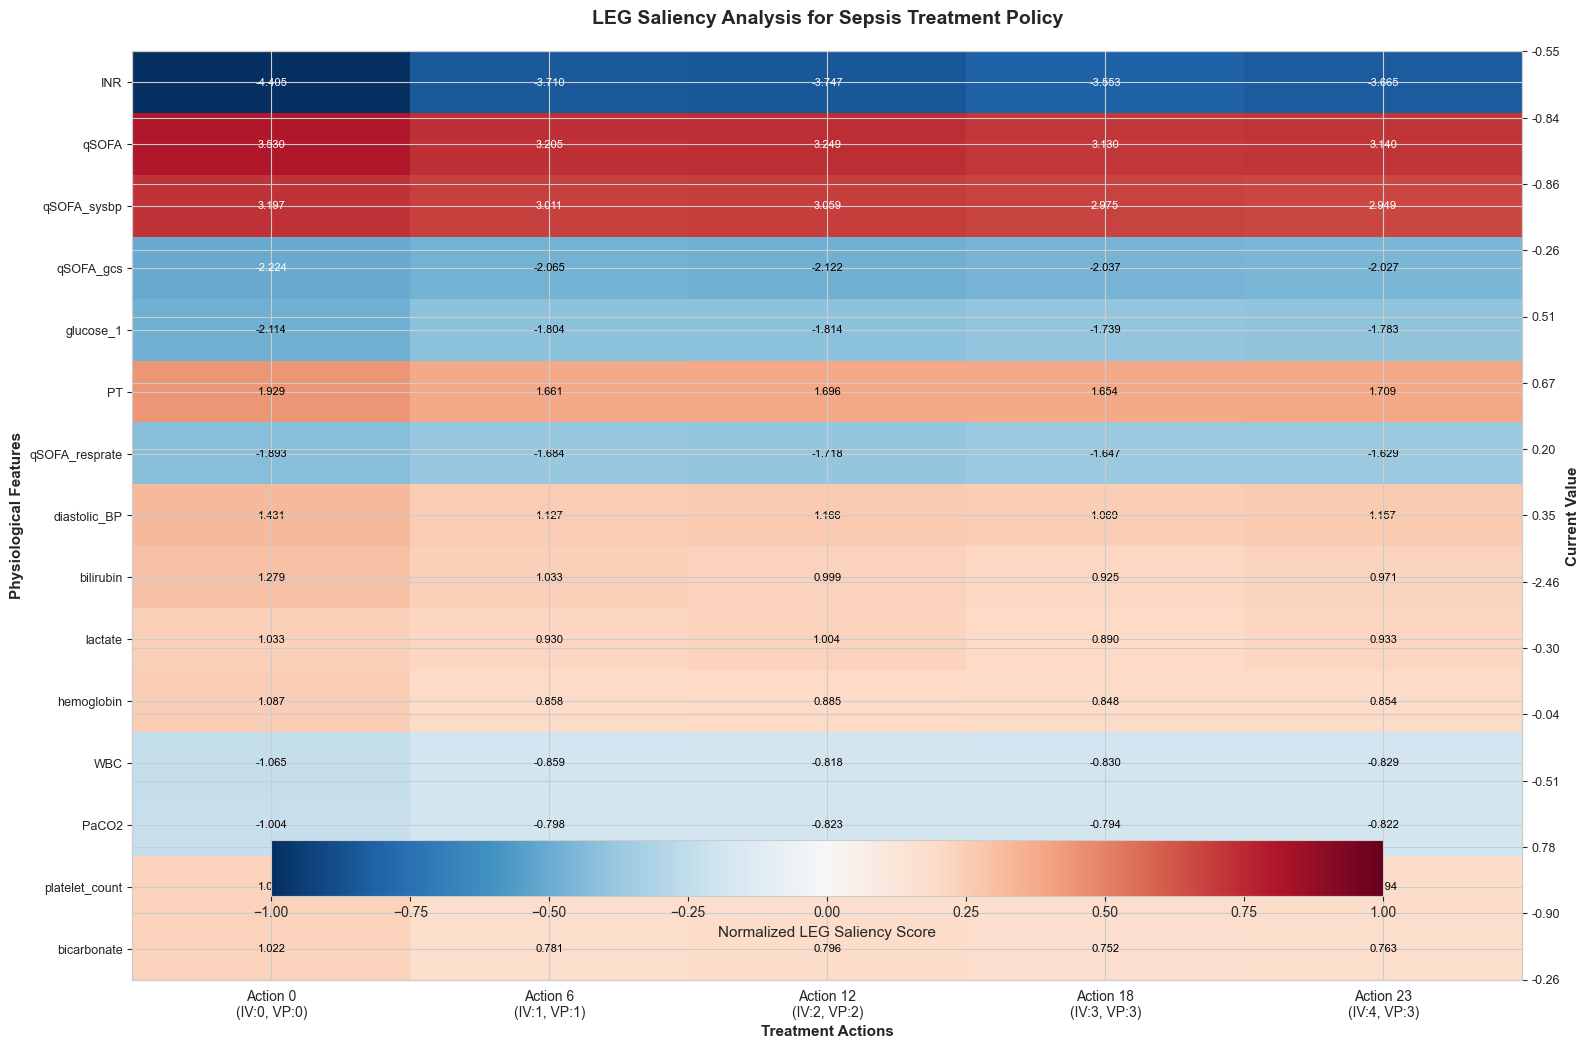


--- Analyzing State 10/10 (Episode 9, Timestep 4) ---
Analyzing 41 features...
Selected Action: 23 (IV=4, VP=3)
Top 5 Features:
  1. qSOFA_resprate: score=3.2343, value=0.72
  2. LODS: score=-1.9700, value=1.17
  3. qSOFA: score=1.8770, value=0.46
  4. elixhauser: score=-1.6068, value=-0.42
  5. PaCO2: score=-1.2325, value=1.00


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_att_model_final/analysis_state_9.png


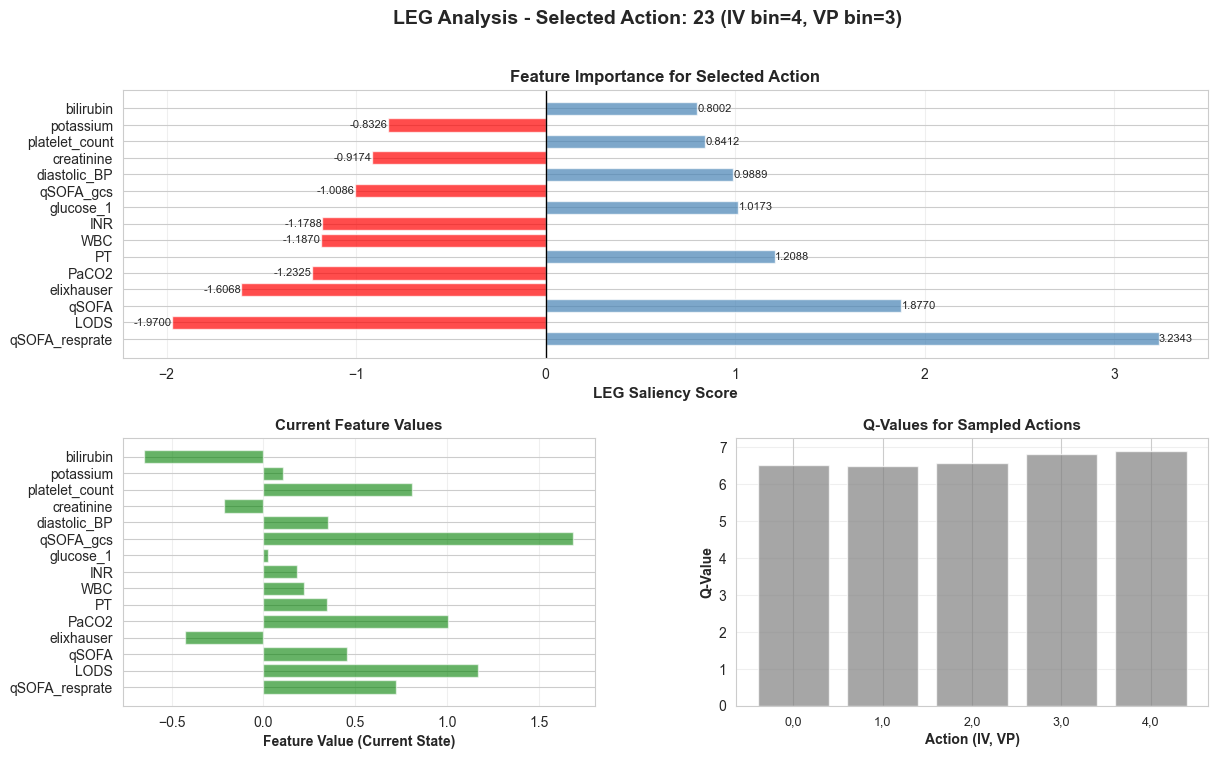

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_att_model_final/saliency_state_9.png


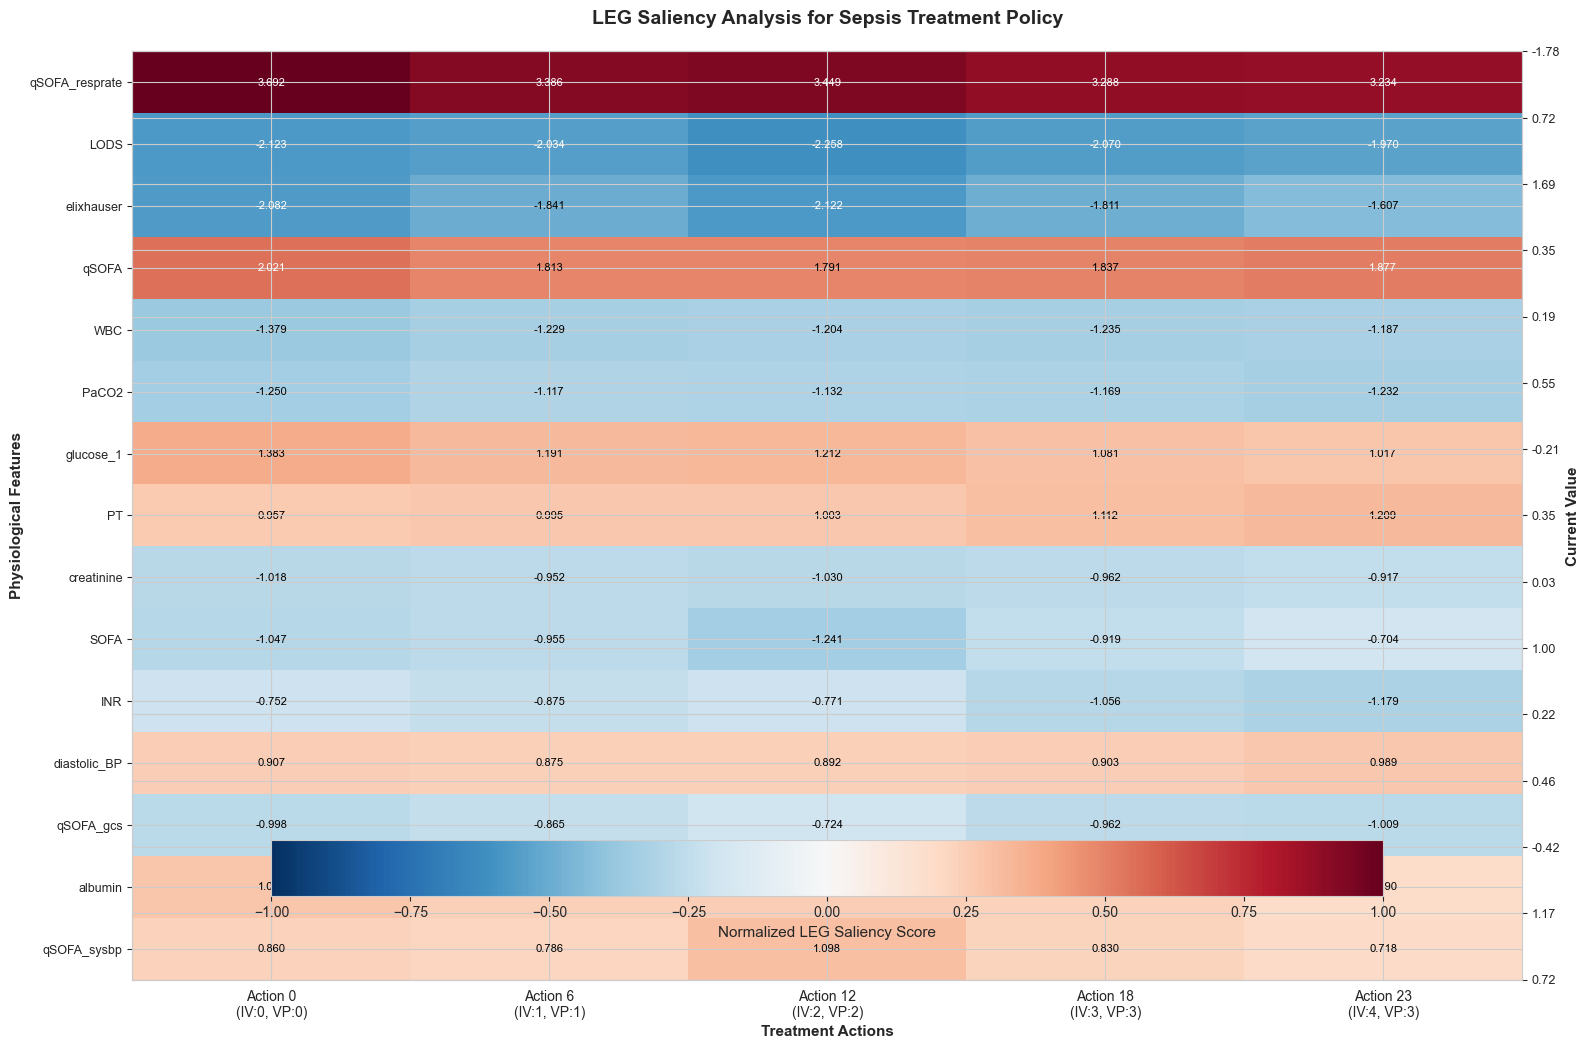


--- Analyzing Treatment Patterns ---
Saved treatment pattern to ./sepsis_leg_analysis/ddqn_online_att_model_final/treatment_patterns.png


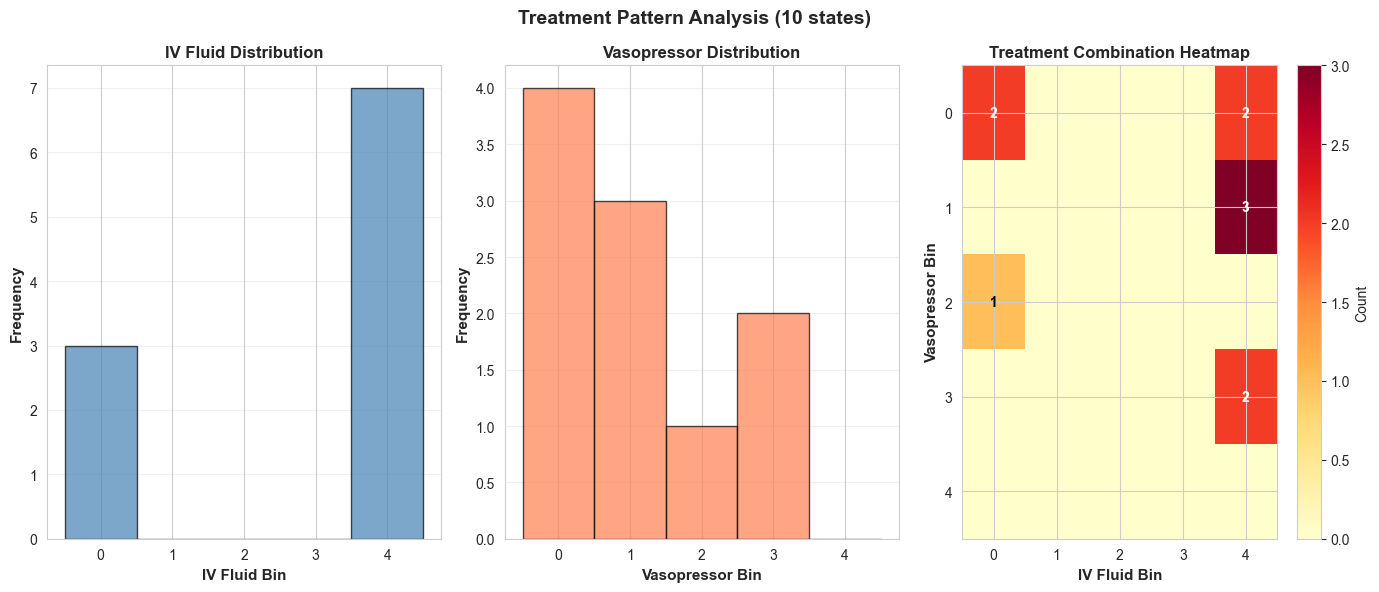


Analyzing Model: ddqn_online_res_model_final

Performing LEG Analysis

--- Analyzing State 1/10 (Episode 0, Timestep 4) ---
Analyzing 41 features...
Selected Action: 19 (IV=3, VP=4)
Top 5 Features:
  1. INR: score=-3.5839, value=-0.54
  2. glucose_1: score=-2.5889, value=-0.01
  3. bilirubin: score=2.3331, value=-0.21
  4. PaCO2: score=-1.9721, value=-1.19
  5. glucose_2: score=-1.8302, value=-0.42


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_0.png


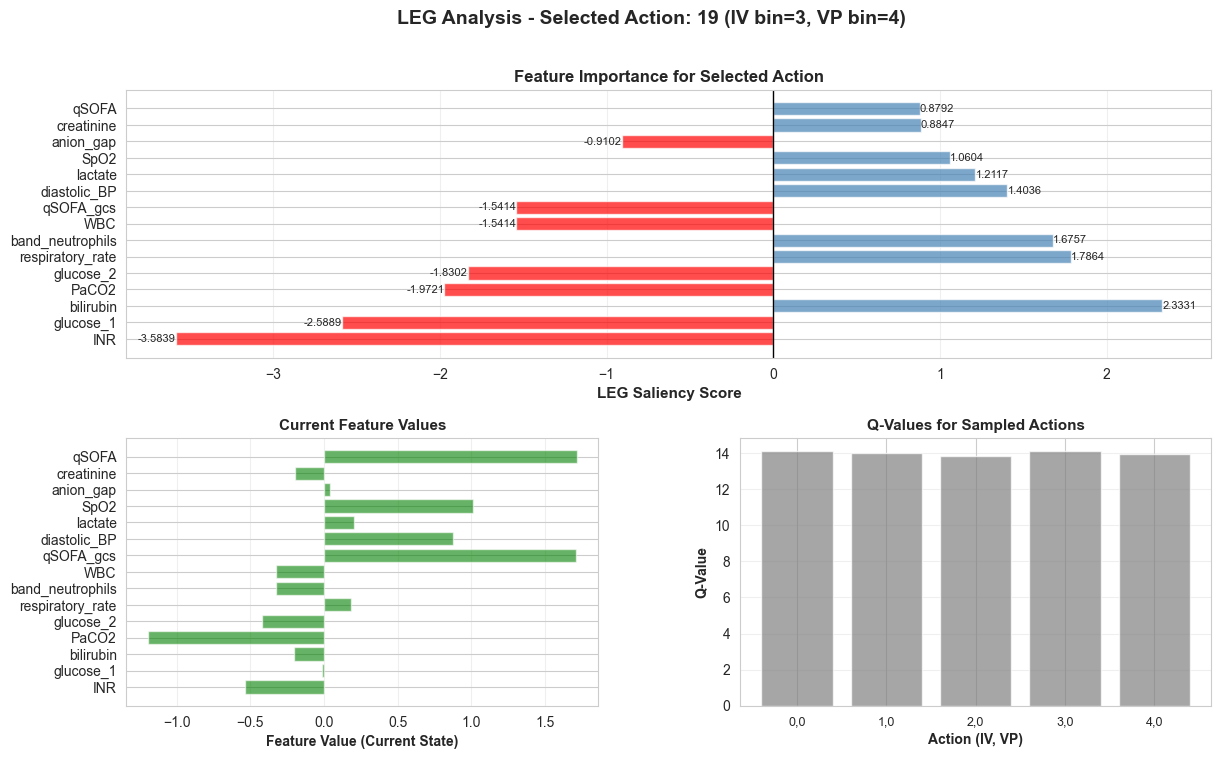

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_0.png


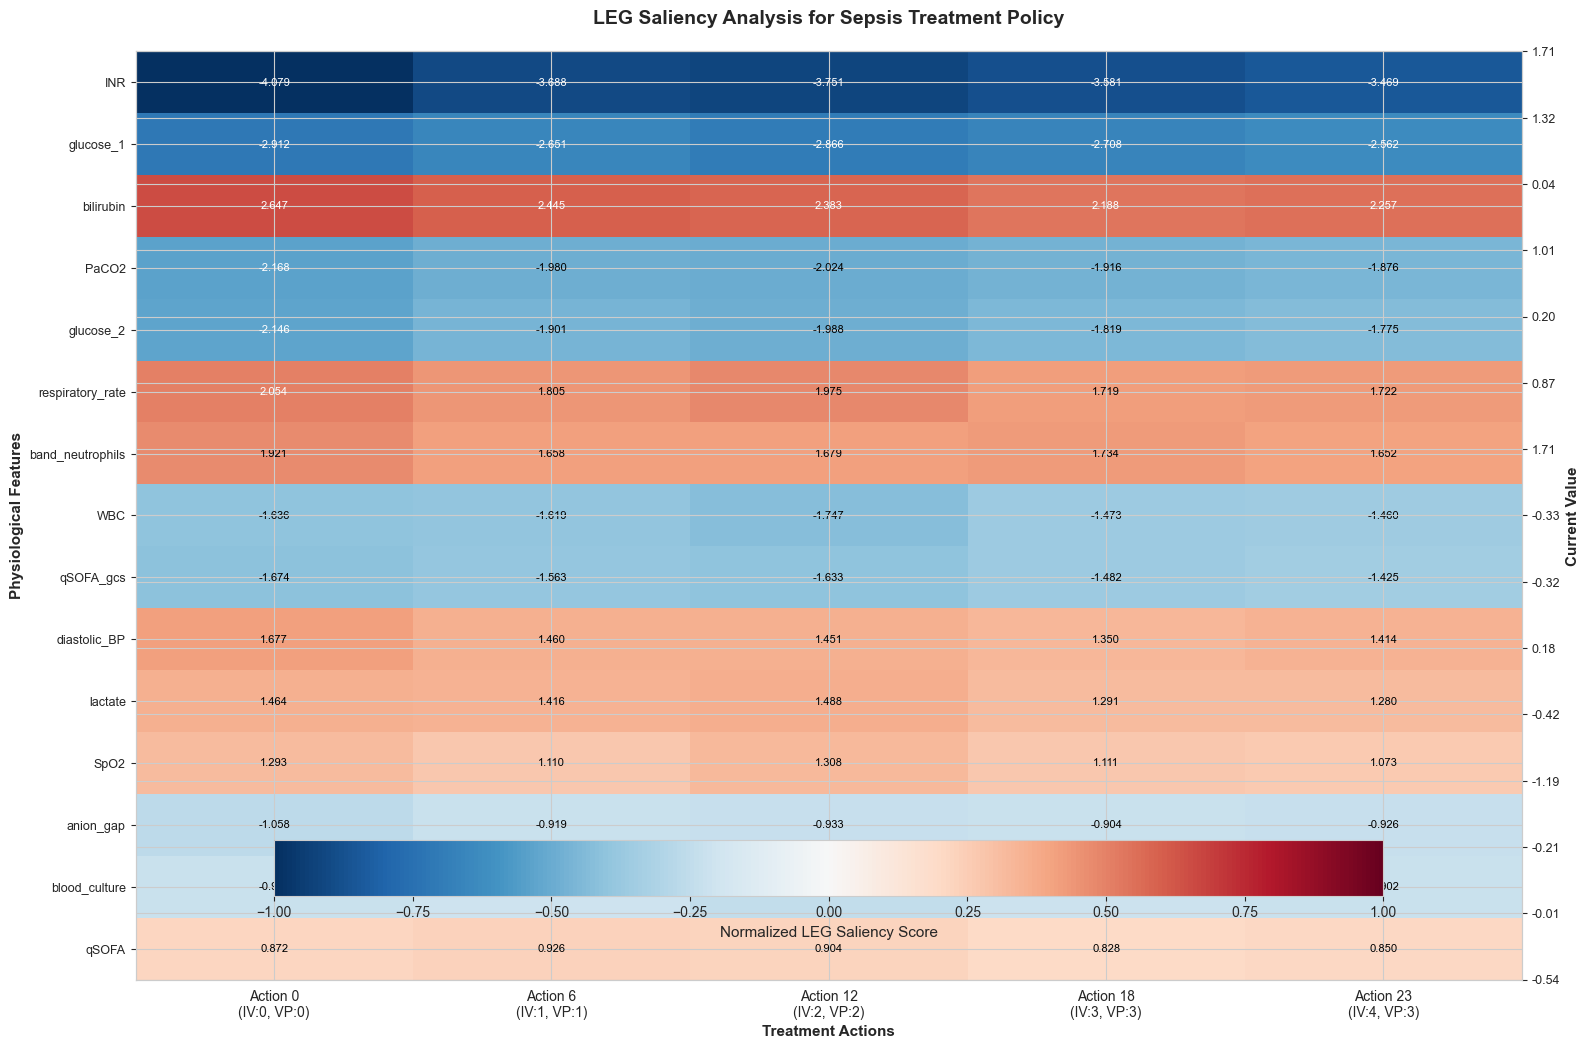


--- Analyzing State 2/10 (Episode 1, Timestep 5) ---
Analyzing 41 features...
Selected Action: 20 (IV=4, VP=0)
Top 5 Features:
  1. glucose_1: score=-3.9339, value=-0.01
  2. INR: score=-2.5224, value=-0.34
  3. lactate: score=2.2495, value=0.39
  4. respiratory_rate: score=2.0291, value=0.17
  5. diastolic_BP: score=1.9667, value=-0.39


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_1.png


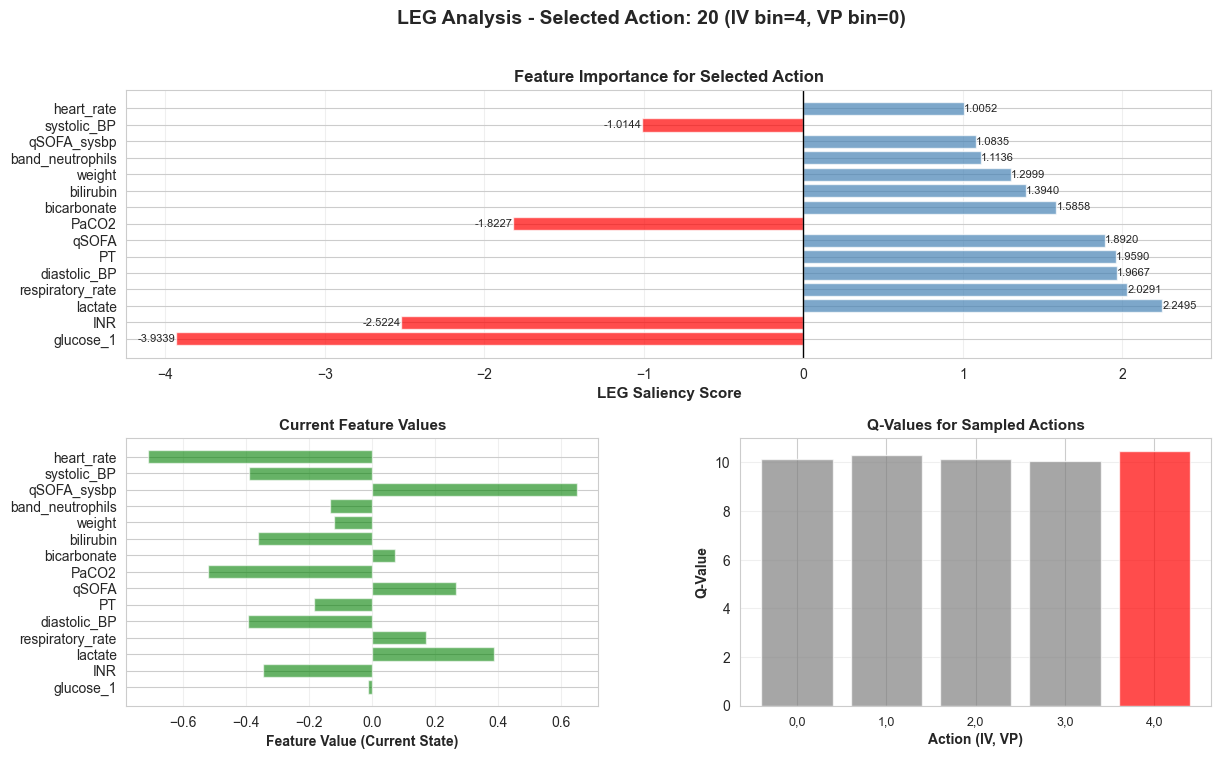

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_1.png


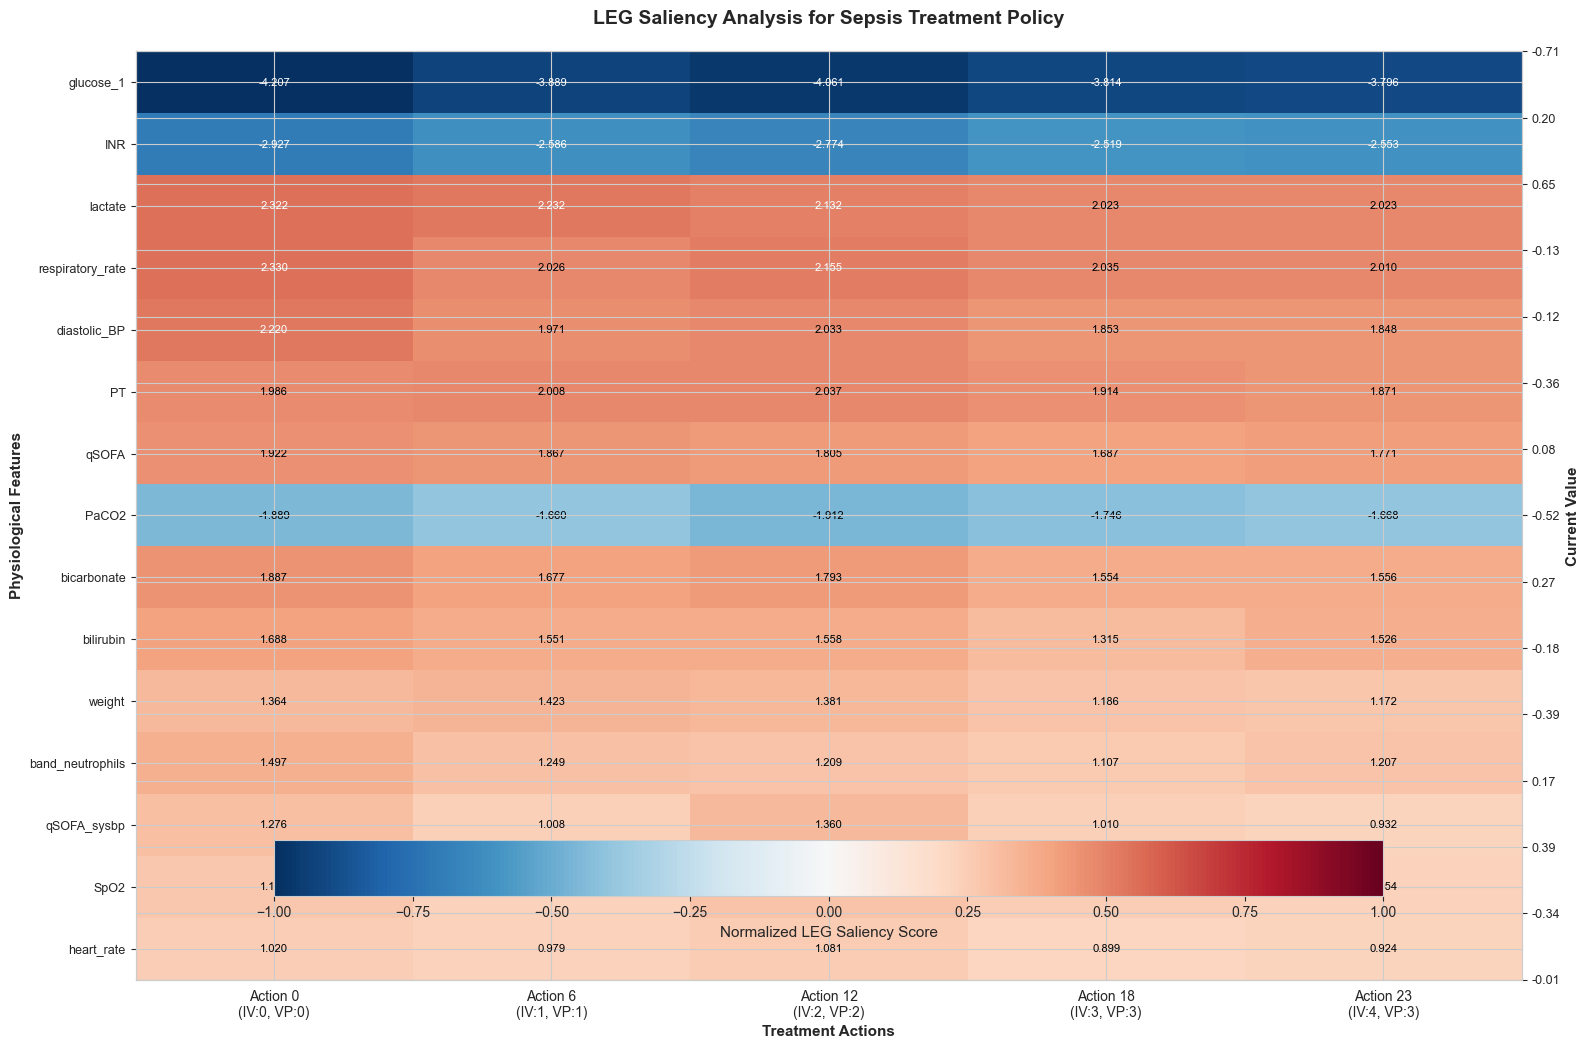


--- Analyzing State 3/10 (Episode 2, Timestep 4) ---
Analyzing 41 features...
Selected Action: 20 (IV=4, VP=0)
Top 5 Features:
  1. INR: score=-1.1091, value=0.47
  2. PT: score=1.0431, value=0.80
  3. SpO2: score=1.0199, value=-0.08
  4. qSOFA_gcs: score=-0.8812, value=-0.76
  5. glucose_1: score=-0.8565, value=0.02


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_2.png


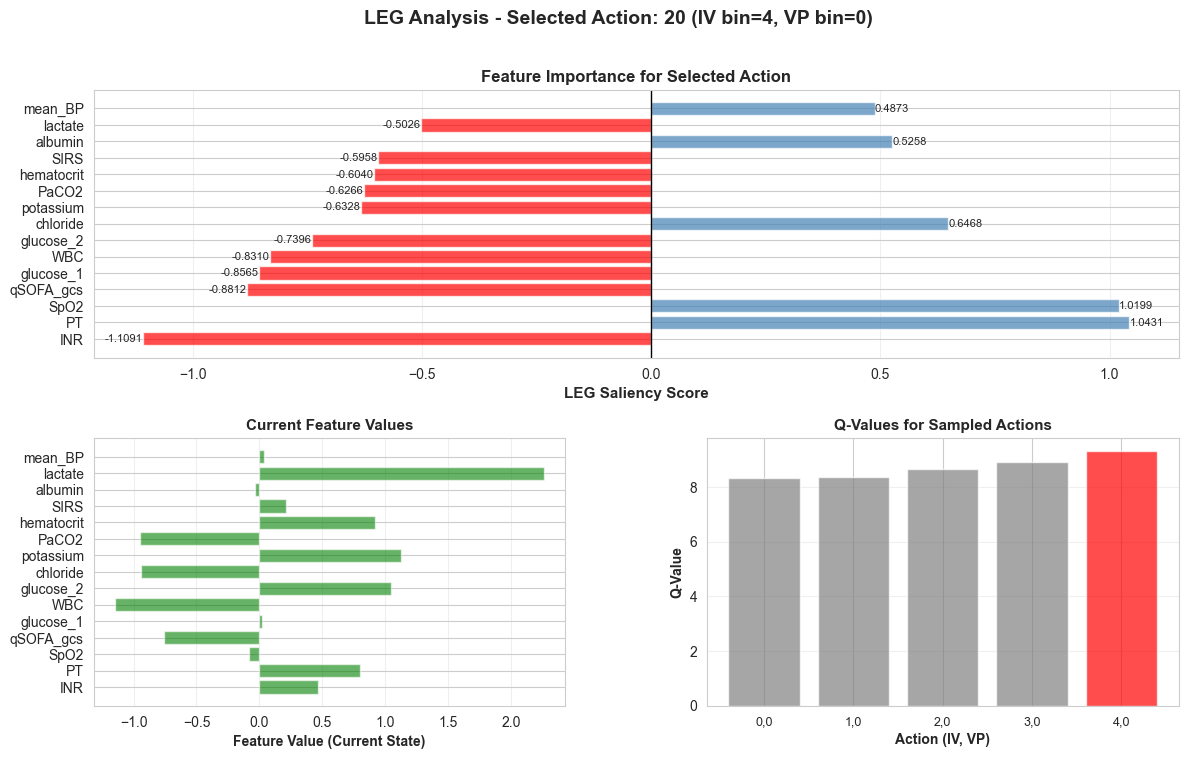

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_2.png


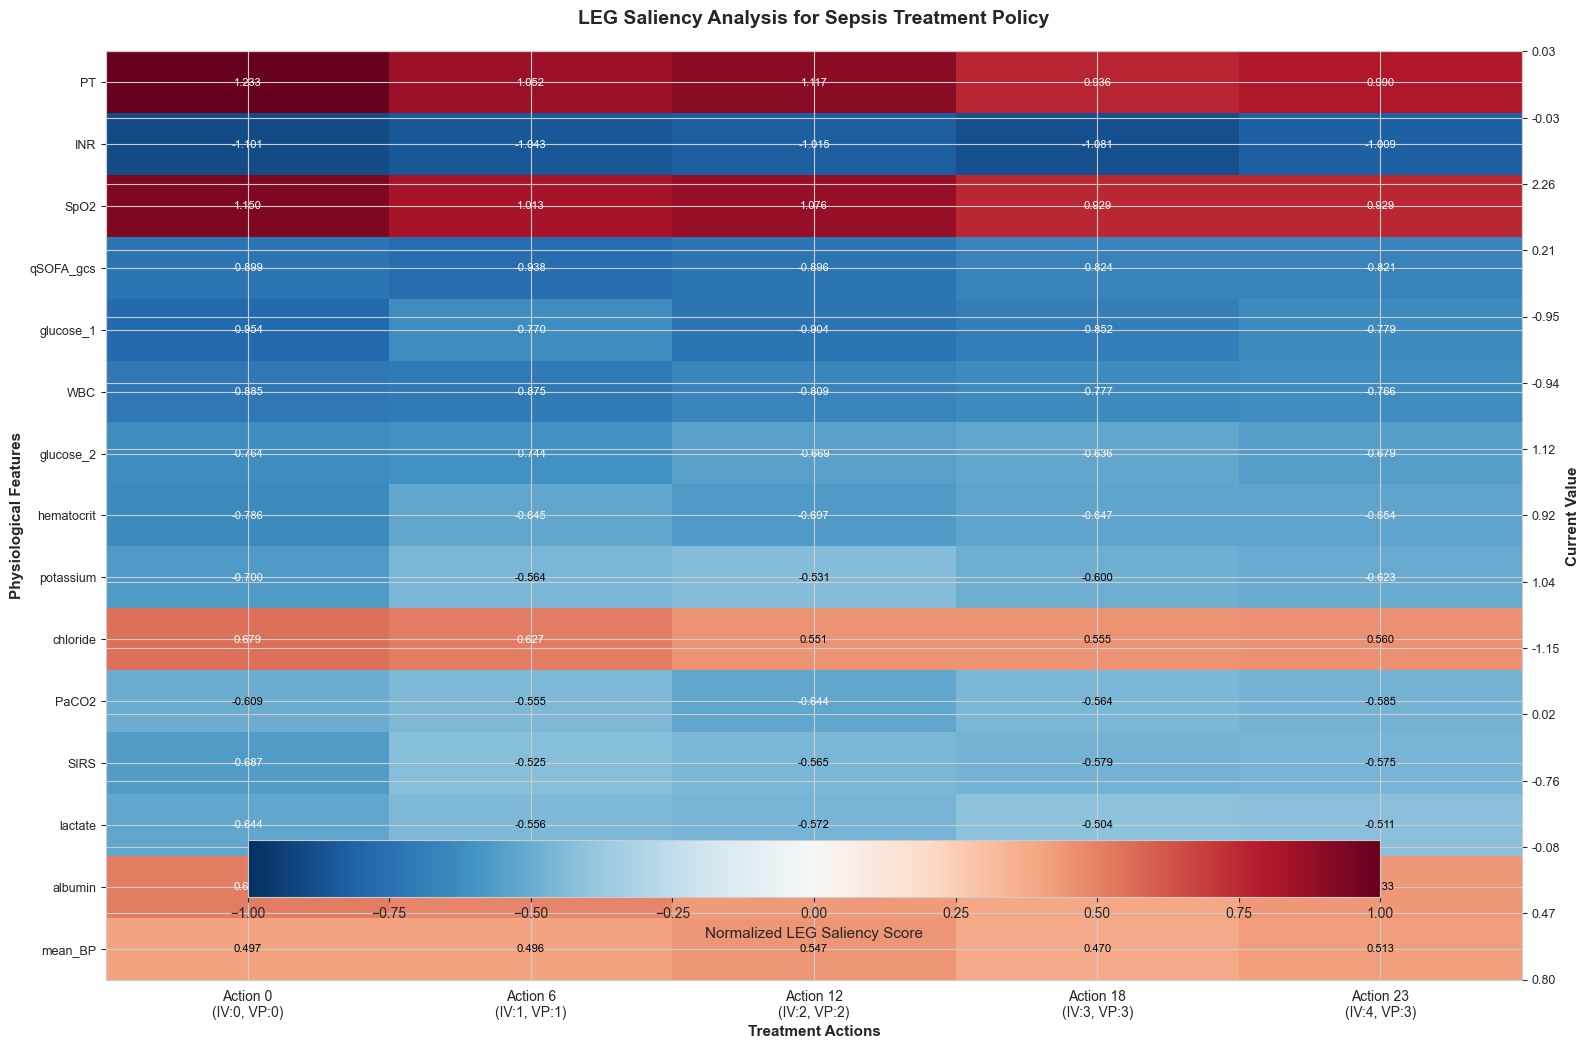


--- Analyzing State 4/10 (Episode 3, Timestep 5) ---
Analyzing 41 features...
Selected Action: 0 (IV=0, VP=0)
Top 5 Features:
  1. glucose_1: score=-1.2354, value=-0.01
  2. respiratory_rate: score=1.2308, value=-0.09
  3. INR: score=-1.1505, value=0.56
  4. PT: score=1.0469, value=1.09
  5. bilirubin: score=0.8060, value=0.56


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_3.png


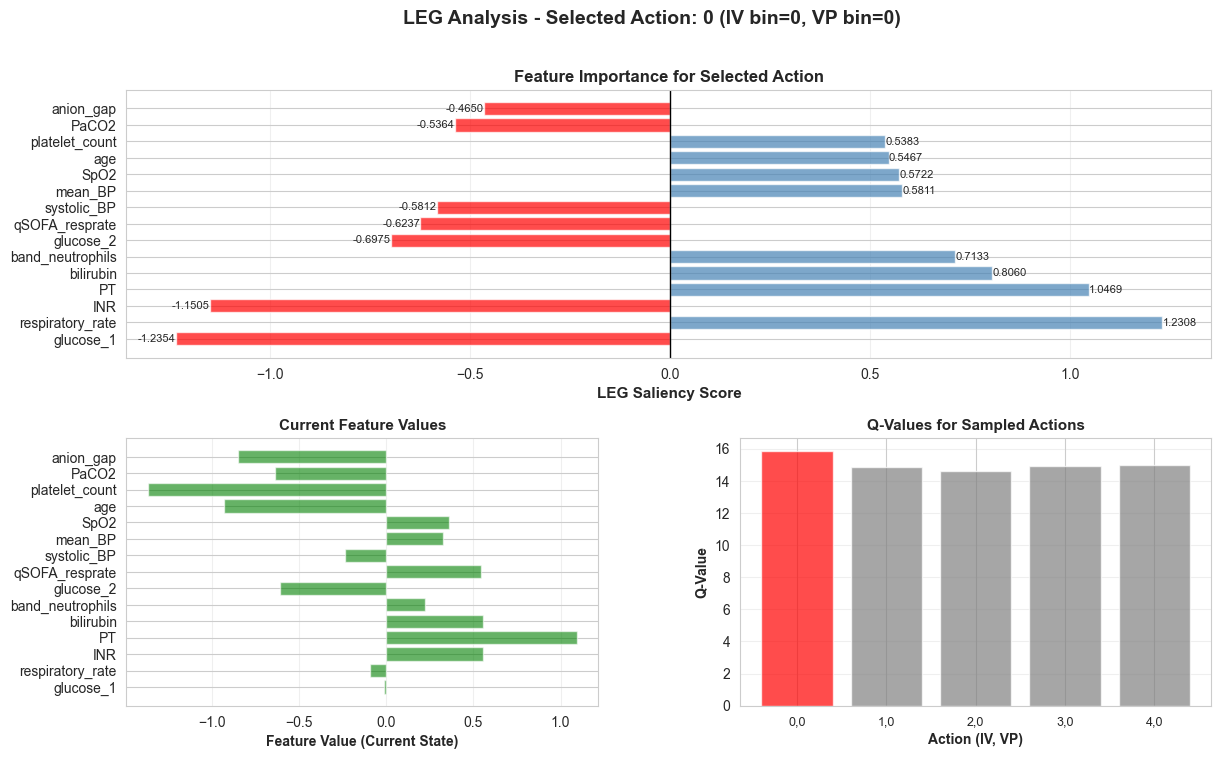

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_3.png


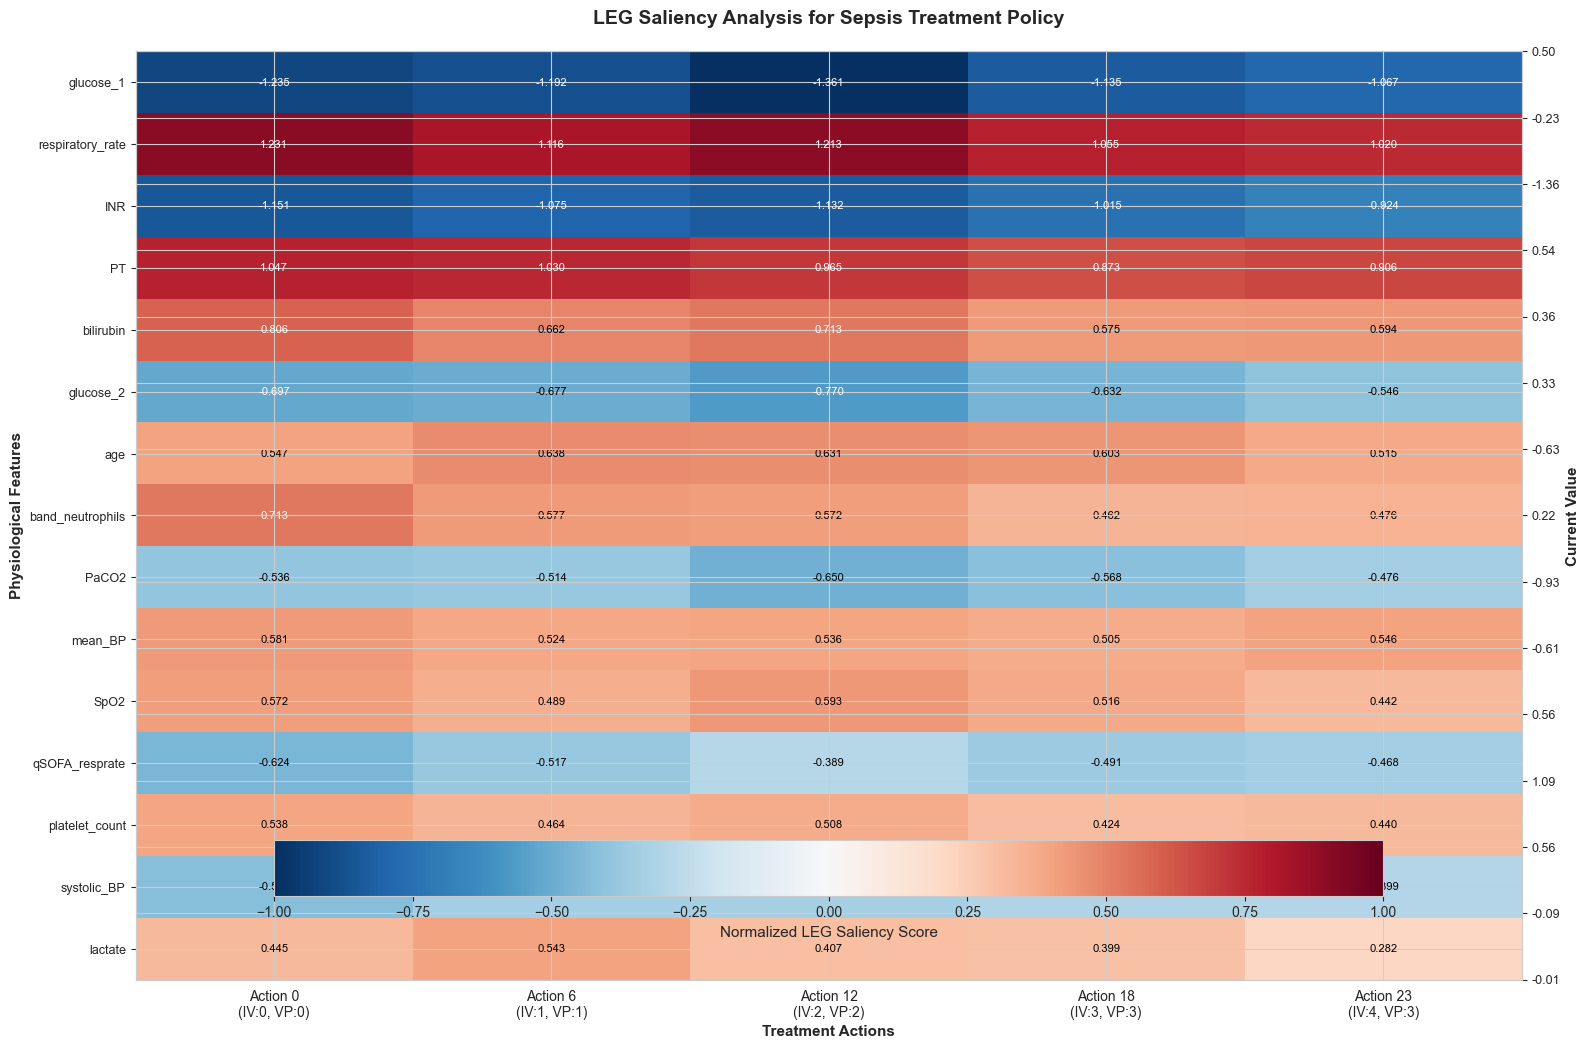


--- Analyzing State 5/10 (Episode 4, Timestep 4) ---
Analyzing 41 features...
Selected Action: 13 (IV=2, VP=3)
Top 5 Features:
  1. INR: score=-2.9494, value=-0.23
  2. bilirubin: score=2.2465, value=-0.39
  3. LODS: score=-2.1466, value=1.10
  4. glucose_1: score=-1.8726, value=0.02
  5. albumin: score=1.7386, value=-0.87


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_4.png


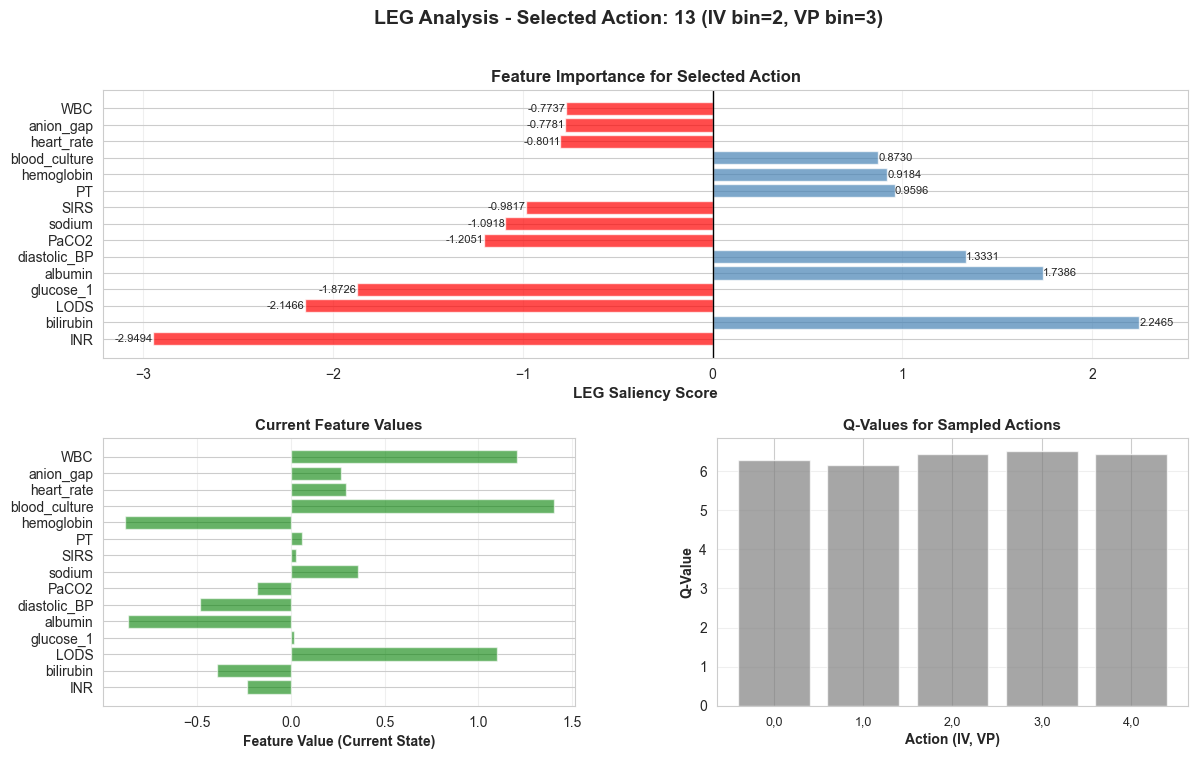

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_4.png


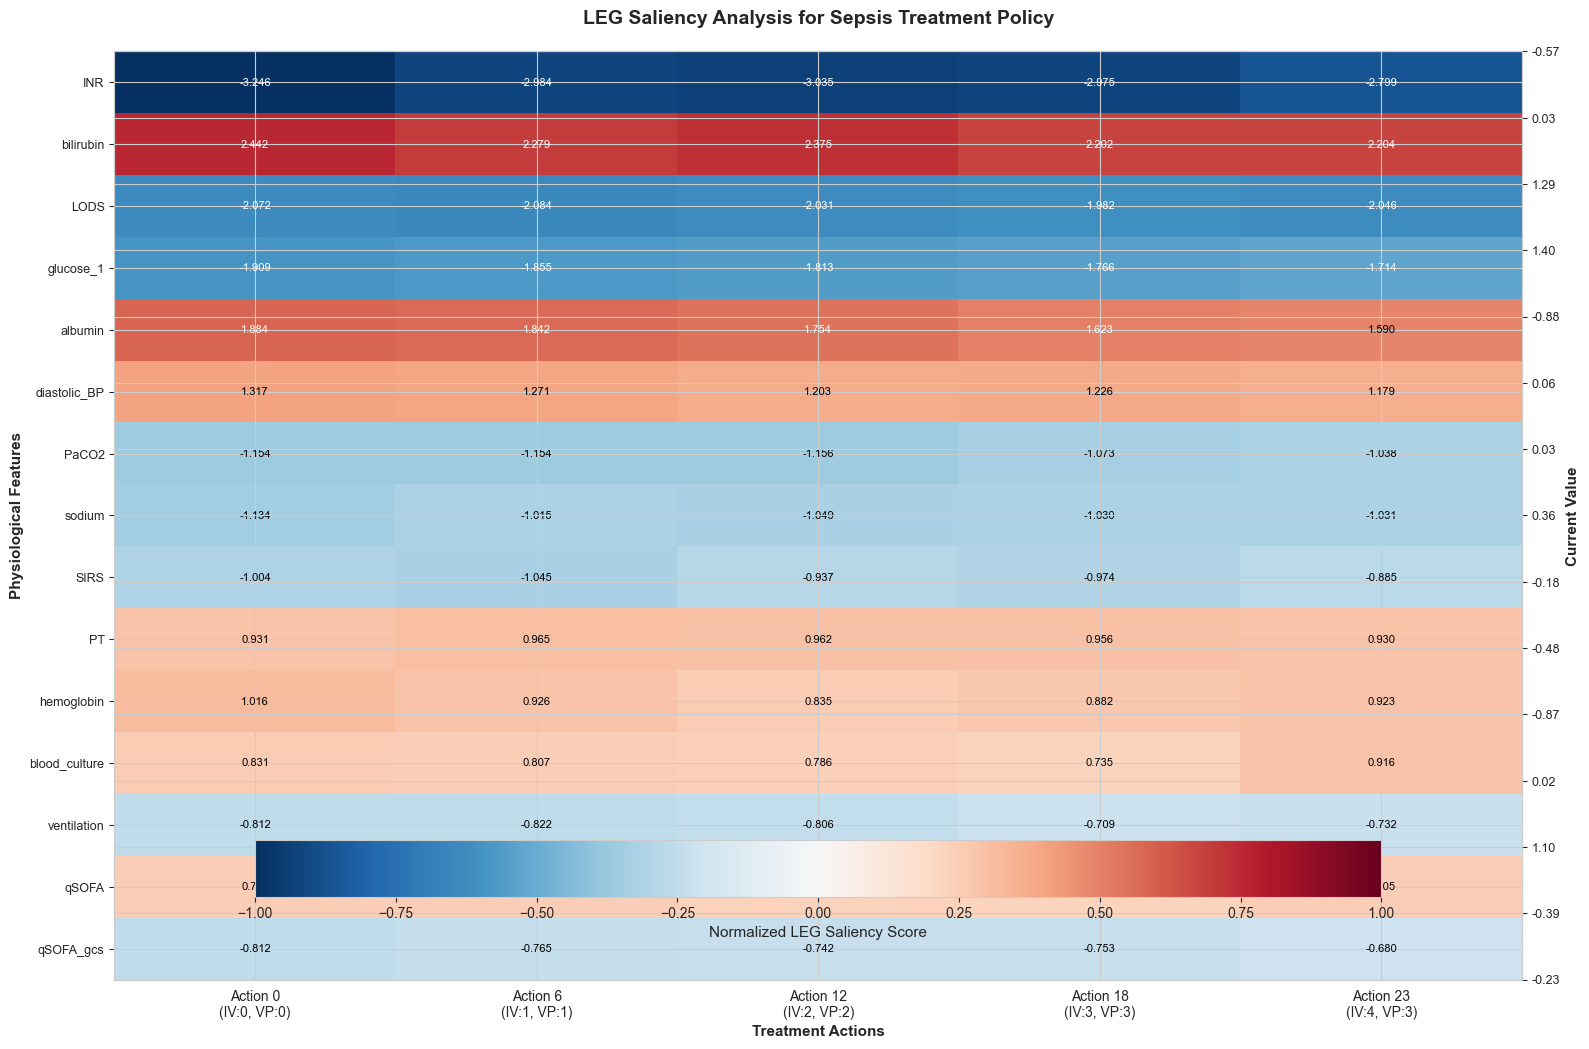


--- Analyzing State 6/10 (Episode 5, Timestep 5) ---
Analyzing 41 features...
Selected Action: 20 (IV=4, VP=0)
Top 5 Features:
  1. INR: score=-3.1352, value=-0.55
  2. glucose_1: score=-1.7343, value=-0.07
  3. PaCO2: score=-1.6305, value=-0.31
  4. LODS: score=-1.5686, value=0.14
  5. platelet_count: score=1.4341, value=-0.65


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_5.png


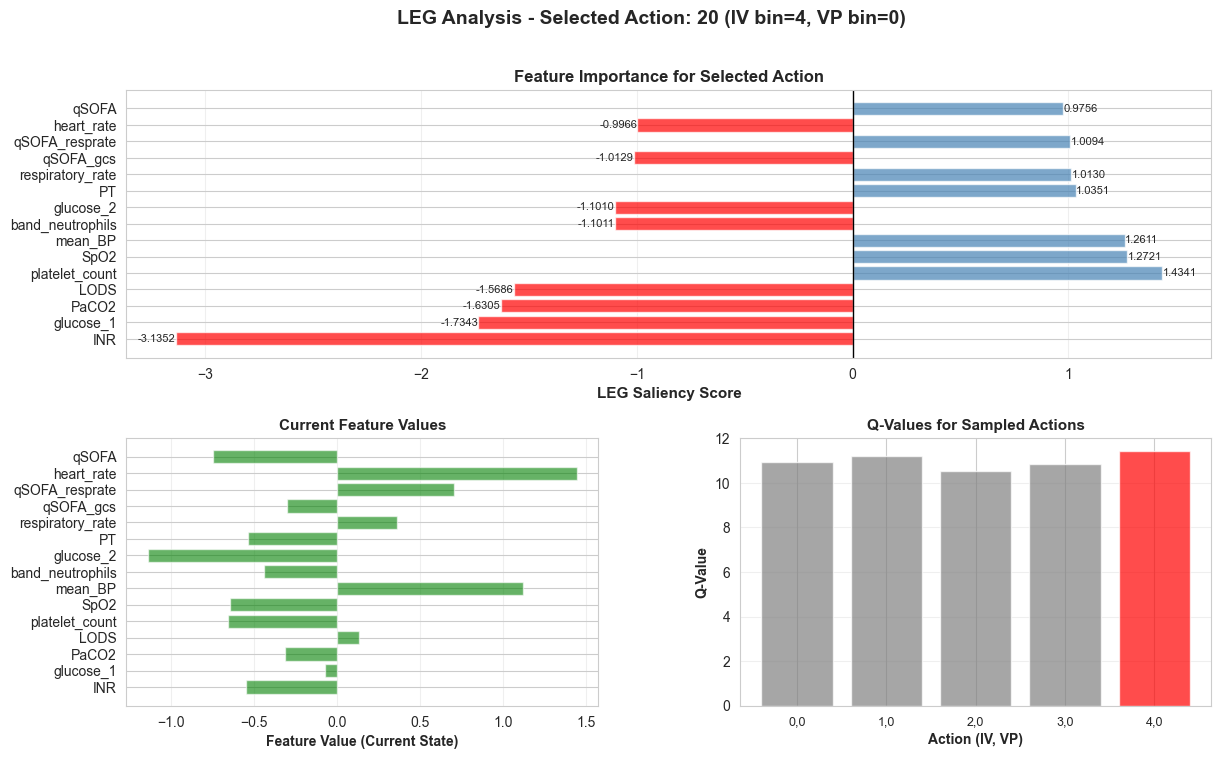

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_5.png


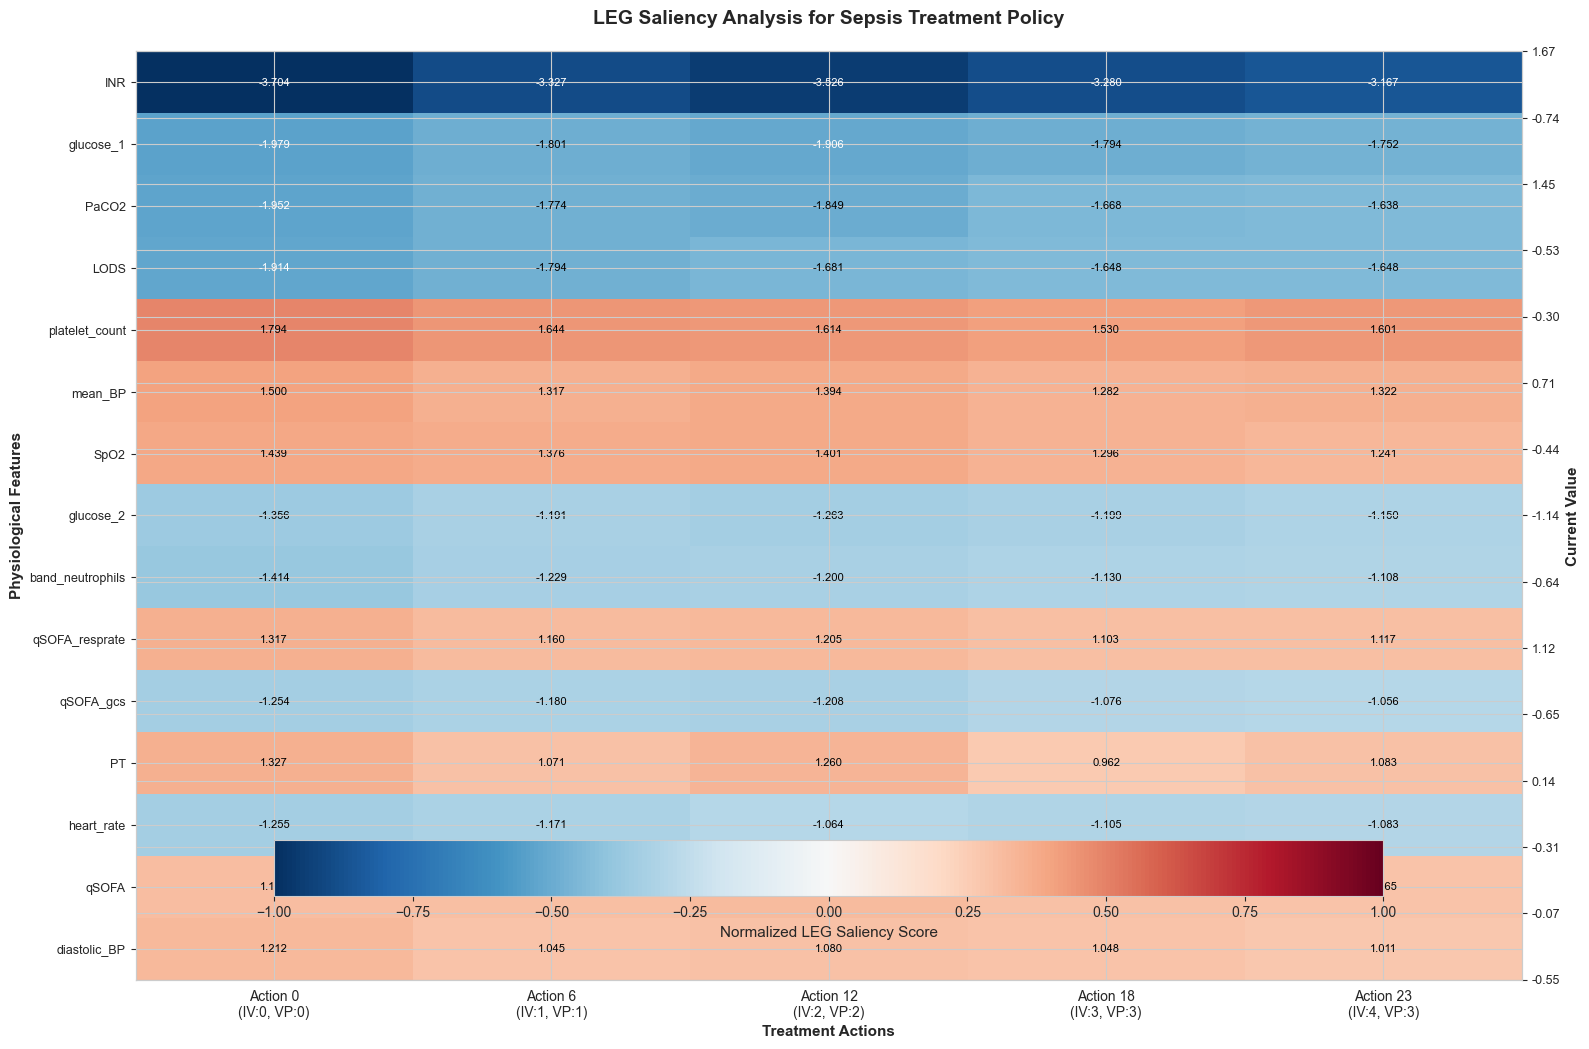


--- Analyzing State 7/10 (Episode 6, Timestep 4) ---
Analyzing 41 features...
Selected Action: 14 (IV=2, VP=4)
Top 5 Features:
  1. INR: score=-4.5092, value=-0.61
  2. glucose_1: score=-4.3259, value=-0.03
  3. lactate: score=3.4038, value=-0.13
  4. bilirubin: score=3.0184, value=-0.35
  5. respiratory_rate: score=2.5835, value=-0.12


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_6.png


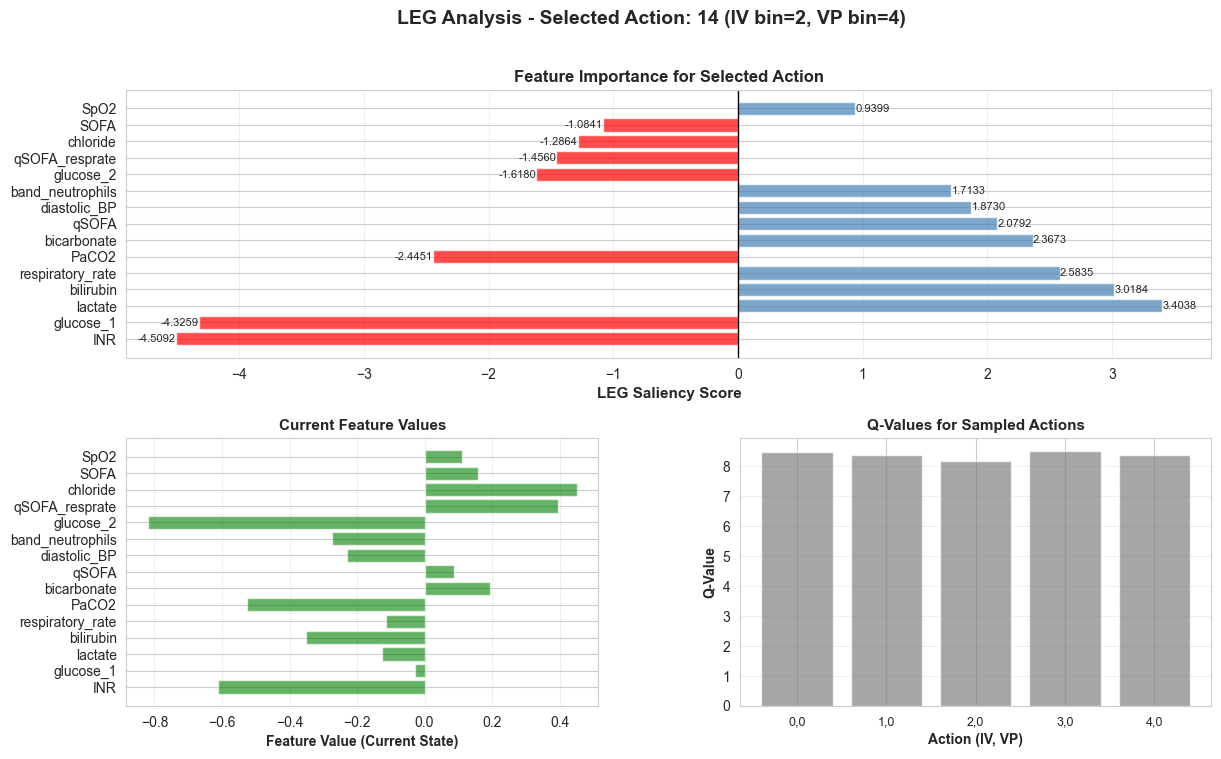

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_6.png


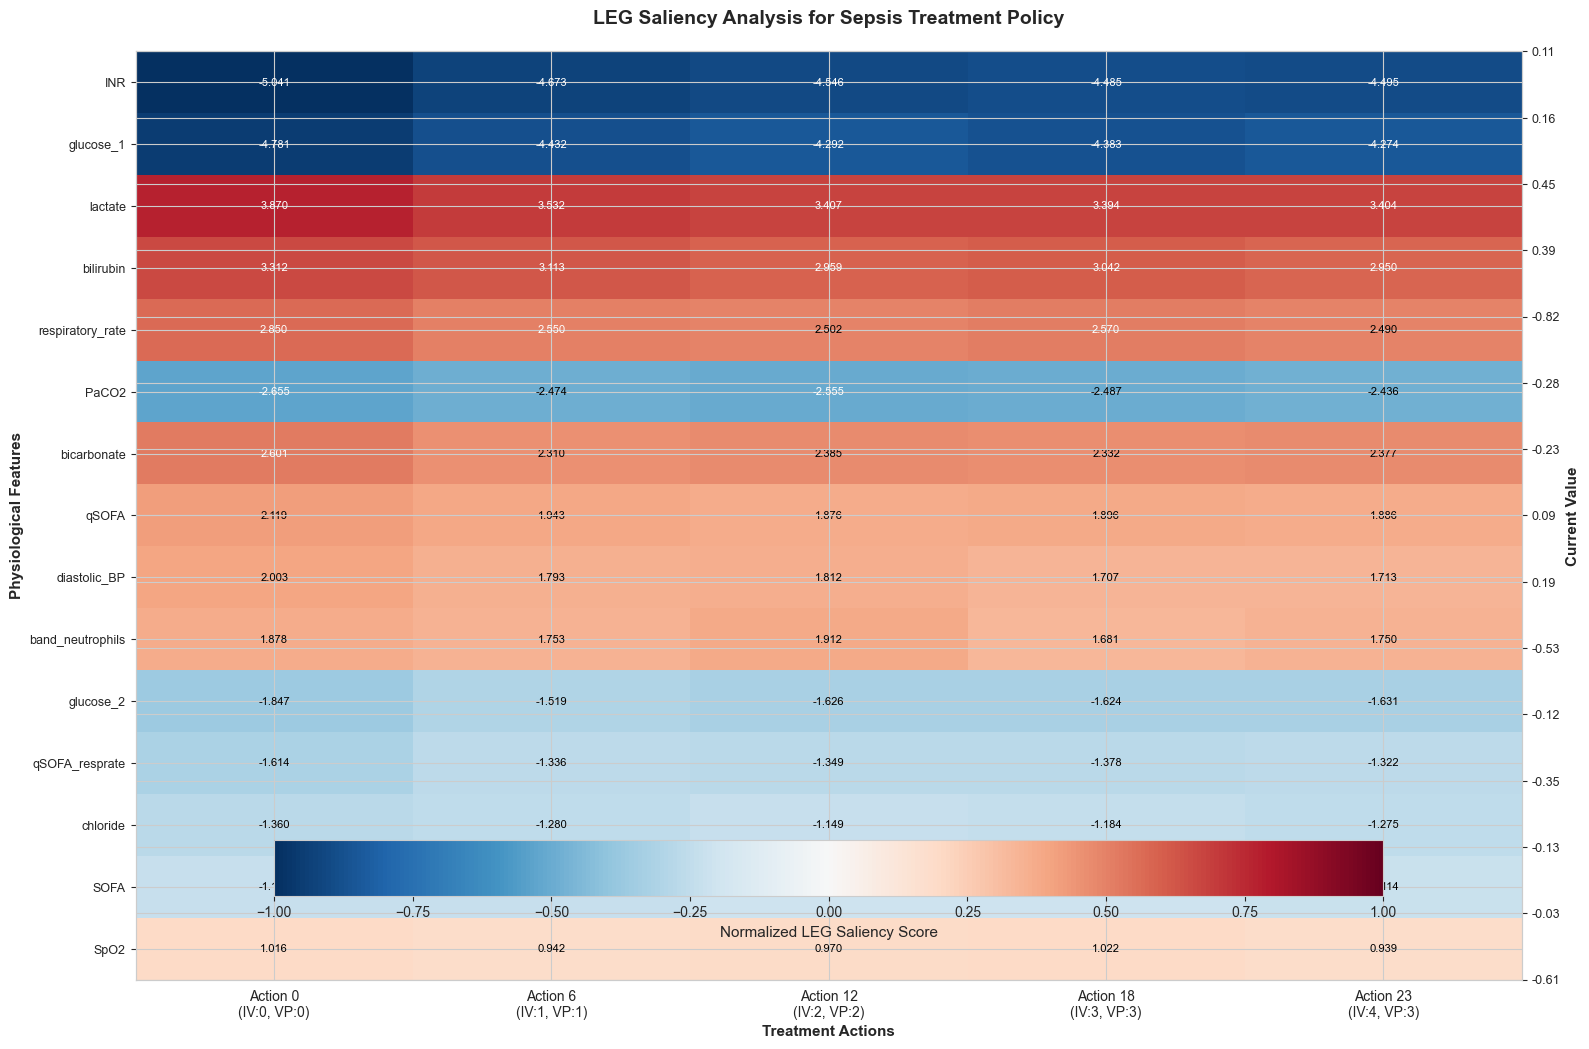


--- Analyzing State 8/10 (Episode 7, Timestep 5) ---
Analyzing 41 features...
Selected Action: 0 (IV=0, VP=0)
Top 5 Features:
  1. INR: score=-5.5129, value=-0.43
  2. lactate: score=4.9554, value=-0.01
  3. bilirubin: score=4.7894, value=-0.33
  4. glucose_1: score=-3.8711, value=-0.01
  5. respiratory_rate: score=2.6896, value=0.66


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_7.png


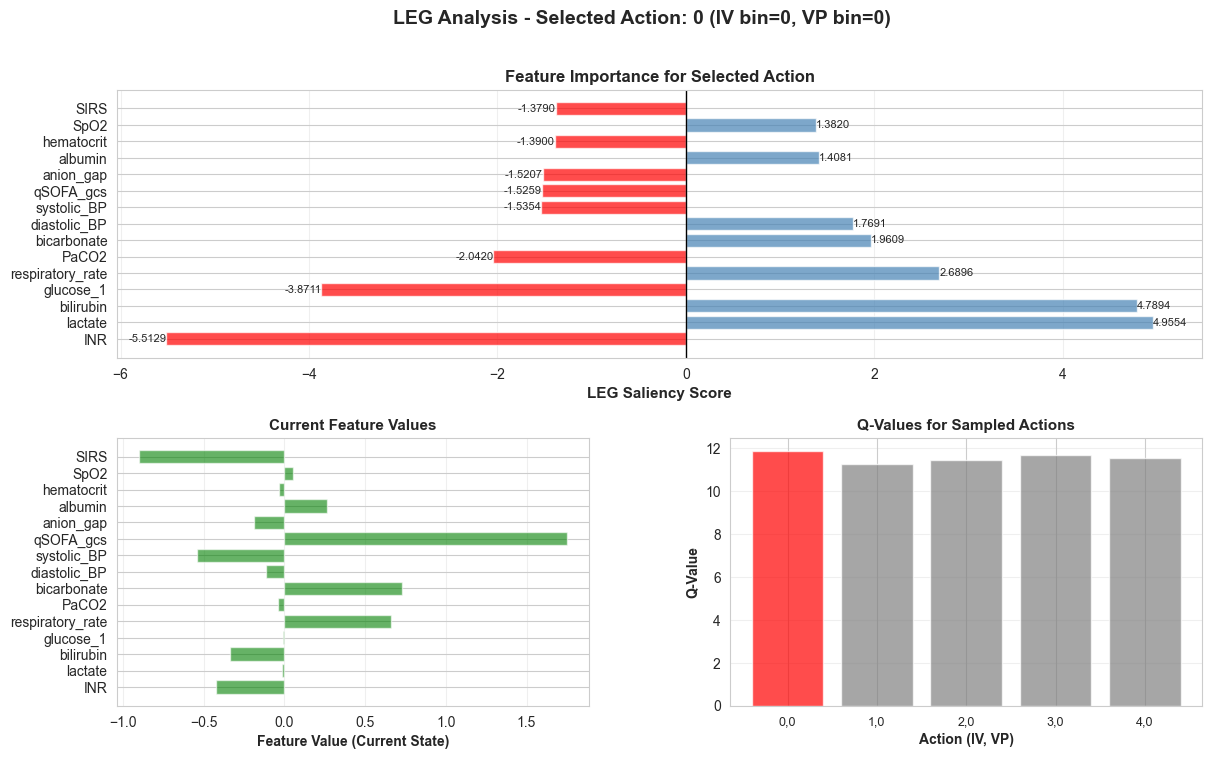

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_7.png


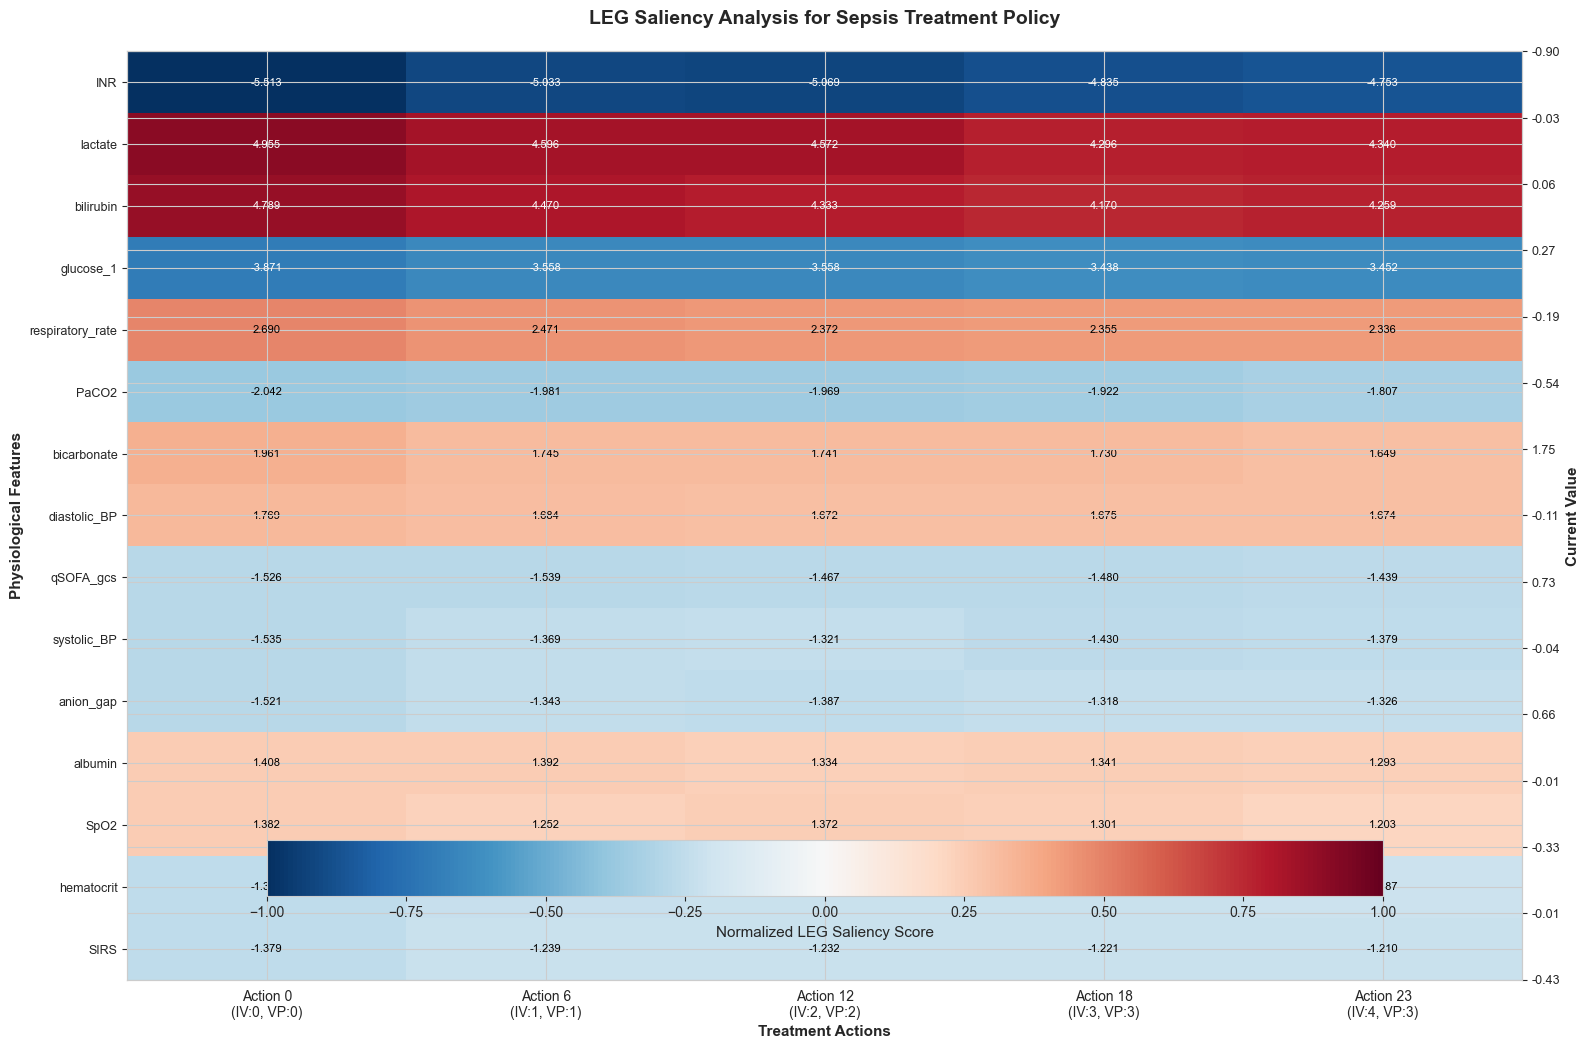


--- Analyzing State 9/10 (Episode 8, Timestep 5) ---
Analyzing 41 features...
Selected Action: 20 (IV=4, VP=0)
Top 5 Features:
  1. INR: score=-2.6459, value=-0.26
  2. glucose_1: score=-1.7692, value=-0.04
  3. LODS: score=-1.1912, value=1.49
  4. qSOFA_sysbp: score=1.1836, value=0.78
  5. qSOFA: score=1.1068, value=-0.90


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_8.png


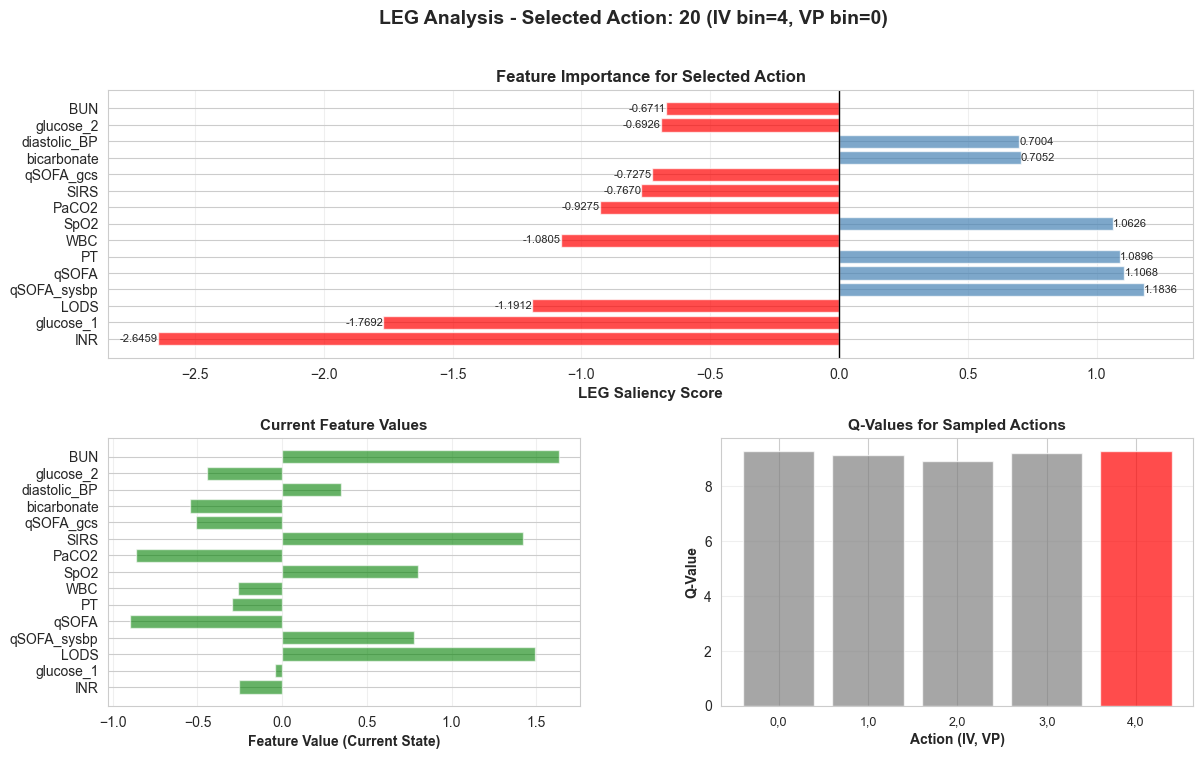

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_8.png


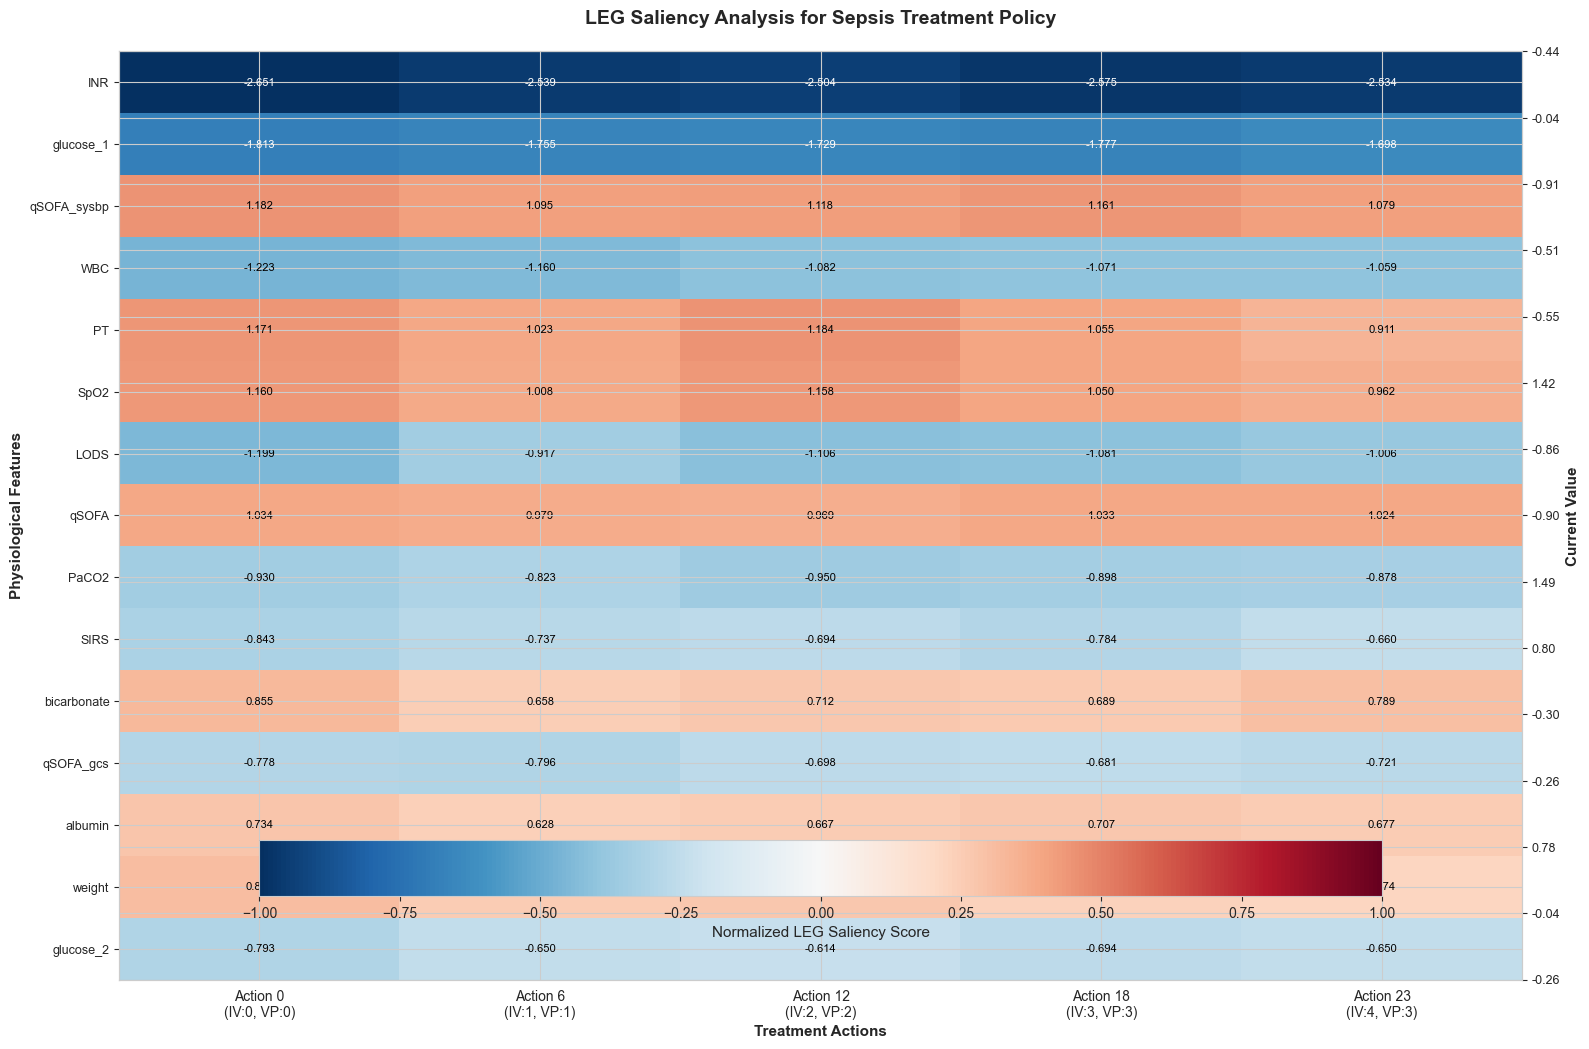


--- Analyzing State 10/10 (Episode 9, Timestep 4) ---
Analyzing 41 features...
Selected Action: 19 (IV=3, VP=4)
Top 5 Features:
  1. LODS: score=-3.3703, value=1.17
  2. SOFA: score=-3.3356, value=0.55
  3. elixhauser: score=-2.8825, value=-0.42
  4. albumin: score=2.4034, value=0.72
  5. band_neutrophils: score=-2.2636, value=-0.21


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/ddqn_online_res_model_final/analysis_state_9.png


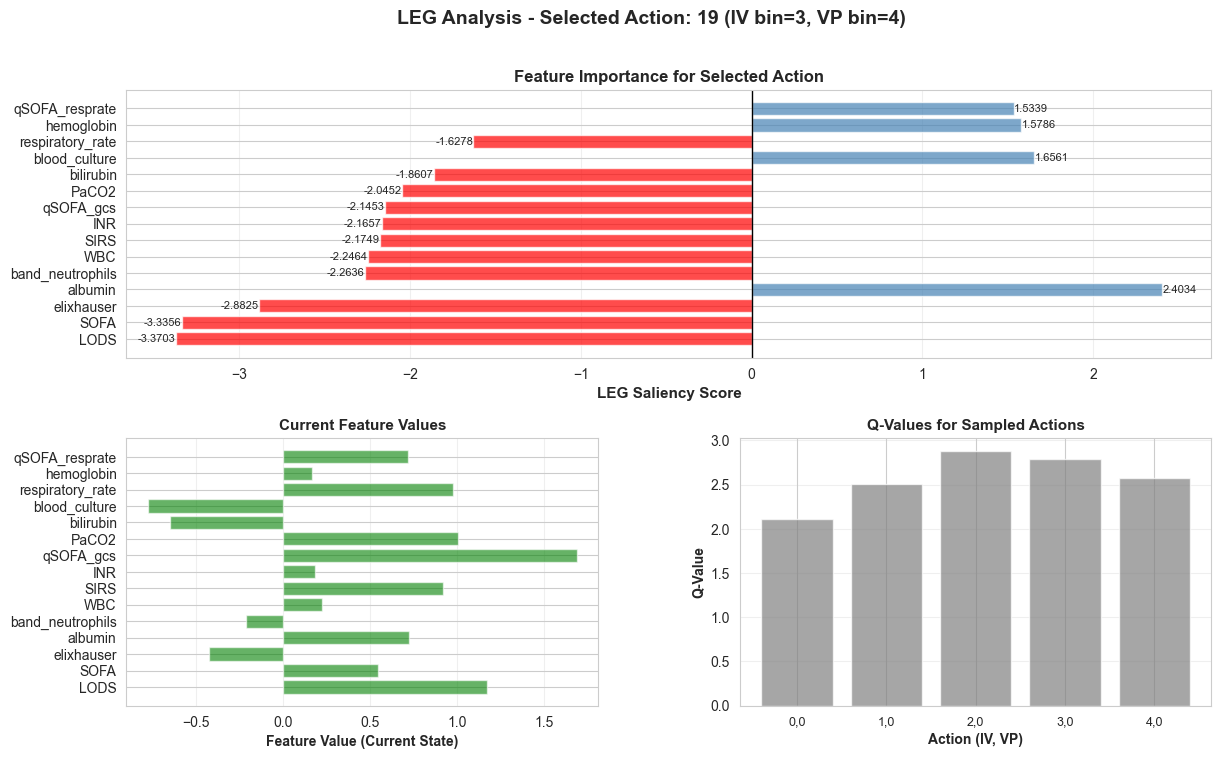

Saved saliency heatmap to ./sepsis_leg_analysis/ddqn_online_res_model_final/saliency_state_9.png


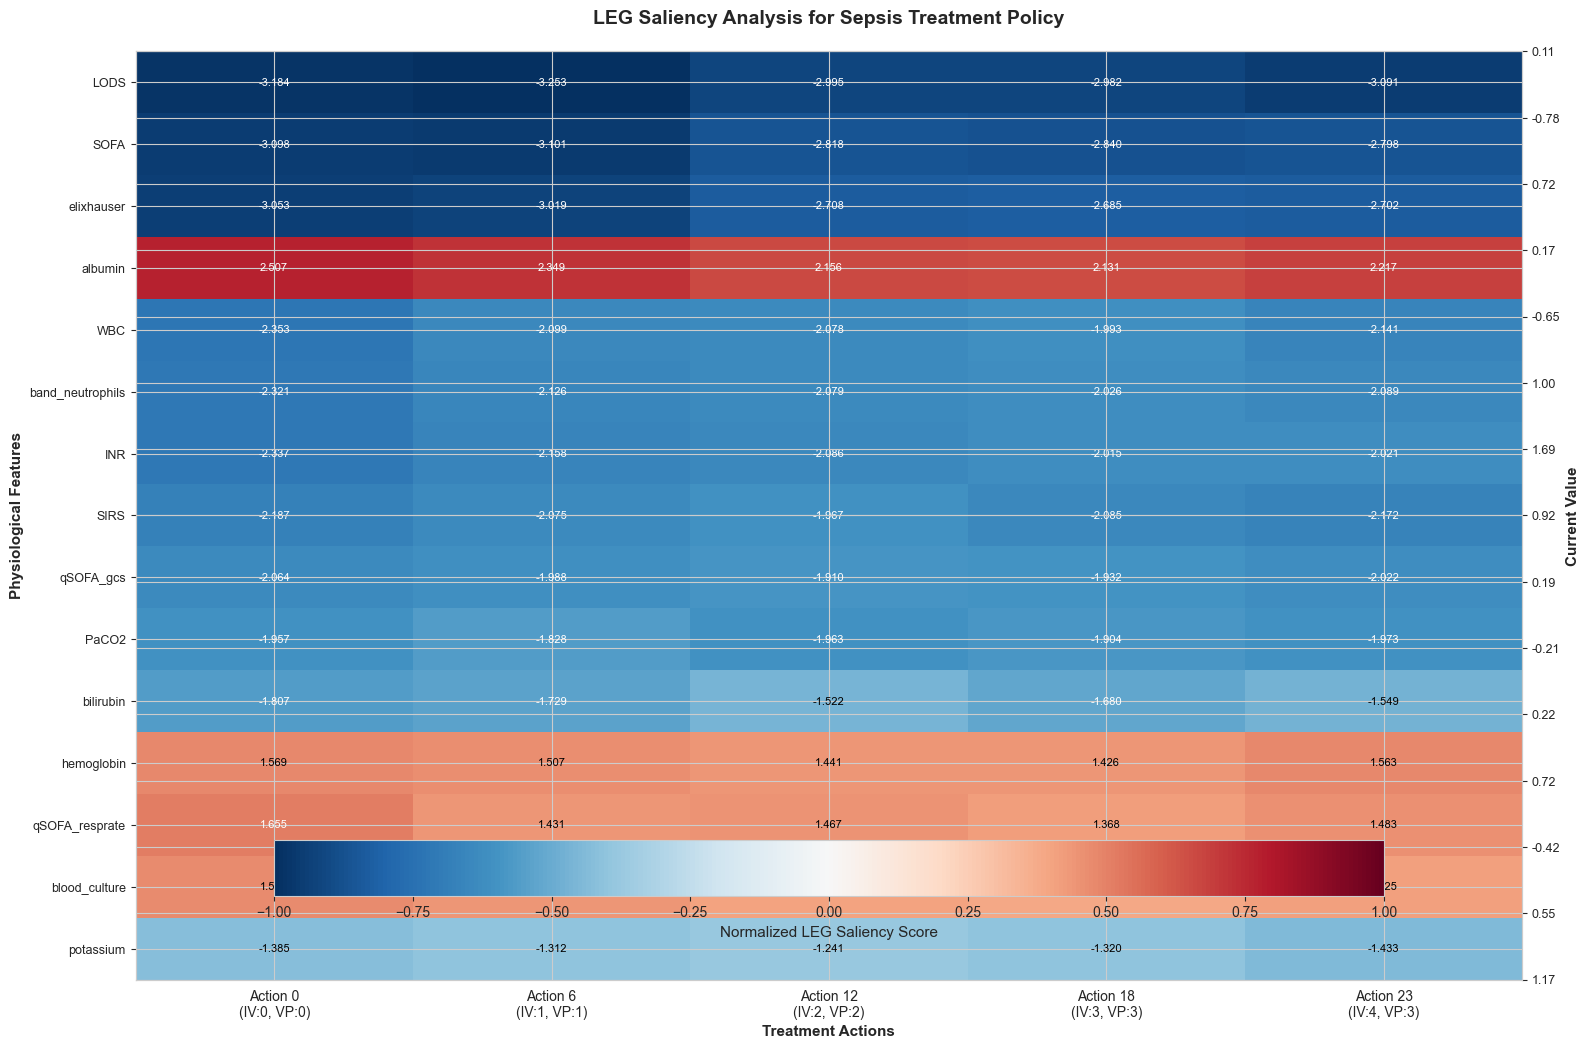


--- Analyzing Treatment Patterns ---
Saved treatment pattern to ./sepsis_leg_analysis/ddqn_online_res_model_final/treatment_patterns.png


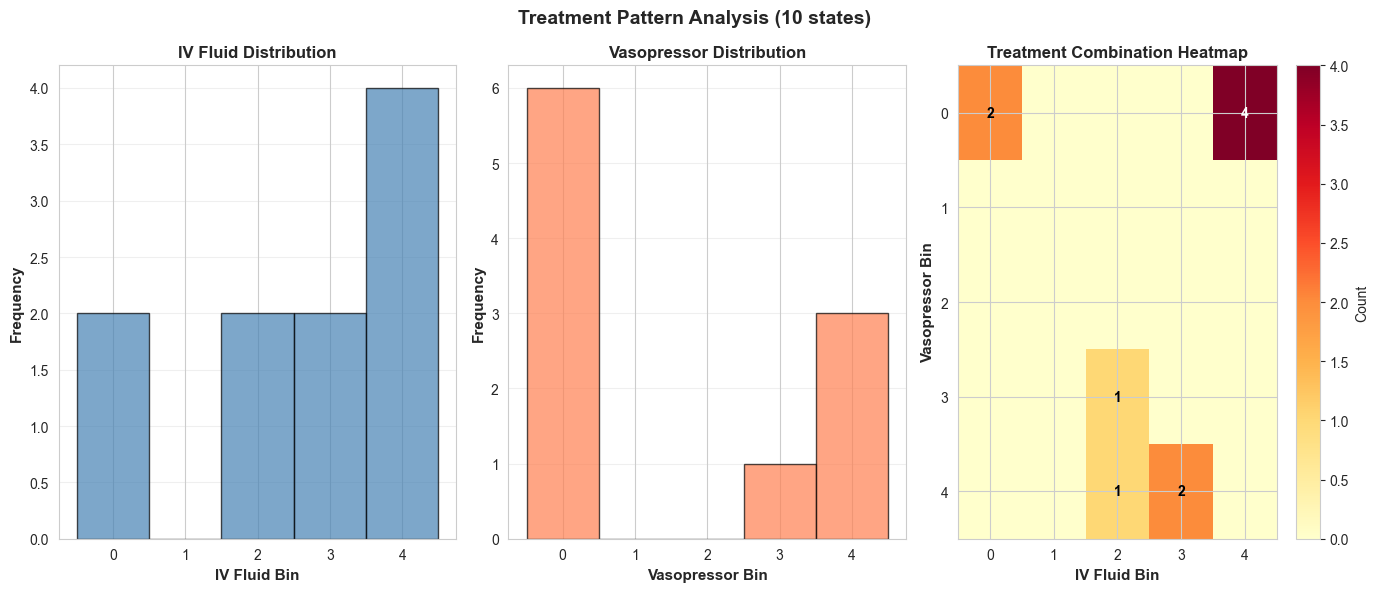


Analyzing Model: sac_online_model_final

Performing LEG Analysis

--- Analyzing State 1/10 (Episode 0, Timestep 4) ---
Analyzing 41 features...
Selected Action: 16 (IV=3, VP=1)
Top 5 Features:
  1. INR: score=-1.5182, value=-0.54
  2. bilirubin: score=0.9279, value=-0.21
  3. lactate: score=0.7110, value=0.20
  4. qSOFA: score=0.6815, value=1.71
  5. bicarbonate: score=0.6589, value=-1.04


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_0.png


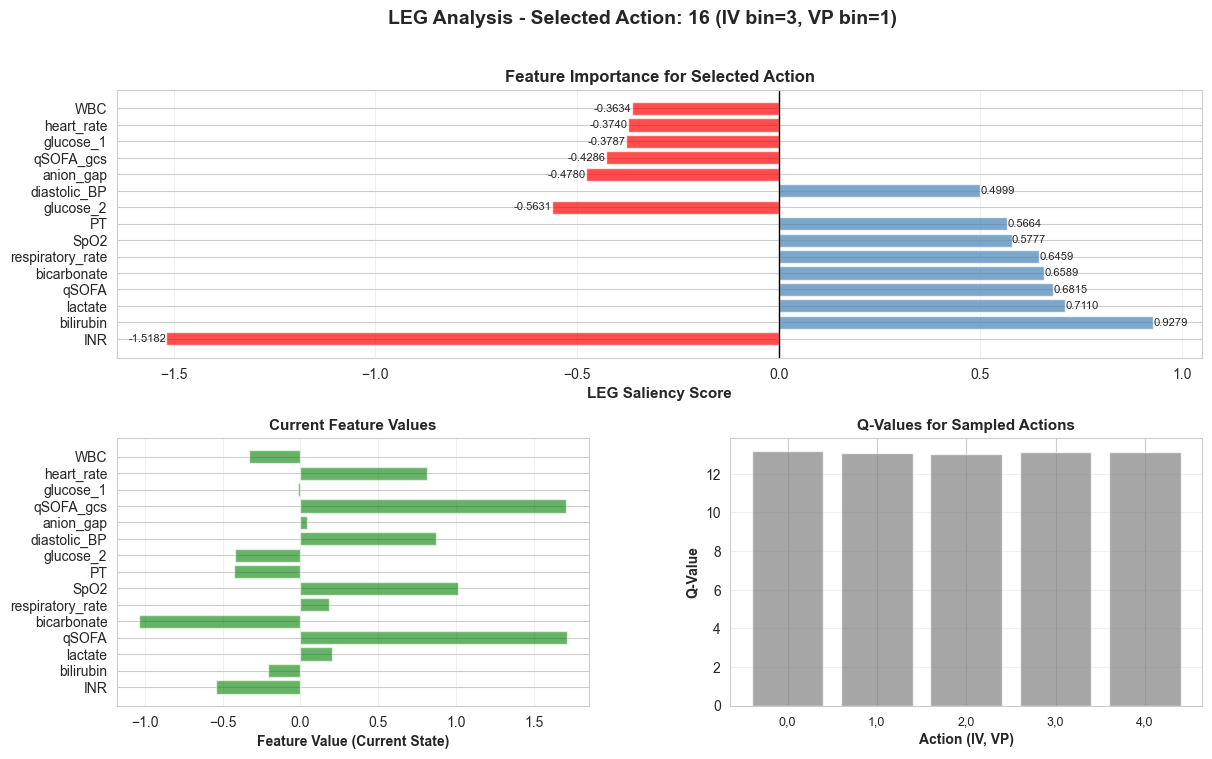

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_0.png


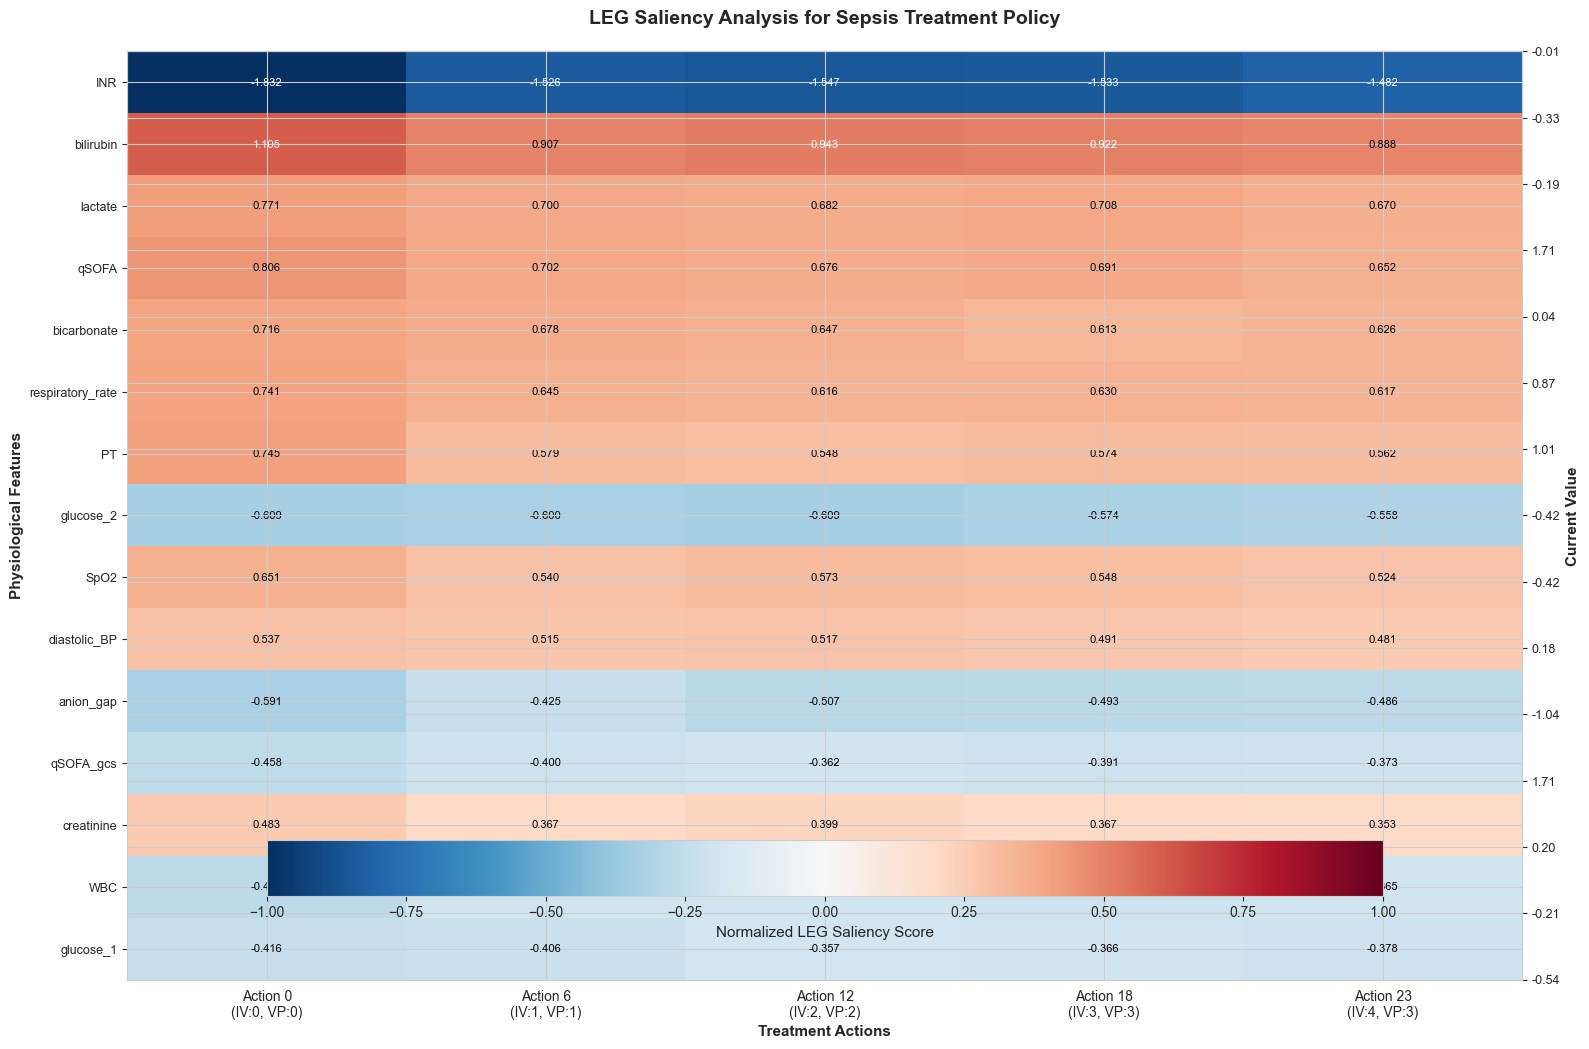


--- Analyzing State 2/10 (Episode 1, Timestep 5) ---
Analyzing 41 features...
Selected Action: 16 (IV=3, VP=1)
Top 5 Features:
  1. INR: score=-0.7895, value=-0.34
  2. qSOFA_sysbp: score=0.5535, value=0.65
  3. lactate: score=0.5535, value=0.39
  4. glucose_1: score=-0.5064, value=-0.01
  5. diastolic_BP: score=0.4921, value=-0.39


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_1.png


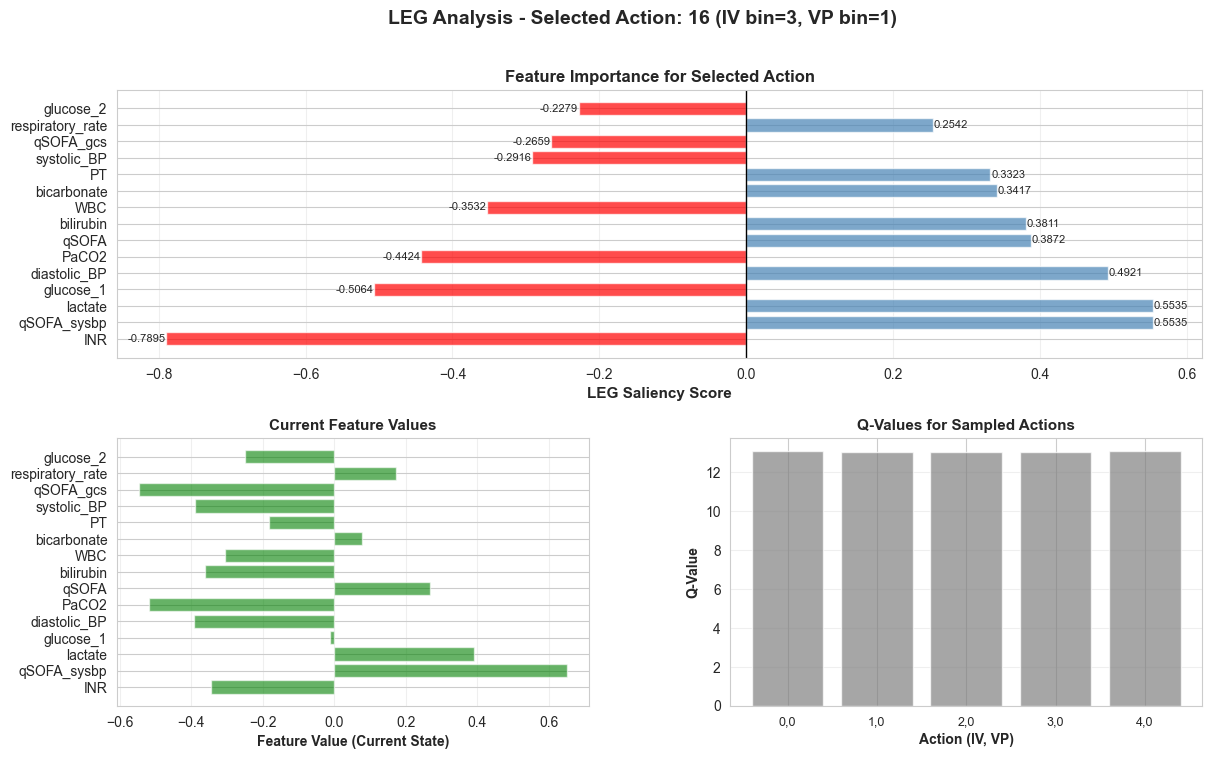

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_1.png


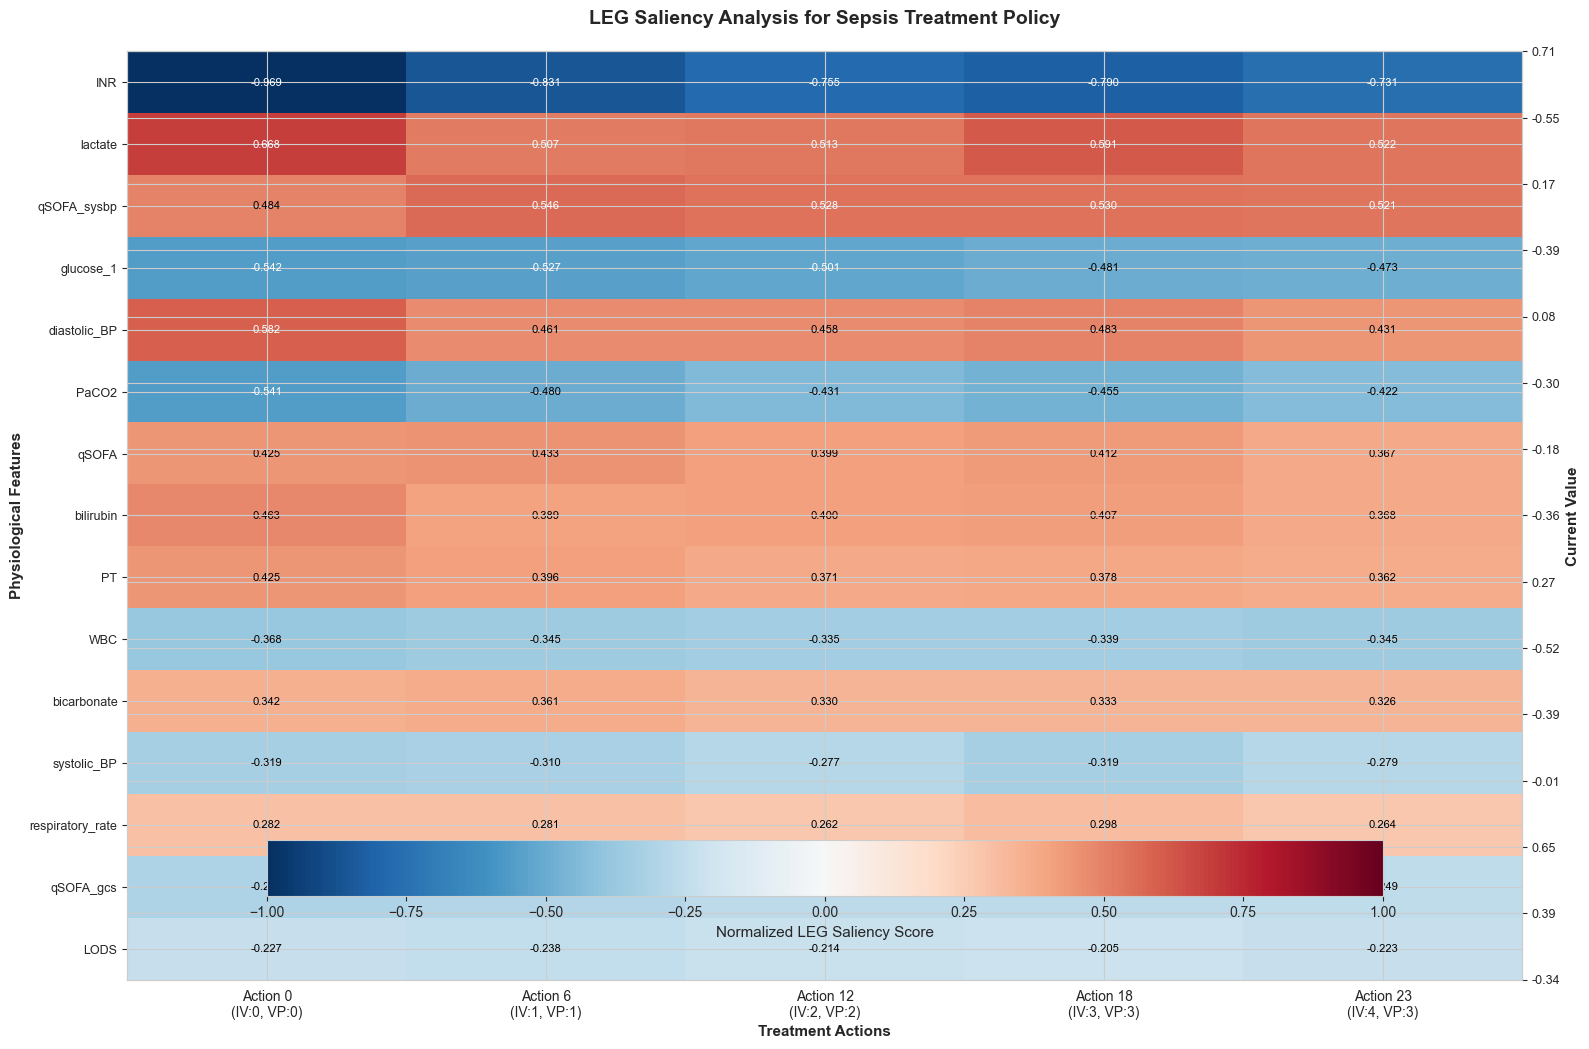


--- Analyzing State 3/10 (Episode 2, Timestep 4) ---
Analyzing 41 features...
Selected Action: 17 (IV=3, VP=2)
Top 5 Features:
  1. INR: score=-0.6003, value=0.47
  2. glucose_1: score=-0.5931, value=0.02
  3. albumin: score=0.5458, value=-0.03
  4. WBC: score=-0.4592, value=-1.15
  5. hematocrit: score=-0.4178, value=0.92


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_2.png


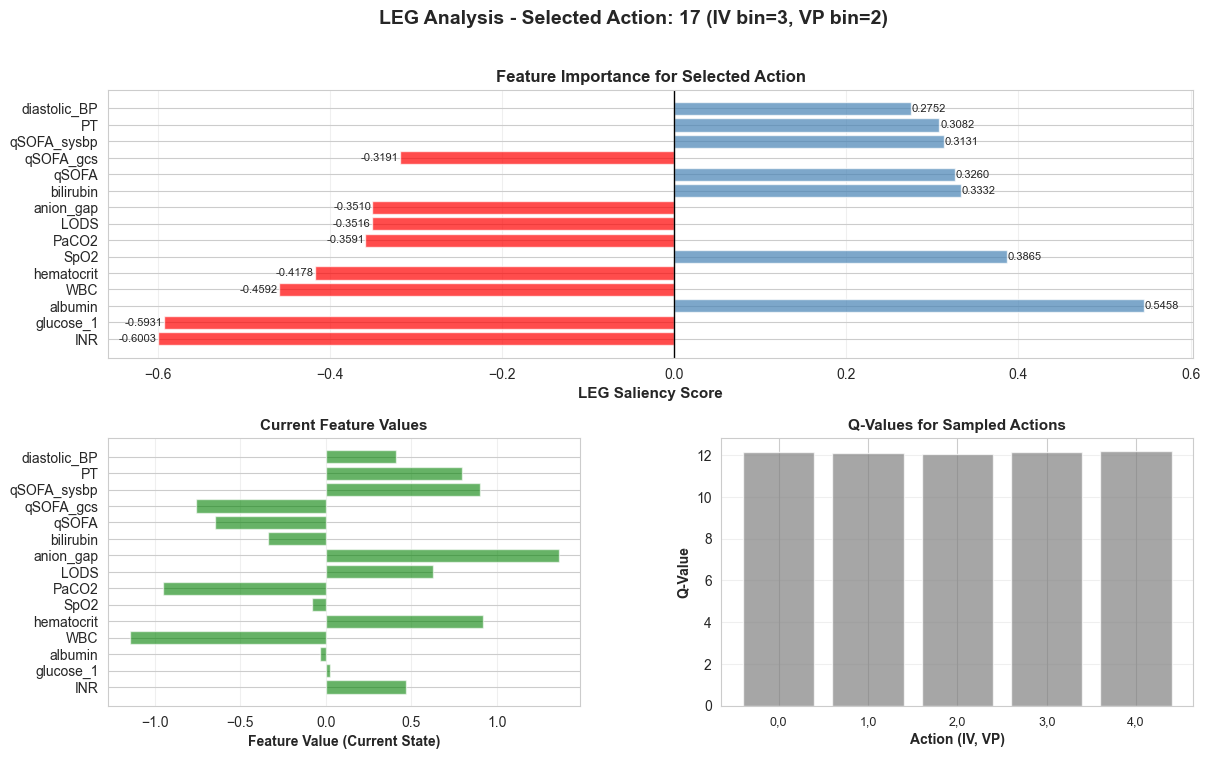

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_2.png


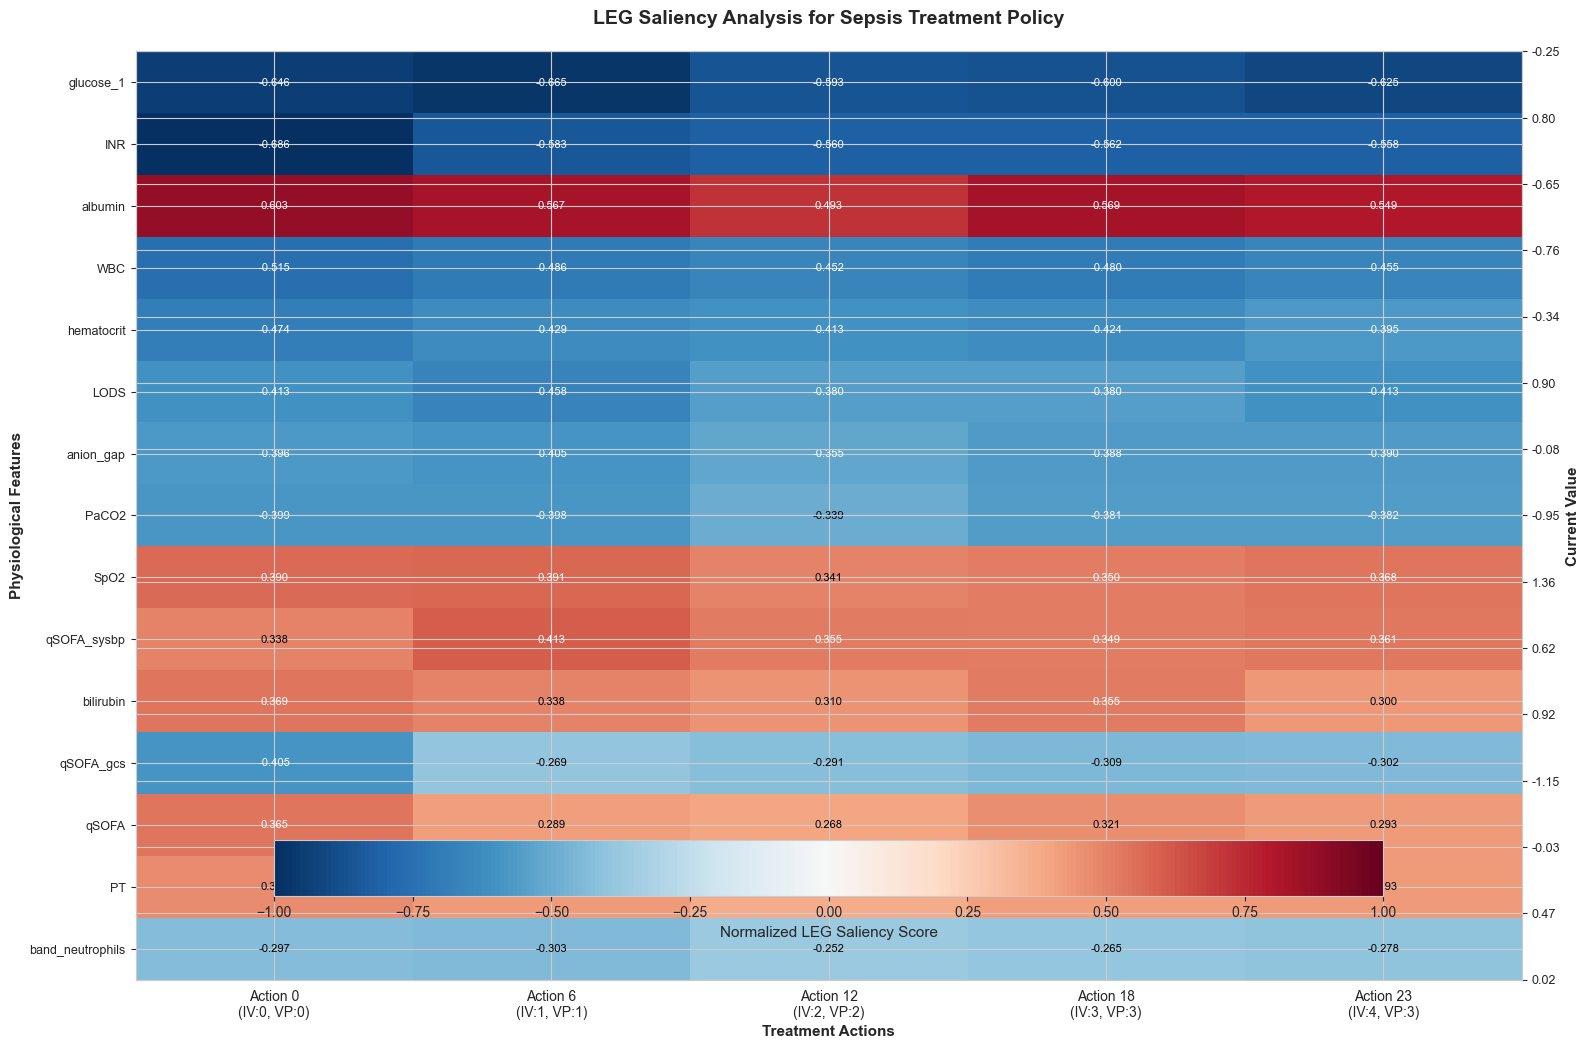


--- Analyzing State 4/10 (Episode 3, Timestep 5) ---
Analyzing 41 features...
Selected Action: 0 (IV=0, VP=0)
Top 5 Features:
  1. INR: score=-1.1946, value=0.56
  2. PT: score=0.9637, value=1.09
  3. respiratory_rate: score=0.9120, value=-0.09
  4. hemoglobin: score=0.7656, value=-0.62
  5. lactate: score=0.7604, value=0.50


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_3.png


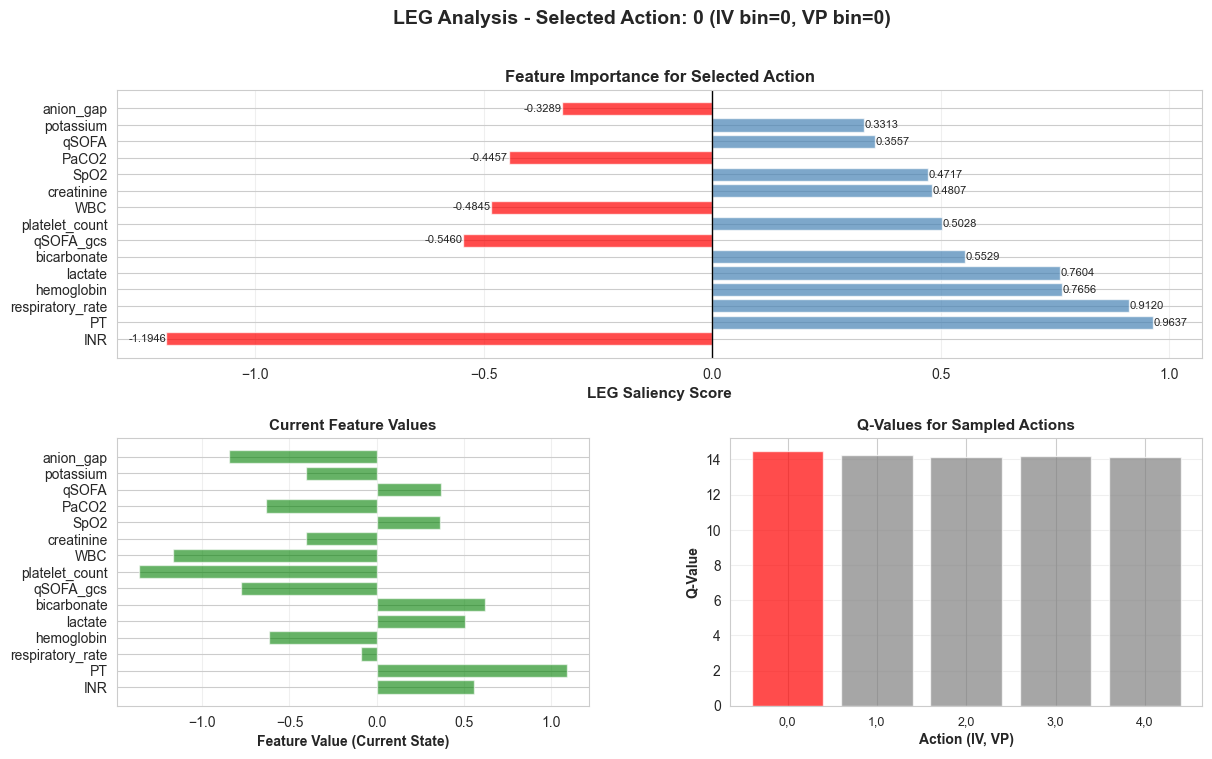

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_3.png



--- Analyzing State 5/10 (Episode 4, Timestep 4) ---
Analyzing 41 features...
Selected Action: 2 (IV=0, VP=2)
Top 5 Features:
  1. INR: score=-1.0446, value=-0.23
  2. glucose_1: score=-0.5767, value=0.02
  3. diastolic_BP: score=0.5685, value=-0.48
  4. albumin: score=0.5674, value=-0.87
  5. heart_rate: score=-0.5296, value=0.29


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_4.png


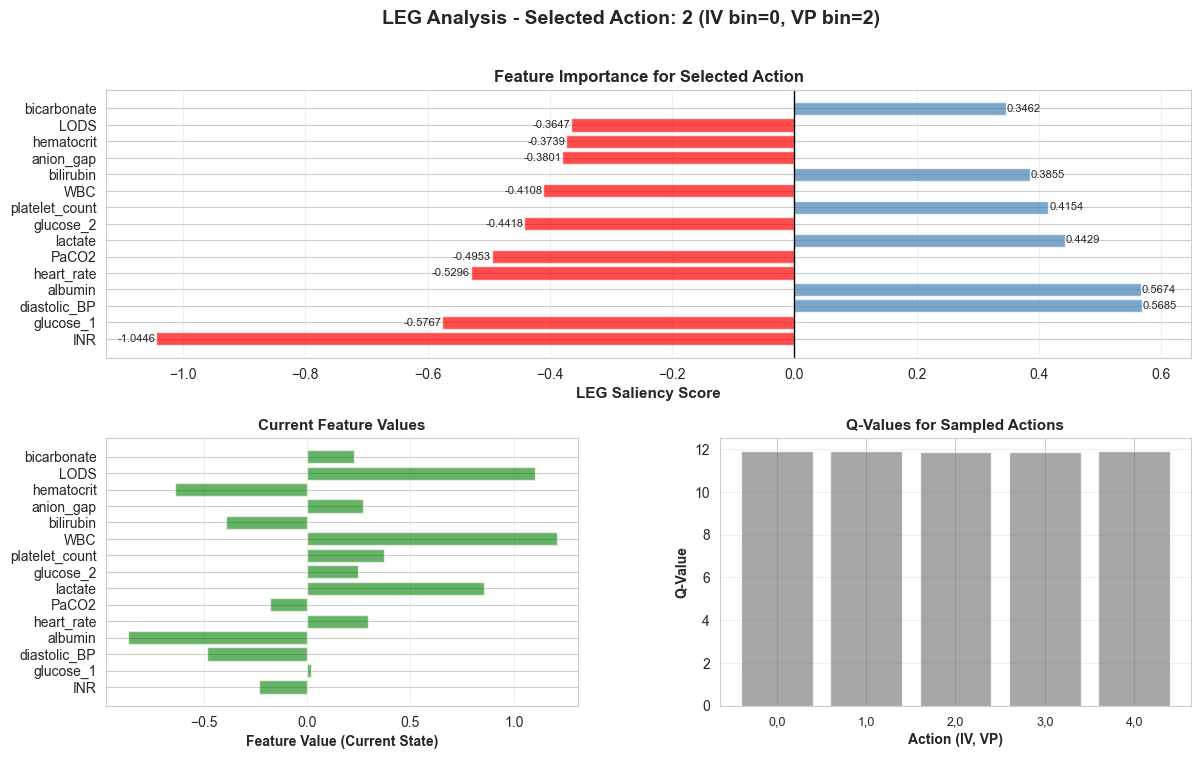

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_4.png


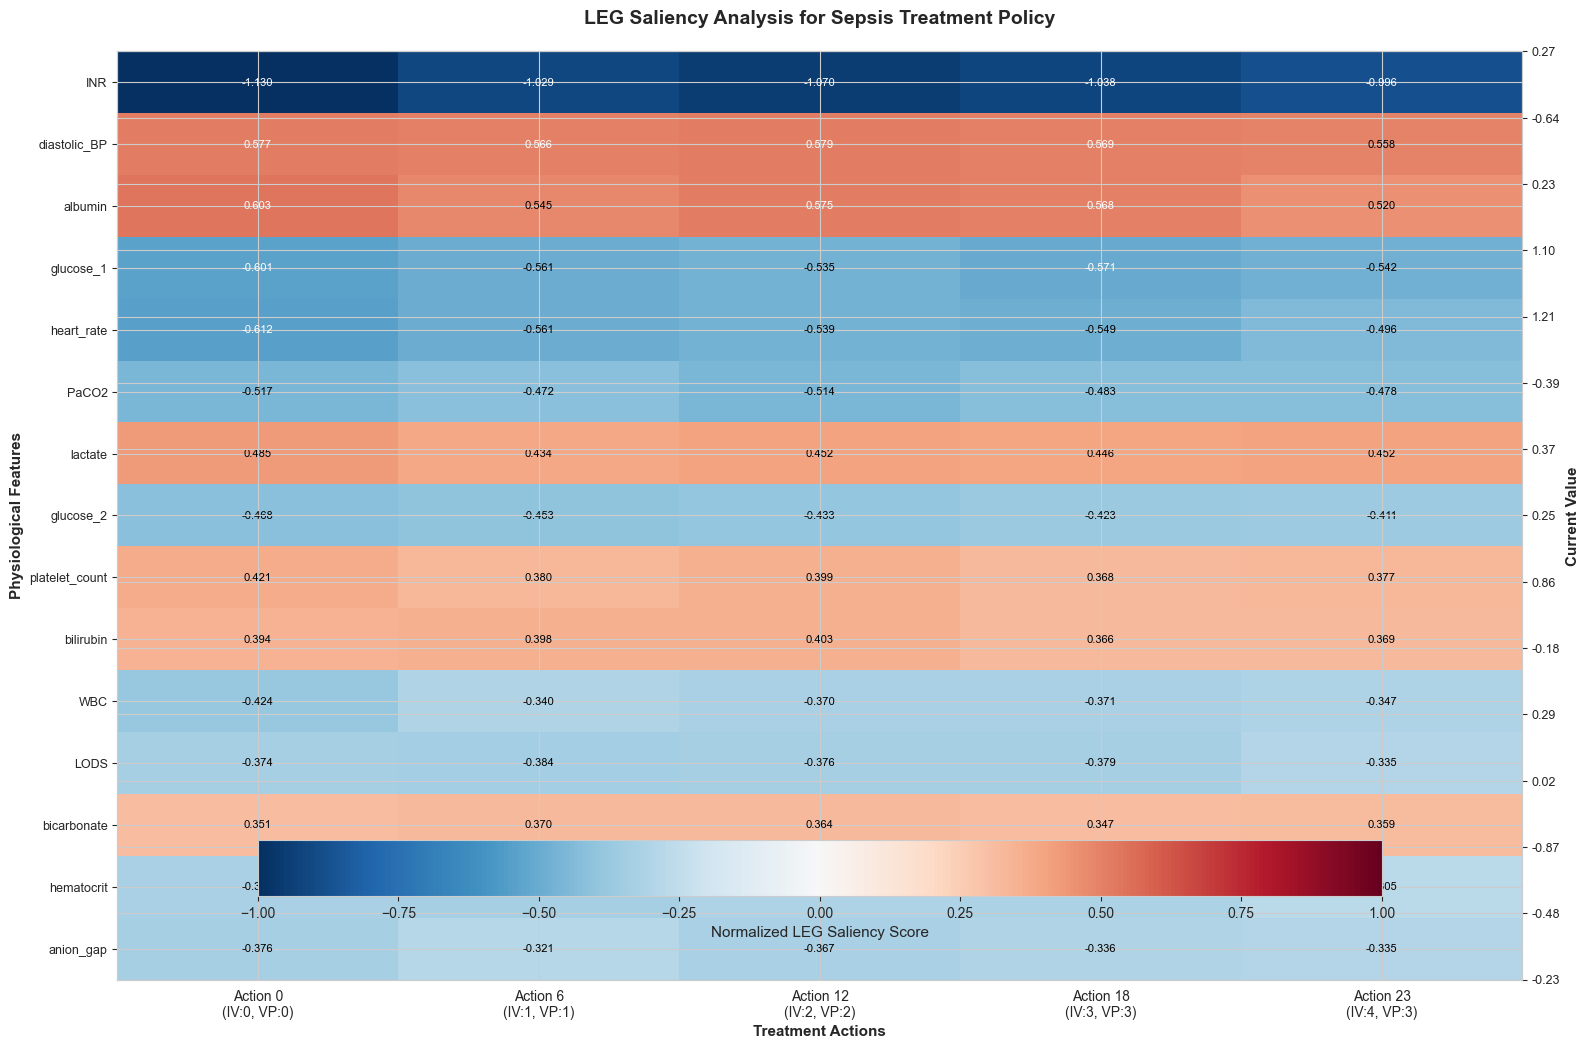


--- Analyzing State 6/10 (Episode 5, Timestep 5) ---
Analyzing 41 features...
Selected Action: 1 (IV=0, VP=1)
Top 5 Features:
  1. INR: score=-1.7693, value=-0.55
  2. anion_gap: score=-1.2316, value=0.54
  3. WBC: score=-1.2097, value=-0.06
  4. band_neutrophils: score=-1.1468, value=-0.44
  5. LODS: score=-1.1052, value=0.14


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_5.png


Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_5.png



--- Analyzing State 7/10 (Episode 6, Timestep 4) ---
Analyzing 41 features...
Selected Action: 16 (IV=3, VP=1)
Top 5 Features:
  1. INR: score=-1.7687, value=-0.61
  2. lactate: score=1.2540, value=-0.13
  3. bilirubin: score=1.1110, value=-0.35
  4. respiratory_rate: score=1.0197, value=-0.12
  5. PaCO2: score=-0.8168, value=-0.53


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_6.png


Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_6.png



--- Analyzing State 8/10 (Episode 7, Timestep 5) ---
Analyzing 41 features...
Selected Action: 1 (IV=0, VP=1)
Top 5 Features:
  1. INR: score=-1.7502, value=-0.43
  2. bilirubin: score=1.4726, value=-0.33
  3. lactate: score=1.2484, value=-0.01
  4. SpO2: score=1.0398, value=0.06
  5. PT: score=1.0104, value=-0.21


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_7.png


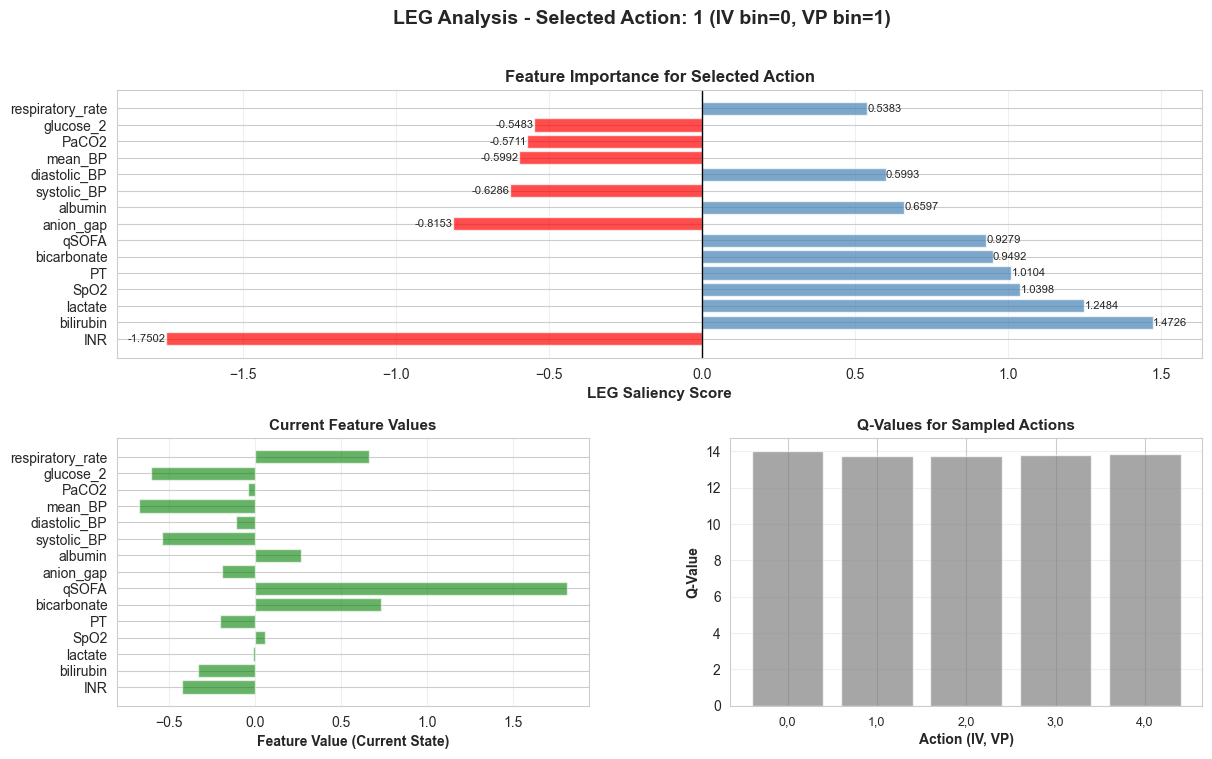

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_7.png


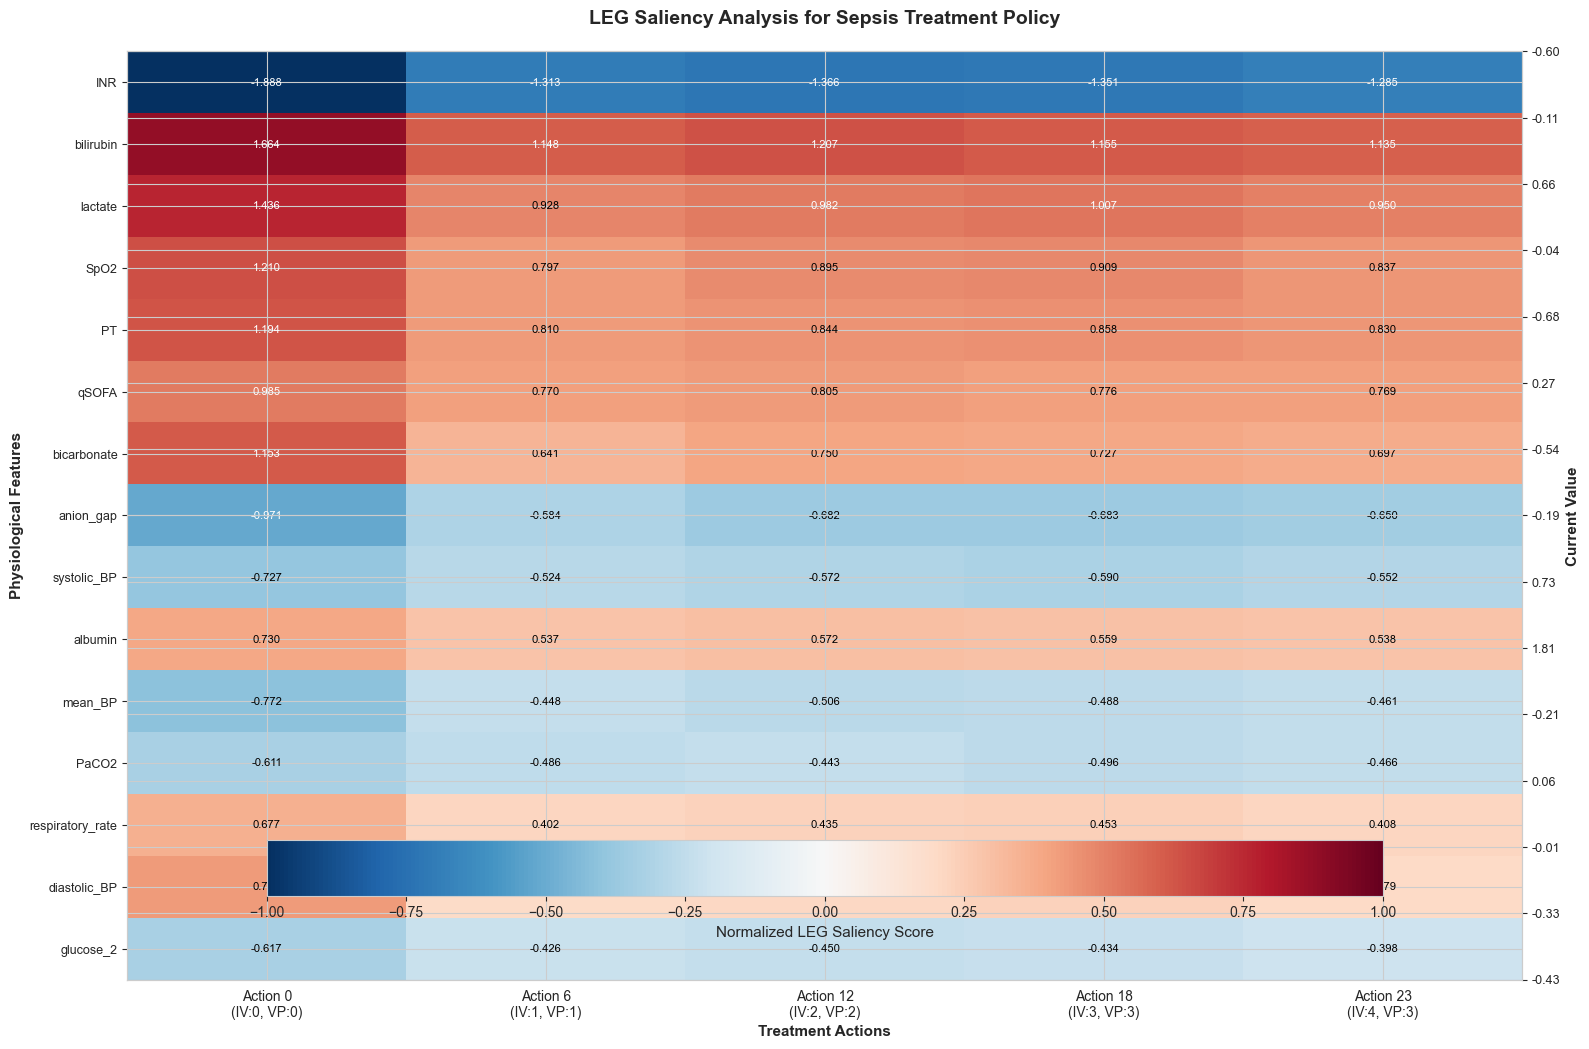


--- Analyzing State 9/10 (Episode 8, Timestep 5) ---
Analyzing 41 features...
Selected Action: 17 (IV=3, VP=2)
Top 5 Features:
  1. INR: score=-0.5924, value=-0.26
  2. lactate: score=0.4382, value=0.67
  3. glucose_1: score=-0.3909, value=-0.04
  4. albumin: score=0.3565, value=-0.91
  5. diastolic_BP: score=0.3338, value=0.35


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_8.png


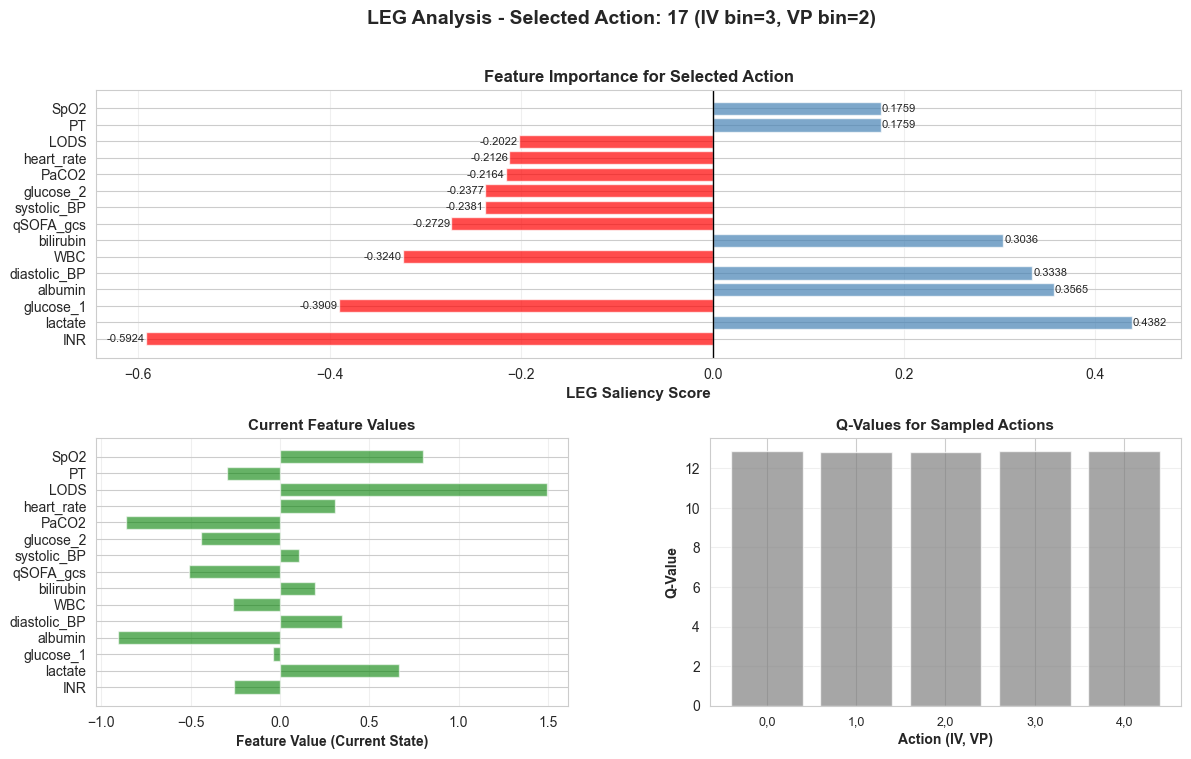

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_8.png


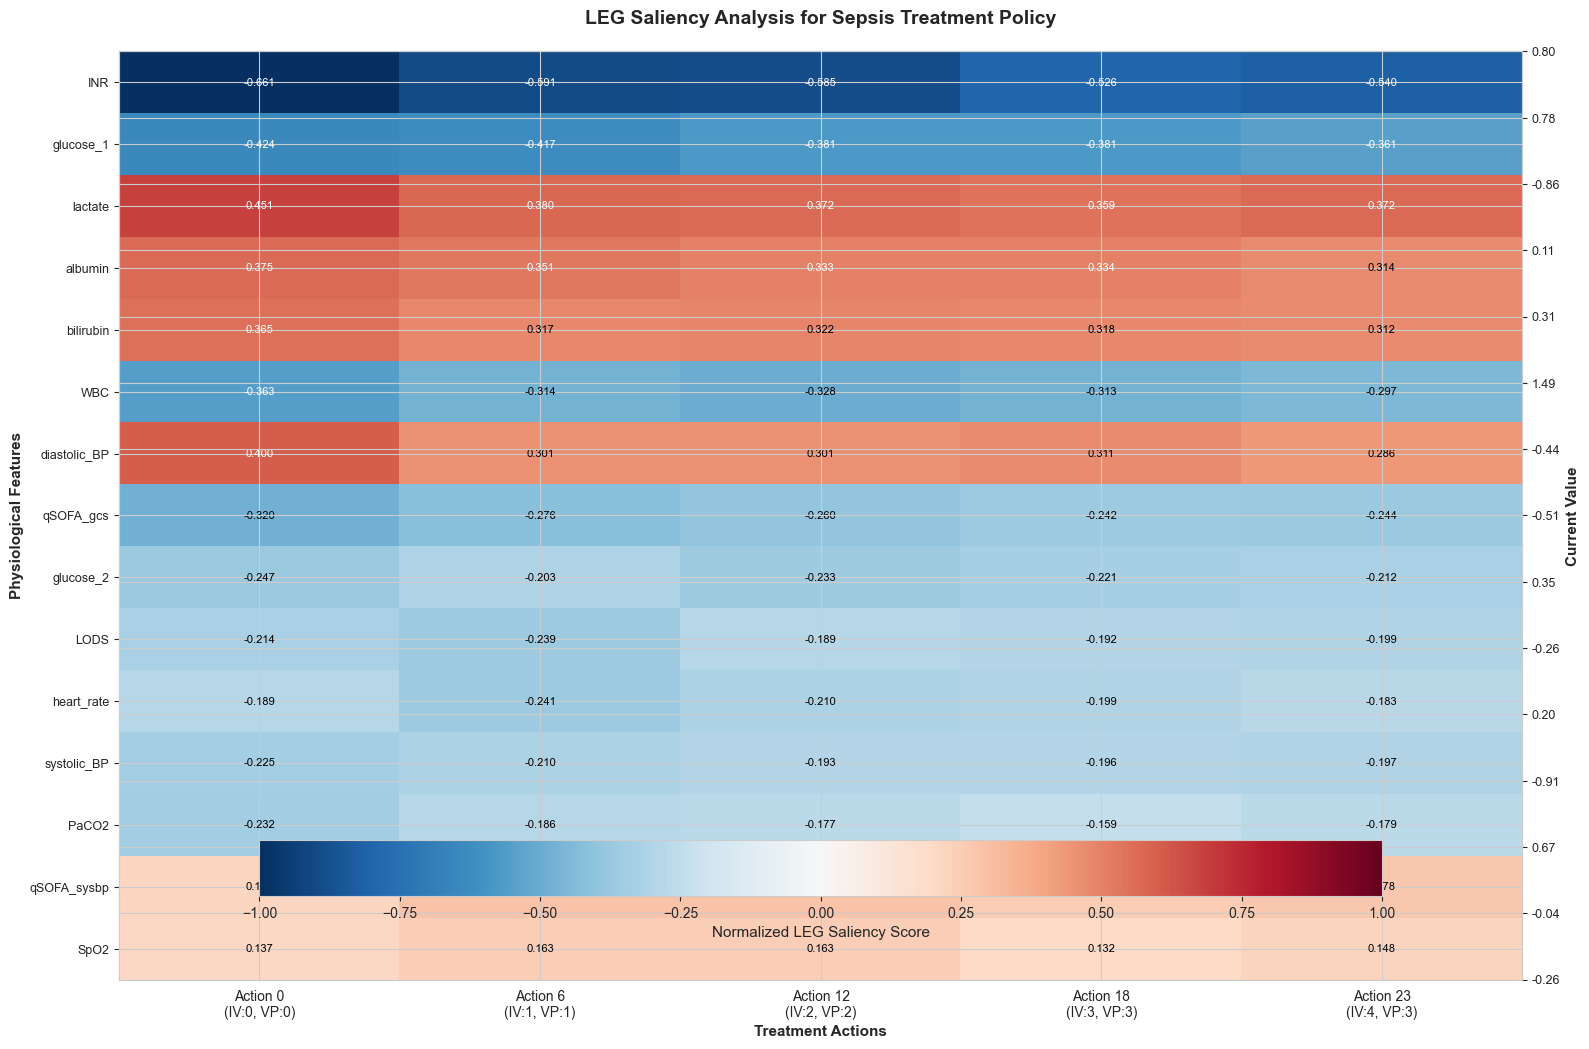


--- Analyzing State 10/10 (Episode 9, Timestep 4) ---
Analyzing 41 features...
Selected Action: 23 (IV=4, VP=3)
Top 5 Features:
  1. LODS: score=-1.3413, value=1.17
  2. glucose_1: score=-1.1289, value=0.03
  3. elixhauser: score=-0.7297, value=-0.42
  4. albumin: score=0.7043, value=0.72
  5. SOFA: score=-0.7007, value=0.55


C:\Users\liuji\AppData\Local\Temp\ipykernel_7904\3687775021.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved detailed analysis to ./sepsis_leg_analysis/sac_online_model_final/analysis_state_9.png


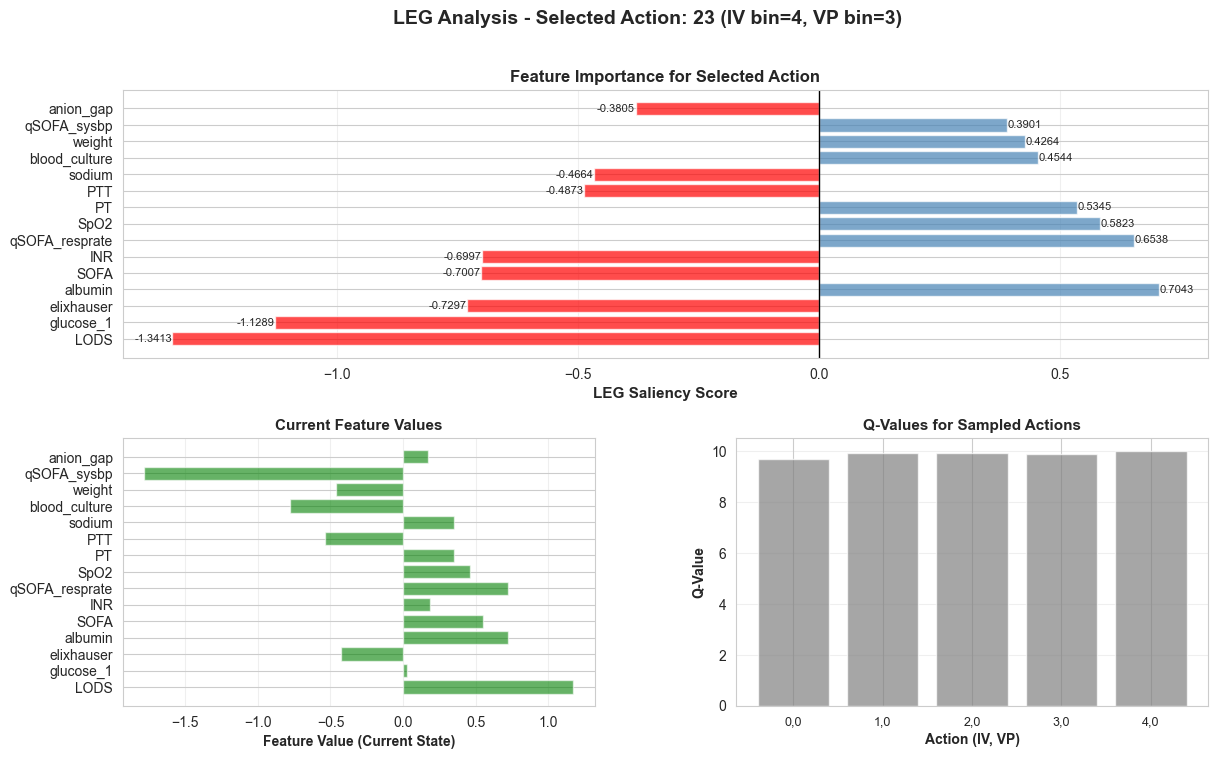

Saved saliency heatmap to ./sepsis_leg_analysis/sac_online_model_final/saliency_state_9.png


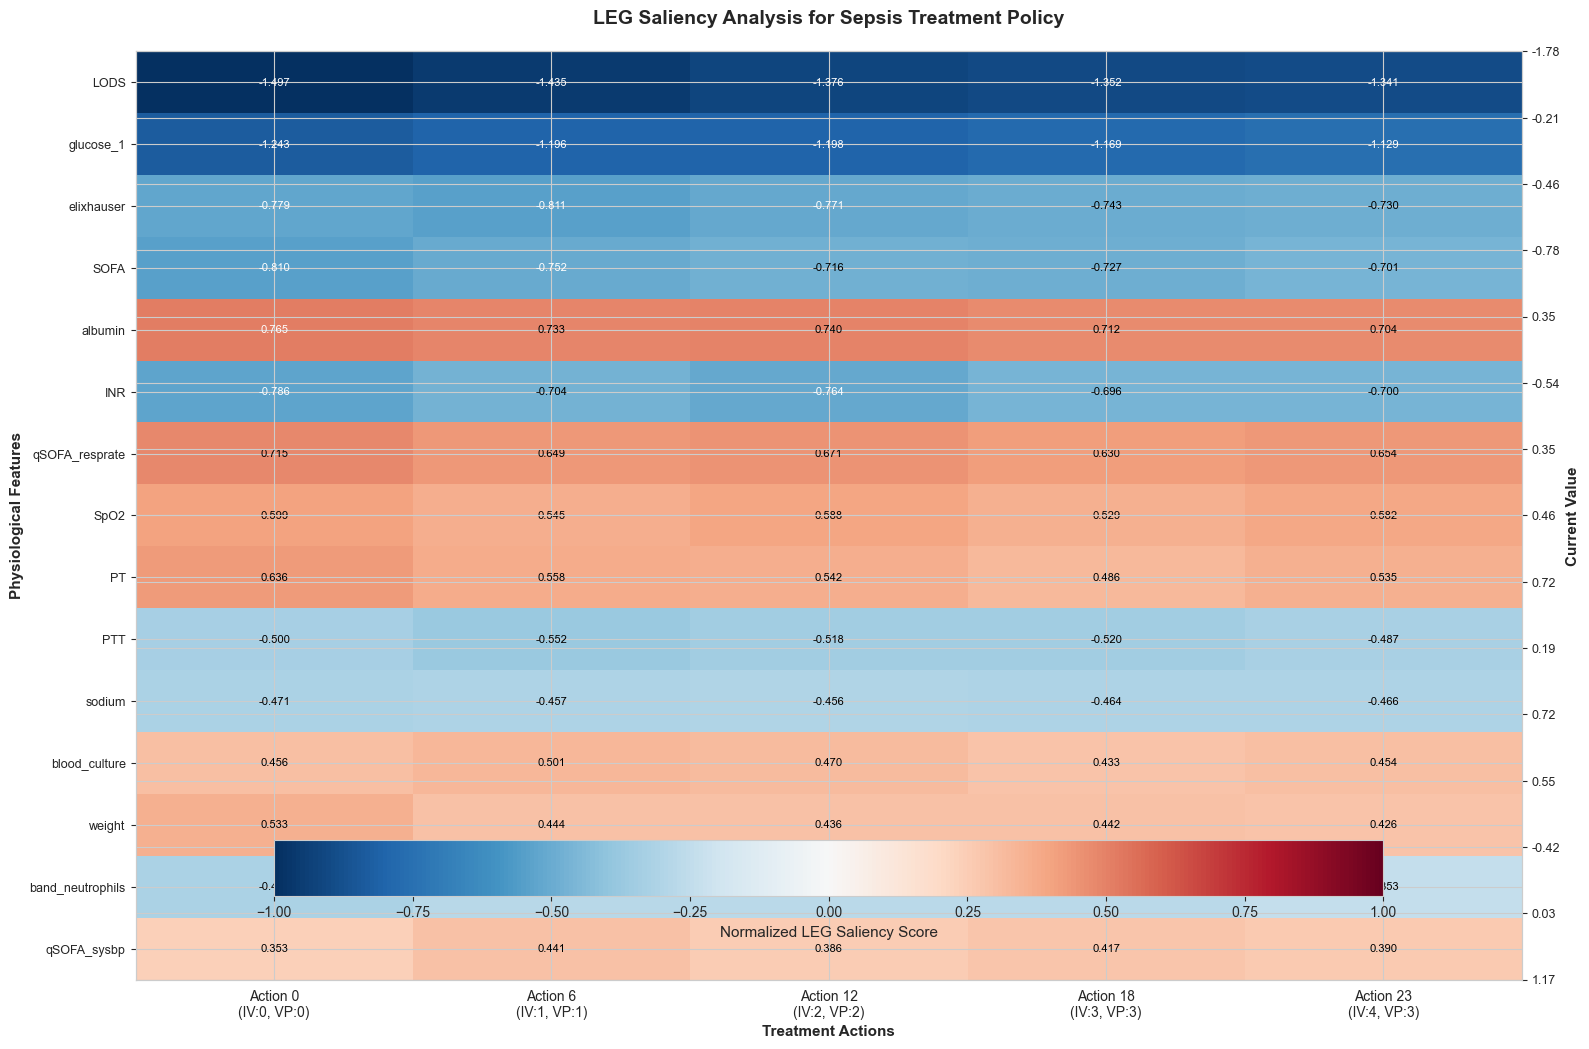


--- Analyzing Treatment Patterns ---
Saved treatment pattern to ./sepsis_leg_analysis/sac_online_model_final/treatment_patterns.png


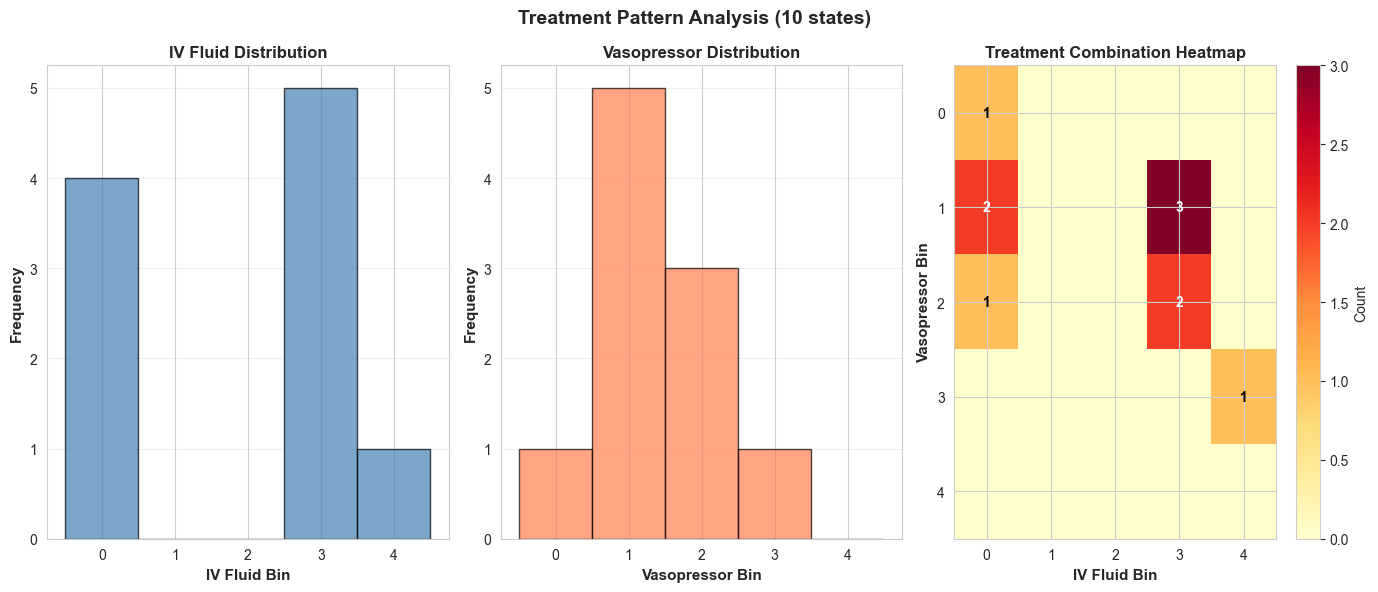


✓ Completed LEG analysis for 3 models


In [9]:
# Step 3: LEG Analysis for All Models
print('\n' + '='*80)
print('STEP 3: LEG Analysis for Multiple Models')
print('='*80)

# Store all analyses by model
all_model_analyses = {}

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Analyzing Model: {model_name}")
    print('='*80)
    
    output_dir = f'./sepsis_leg_analysis/{model_name}'
    
    analyses = perform_leg_analysis(
        dqn_model=model,
        test_dataset=test_set,
        n_states=10,
        output_dir=output_dir
    )
    
    all_model_analyses[model_name] = analyses

print(f"\n✓ Completed LEG analysis for {len(models)} models")

In [10]:
# Step 4: Aggregate Feature Importance Across All Models
print('\n' + '='*80)
print('STEP 4: Aggregating Feature Importance Across All Models')
print('='*80)

def aggregate_feature_importance(all_model_analyses, feature_names):
    """
    Aggregate feature importance scores across all models and states.
    
    Returns:
        - feature_importance_by_model: Dict[model_name -> feature_scores]
        - overall_feature_importance: Dict[feature_name -> aggregated_score]
        - feature_frequency: Dict[feature_name -> appearance_frequency]
    """
    feature_importance_by_model = {}
    overall_importance = defaultdict(list)
    feature_frequency = defaultdict(int)
    
    for model_name, analyses in all_model_analyses.items():
        model_feature_scores = defaultdict(list)
        
        # Aggregate across all states for this model
        for analysis in analyses:
            top_features = analysis['top_features']
            
            # Get absolute importance scores
            for name, score in zip(top_features['names'], top_features['scores']):
                abs_score = abs(score)
                model_feature_scores[name].append(abs_score)
                overall_importance[name].append(abs_score)
                feature_frequency[name] += 1
        
        # Average scores for this model
        feature_importance_by_model[model_name] = {
            feature: np.mean(scores) 
            for feature, scores in model_feature_scores.items()
        }
    
    # Calculate overall importance (mean across all models and states)
    overall_feature_importance = {
        feature: np.mean(scores)
        for feature, scores in overall_importance.items()
    }
    
    # Sort by importance
    overall_feature_importance = dict(
        sorted(overall_feature_importance.items(), 
               key=lambda x: x[1], 
               reverse=True)
    )
    
    return feature_importance_by_model, overall_feature_importance, dict(feature_frequency)

# Aggregate the results
feature_importance_by_model, overall_feature_importance, feature_frequency = \
    aggregate_feature_importance(all_model_analyses, FEATURE_NAMES)

# Display top 20 most important features overall
print('\n' + '='*80)
print('Top 20 Most Important Features (Across All Models)')
print('='*80)
print(f"{'Rank':<6} {'Feature':<25} {'Avg Importance':<18} {'Frequency':<12}")
print('-'*80)

for rank, (feature, importance) in enumerate(list(overall_feature_importance.items())[:20], 1):
    freq = feature_frequency[feature]
    print(f"{rank:<6} {feature:<25} {importance:<18.6f} {freq:<12}")

# Display top features by model
print('\n' + '='*80)
print('Top 10 Features by Model')
print('='*80)

for model_name in feature_importance_by_model:
    print(f"\n{model_name}:")
    model_features = sorted(
        feature_importance_by_model[model_name].items(),
        key=lambda x: x[1],
        reverse=True
    )[:10]
    
    for rank, (feature, importance) in enumerate(model_features, 1):
        print(f"  {rank}. {feature:<25} {importance:.6f}")



STEP 4: Aggregating Feature Importance Across All Models

Top 20 Most Important Features (Across All Models)
Rank   Feature                   Avg Importance     Frequency   
--------------------------------------------------------------------------------
1      INR                       2.551248           30          
2      qSOFA_sysbp               2.240556           15          
3      qSOFA                     2.115787           20          
4      elixhauser                2.006617           4           
5      height                    1.759181           1           
6      LODS                      1.746783           12          
7      glucose_1                 1.742391           25          
8      bilirubin                 1.672835           22          
9      ventilation               1.591856           2           
10     SOFA                      1.533270           6           
11     qSOFA_gcs                 1.513548           22          
12     qSOFA_resprate        


STEP 5: Visualizing Cross-Model Comparisons
Saved overall importance plot to ./sepsis_leg_analysis/overall_feature_importance.png


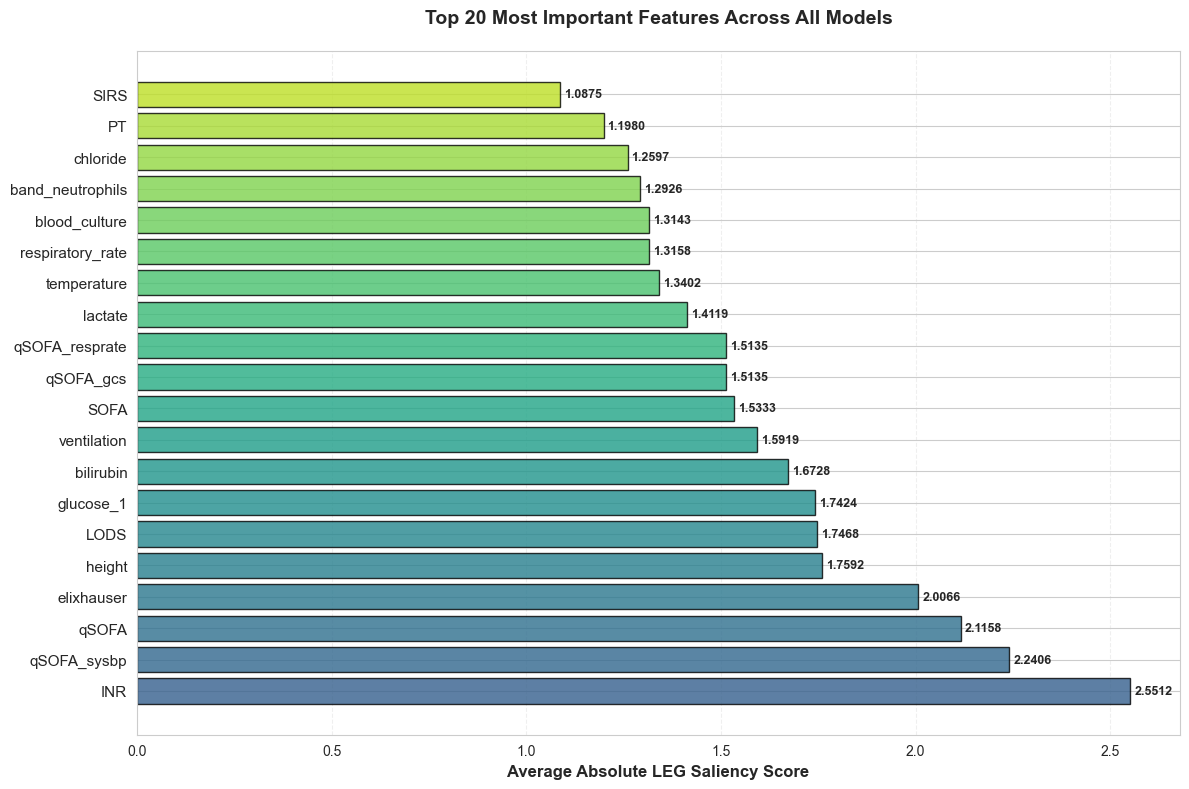

In [11]:
# Step 5: Visualize Cross-Model Feature Importance Comparison
print('\n' + '='*80)
print('STEP 5: Visualizing Cross-Model Comparisons')
print('='*80)

def plot_overall_feature_importance(overall_importance, top_k=20, save_path=None):
    """Plot overall feature importance across all models."""
    
    # Get top-k features
    top_features = list(overall_importance.items())[:top_k]
    features = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
    bars = ax.barh(range(len(features)), scores, color=colors, alpha=0.8, edgecolor='black')
    
    # Customize
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=11)
    ax.set_xlabel('Average Absolute LEG Saliency Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_k} Most Important Features Across All Models', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax.text(score + 0.01, i, f'{score:.4f}', 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f'Saved overall importance plot to {save_path}')
    
    plt.show()

# Plot overall importance
plot_overall_feature_importance(
    overall_feature_importance, 
    top_k=20,
    save_path='./sepsis_leg_analysis/overall_feature_importance.png'
)


In [11]:
# Step 6: Compare Feature Importance Across Models (Heatmap)
def plot_model_comparison_heatmap(feature_importance_by_model, overall_importance, 
                                   top_k=20, save_path=None):
    """Create heatmap comparing feature importance across models."""
    
    # Get top-k features from overall importance
    top_features = list(overall_importance.keys())[:top_k]
    model_names = list(feature_importance_by_model.keys())
    
    # Create data matrix
    data = np.zeros((top_k, len(model_names)))
    
    for j, model_name in enumerate(model_names):
        model_scores = feature_importance_by_model[model_name]
        for i, feature in enumerate(top_features):
            data[i, j] = model_scores.get(feature, 0.0)
    
    # Normalize by row (feature) for better visualization
    data_norm = data / (data.max(axis=1, keepdims=True) + 1e-8)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create heatmap
    im = ax.imshow(data_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=11)
    
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(top_features, fontsize=10)
    
    # Add text annotations with actual values
    for i in range(top_k):
        for j in range(len(model_names)):
            value = data[i, j]
            text_color = 'white' if data_norm[i, j] > 0.5 else 'black'
            ax.text(j, i, f'{value:.3f}',
                   ha='center', va='center', 
                   color=text_color, fontsize=8)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Normalized Importance Score', fontsize=11, fontweight='bold')
    
    # Title and labels
    ax.set_title('Feature Importance Comparison Across Models', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Features (Top 20)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f'Saved model comparison heatmap to {save_path}')
    
    plt.show()

# Plot comparison heatmap
plot_model_comparison_heatmap(
    feature_importance_by_model,
    overall_feature_importance,
    top_k=20,
    save_path='./sepsis_leg_analysis/model_comparison_heatmap.png'
)


Saved model comparison heatmap to ./sepsis_leg_analysis/model_comparison_heatmap.png


Saved consensus analysis to ./sepsis_leg_analysis/feature_consensus.png


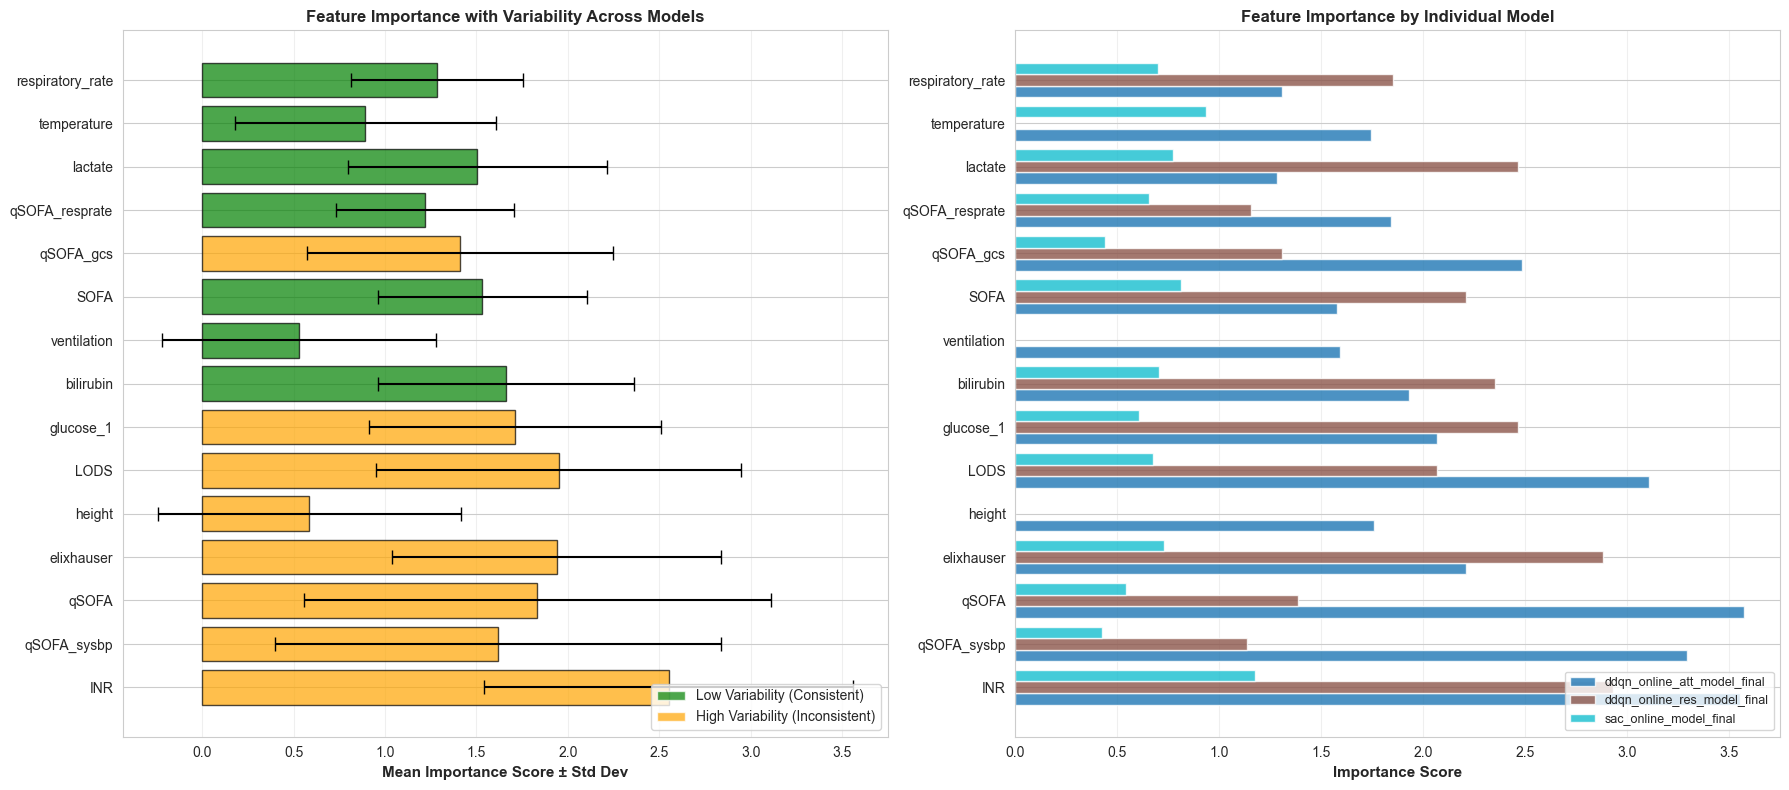


Feature Consensus Summary
Feature                   Mean         Std Dev      Consistency
--------------------------------------------------------------------------------
INR                            2.5512      1.0075  Low
qSOFA_sysbp                    1.6173      1.2202  Low
qSOFA                          1.8328      1.2764  Low
elixhauser                     1.9398      0.8990  Low
height                         0.5864      0.8293  Low
LODS                           1.9496      0.9971  Low
glucose_1                      1.7123      0.8000  Low
bilirubin                      1.6606      0.6991  High
ventilation                    0.5306      0.7504  High
SOFA                           1.5333      0.5708  High
qSOFA_gcs                      1.4110      0.8380  Low
qSOFA_resprate                 1.2168      0.4865  High
lactate                        1.5059      0.7089  High
temperature                    0.8935      0.7132  High
respiratory_rate               1.2856      0.4715  H

In [17]:
# Step 7: Feature Importance Consensus Analysis
def plot_feature_consensus(feature_importance_by_model, overall_importance, 
                            top_k=15, save_path=None):
    """
    Analyze which features are consistently important across all models.
    Shows agreement/disagreement between models.
    """
    
    top_features = list(overall_importance.keys())[:top_k]
    model_names = list(feature_importance_by_model.keys())
    n_models = len(model_names)
    
    # Calculate statistics for each feature
    feature_stats = {}
    for feature in top_features:
        scores = [feature_importance_by_model[m].get(feature, 0.0) 
                 for m in model_names]
        feature_stats[feature] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores),
            'scores': scores
        }
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Mean importance with error bars (std)
    features = list(feature_stats.keys())
    means = [feature_stats[f]['mean'] for f in features]
    stds = [feature_stats[f]['std'] for f in features]
    
    colors = ['green' if std < np.median(stds) else 'orange' 
             for std in stds]
    
    ax1.barh(range(len(features)), means, xerr=stds, 
            color=colors, alpha=0.7, edgecolor='black', capsize=5)
    ax1.set_yticks(range(len(features)))
    ax1.set_yticklabels(features, fontsize=10)
    ax1.set_xlabel('Mean Importance Score ± Std Dev', fontsize=11, fontweight='bold')
    ax1.set_title('Feature Importance with Variability Across Models', 
                 fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Low Variability (Consistent)'),
        Patch(facecolor='orange', alpha=0.7, label='High Variability (Inconsistent)')
    ]
    ax1.legend(handles=legend_elements, loc='lower right')
    
    # Plot 2: Individual model scores
    positions = np.arange(len(features))
    width = 0.8 / n_models
    
    colors_models = plt.cm.tab10(np.linspace(0, 1, n_models))
    
    for i, model_name in enumerate(model_names):
        scores = [feature_stats[f]['scores'][i] for f in features]
        offset = (i - n_models/2 + 0.5) * width
        ax2.barh(positions + offset, scores, width, 
                label=model_name, color=colors_models[i], alpha=0.8)
    
    ax2.set_yticks(positions)
    ax2.set_yticklabels(features, fontsize=10)
    ax2.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
    ax2.set_title('Feature Importance by Individual Model', 
                 fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f'Saved consensus analysis to {save_path}')
    
    plt.show()
    
    # Print consensus summary
    print('\n' + '='*80)
    print('Feature Consensus Summary')
    print('='*80)
    print(f"{'Feature':<25} {'Mean':<12} {'Std Dev':<12} {'Consistency'}")
    print('-'*80)
    
    for feature in features:
        stats = feature_stats[feature]
        consistency = 'High' if stats['std'] < np.median([s['std'] for s in feature_stats.values()]) else 'Low'
        print(f"{feature:<25} {stats['mean']:>11.4f} {stats['std']:>11.4f}  {consistency}")

# Plot consensus analysis
plot_feature_consensus(
    feature_importance_by_model,
    overall_feature_importance,
    top_k= 15,
    save_path='./sepsis_leg_analysis/feature_consensus.png'
)


In [18]:
# Step 8: Save Results for Further Analysis
import json
from datetime import datetime

# Prepare results dictionary
results_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models_analyzed': list(models.keys()),
    'n_models': len(models),
    'n_states_per_model': 10,
    'top_20_features_overall': {
        feature: float(score) 
        for feature, score in list(overall_feature_importance.items())[:20]
    },
    'feature_importance_by_model': {
        model: {
            feature: float(score)
            for feature, score in sorted(
                scores.items(), 
                key=lambda x: x[1], 
                reverse=True
            )[:20]
        }
        for model, scores in feature_importance_by_model.items()
    },
    'feature_frequency': feature_frequency
}

# Save as JSON
output_json = './sepsis_leg_analysis/multi_model_feature_importance.json'
with open(output_json, 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"✓ Saved results to {output_json}")

# Save full analysis results as pickle for detailed analysis
output_pkl = './sepsis_leg_analysis/multi_model_full_analysis.pkl'
with open(output_pkl, 'wb') as f:
    pickle.dump({
        'all_model_analyses': all_model_analyses,
        'feature_importance_by_model': feature_importance_by_model,
        'overall_feature_importance': overall_feature_importance,
        'feature_frequency': feature_frequency
    }, f)
print(f"✓ Saved full analysis to {output_pkl}")

# Print final summary
print('\n' + '='*80)
print('MULTI-MODEL LEG ANALYSIS COMPLETE')
print('='*80)
print(f"Models Analyzed: {len(models)}")
print(f"States per Model: 10")
print(f"Total Analyses: {len(models) * 10}")
print(f"\nTop 5 Most Important Features (Overall):")
for i, (feature, score) in enumerate(list(overall_feature_importance.items())[:5], 1):
    print(f"  {i}. {feature:<25} {score:.6f}")

print(f"\nResults saved to:")
print(f"  - JSON Summary: {output_json}")
print(f"  - Full Analysis: {output_pkl}")
print(f"  - Visualizations: ./sepsis_leg_analysis/")
print('='*80)


✓ Saved results to ./sepsis_leg_analysis/multi_model_feature_importance.json
✓ Saved full analysis to ./sepsis_leg_analysis/multi_model_full_analysis.pkl

MULTI-MODEL LEG ANALYSIS COMPLETE
Models Analyzed: 3
States per Model: 10
Total Analyses: 30

Top 5 Most Important Features (Overall):
  1. INR                       2.551248
  2. qSOFA_sysbp               2.240556
  3. qSOFA                     2.115787
  4. elixhauser                2.006617
  5. height                    1.759181

Results saved to:
  - JSON Summary: ./sepsis_leg_analysis/multi_model_feature_importance.json
  - Full Analysis: ./sepsis_leg_analysis/multi_model_full_analysis.pkl
  - Visualizations: ./sepsis_leg_analysis/


## Summary of Multi-Model LEG Analysis

This notebook now supports analyzing multiple reinforcement learning models simultaneously using Linearly Estimated Gradients (LEG). 

### Key Features:
1. **Multi-Model Support**: Load and analyze multiple `.d3` models (DoubleDQN, DiscreteSAC, etc.)
2. **Feature Importance Aggregation**: Identify the most important features across all models
3. **Comparative Visualizations**: 
   - Overall feature importance ranking
   - Model comparison heatmaps
   - Consensus analysis showing feature consistency
4. **Automated Results Export**: JSON and pickle files for further analysis

### How to Add More Models:
Edit the `MODEL_PATHS` list in Step 2 to include additional model paths:
```python
MODEL_PATHS = [
    r"path/to/model1.d3",
    r"path/to/model2.d3",
    r"path/to/model3.d3",
    # Add more models here
]
```

### Interpretation:
- **High Importance Score**: Feature strongly influences treatment decisions
- **Low Std Dev (Green)**: Feature is consistently important across all models
- **High Std Dev (Orange)**: Feature importance varies between models
- **High Frequency**: Feature appears in top-k features across many states/models
